In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import math
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [36]:
# Root directory for dataset
dataroot = "/media/storage/repos/FifaGAN/data/celeba"

# Number of workers for dataloader
workers = 4

# Number of channels in the training images. For color images this is 3
nc = 3

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

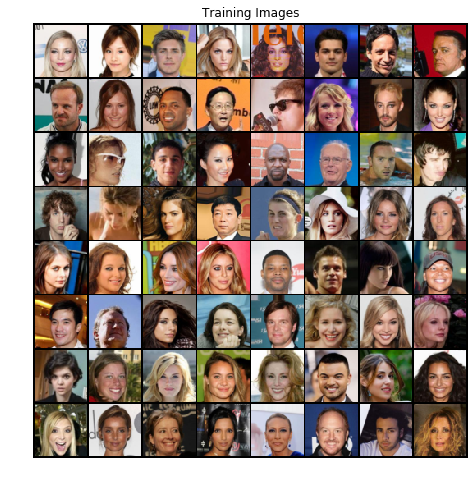

In [37]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                         shuffle=True, num_workers=workers)



# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
class GeneratorLayer(nn.Module):
    def __init__(self, in_channels, out_channels, weights_init, kernel_size, stride, padding):
        super(GeneratorLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels,
                               out_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding,
                               bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer.apply(weights_init)
    def forward(self, input):
        return self.layer(input)

In [6]:
class ToRGB(nn.Module):
    def __init__(self, in_channels, weights_init, out_channels=3):
        super(ToRGB, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels               = in_channels,
                      out_channels              = out_channels,
                      kernel_size               = 1,
                      stride                    = 1,
                      padding                   = 0,
                      bias                      = False),
            #nn.BatchNorm2d(out_channels),
            nn.Tanh())
        
        self.layer.apply(weights_init)
    def forward(self, input):
        return self.layer(input)

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_size, in_channels, weights_init, kernel_size=4, stride=2, padding=1):
        super(Generator, self).__init__()
        self.in_channels = in_channels
        self.weights_init = weights_init
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.layers = nn.ModuleList([])
        self.add_layer(latent_size, self.in_channels)
        self.add_layer()
        
    def add_layer(self, in_channels=None, out_channels=None):
        if not in_channels: in_channels = self.out_channels
        if not out_channels: out_channels = int(in_channels/2)
            
        self.layers.append(GeneratorLayer(in_channels,
                                          out_channels,
                                          self.weights_init,
                                          self.kernel_size,
                                          self.stride,
                                          self.padding).to(device))
        
        self.out_channels = out_channels
        self.toRGB = ToRGB(in_channels=out_channels,
                           weights_init = self.weights_init).to(device)
        
        self.net = nn.Sequential(*self.layers, self.toRGB)
        
    def forward(self, input, verbose=True):
        if verbose:
            print('Generator forward')
            print('Input shape', input.shape)

        x = self.net(input)
        if verbose: print(x.shape)  
            
        return x

In [9]:
class Generator2(nn.Module):
    def __init__(self, latent_size, in_channels, weights_init, kernel_size=4, stride=2, padding=1):
        super(Generator, self).__init__()
        self.in_channels   = in_channels
        self.weights_init  = weights_init
        self.kernel_size   = kernel_size
        self.stride        = stride
        self.padding       = padding
        self.layers        = nn.ModuleList([])
        self.outputs       = nn.ModuleList([])
        self.add_layer(latent_size, self.in_channels)
        self.add_layer()
        
    def add_layer(self, in_channels=None, out_channels=None):
        if not in_channels: in_channels = self.out_channels
        if not out_channels: out_channels = int(in_channels/2)
            
        self.layers.append(GeneratorLayer(in_channels,
                                          out_channels,
                                          self.weights_init,
                                          self.kernel_size,
                                          self.stride,
                                          self.padding).to(device))
        
        self.out_channels = out_channels
        self.outputs.append(ToRGB(out_channels,self.weights_init).to(device))
        
    def forward(self, input, verbose=True):
        if verbose:
            print('Generator forward')
            print('Input shape', input.shape)
            
        x = input
        for layer in self.layers:
            x = layer(x)
            if verbose: print(x.shape)
        x = self.toRGB(x)
        if verbose: print(x.shape)
        return x

In [8]:
class FromRGB(nn.Module):
    def __init__(self, out_channels, weights_init, in_channels=3):
        super(FromRGB, self).__init__()
        self.out_channels = out_channels
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels = in_channels,
                               out_channels = out_channels,
                               kernel_size=1,
                               stride=1,
                               padding=0,
                               bias=False),
            #nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True))
        
        self.layer.apply(weights_init)
    def forward(self, input):
        return self.layer(input)

In [9]:
class DiscriminatorLayer(nn.Module):
    def __init__(self, in_channels, out_channels, weights_init, kernel_size, stride, padding):
        super(DiscriminatorLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels,
                      out_channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer.apply(weights_init)
    def forward(self, input):
        return self.layer(input)

In [22]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, out_channels, weights_init, kernel_size=4, stride=2, padding=1):
        super(Discriminator, self).__init__()
        self.in_channels     = in_channels
        self.out_channels    = out_channels
        self.weights_init    = weights_init
        self.kernel_size     = kernel_size
        self.stride          = stride
        self.padding         = padding
        self.layers          = nn.ModuleList([])
        
        self.output = nn.Sequential(
            nn.Conv2d(out_channels, 1, kernel_size=2, stride=1, padding=0, bias=False).to(device),
            nn.Sigmoid())
        
        self.add_layer(in_channels)
        
        
    def add_layer(self, in_channels):
        self.in_channels = in_channels
        self.layers.insert(0, DiscriminatorLayer(self.in_channels,
                               int(self.in_channels*2),
                               self.weights_init,
                               self.kernel_size,
                               self.stride,
                               self.padding).to(device))
        
        self.fromRGB = FromRGB(self.in_channels, weights_init=self.weights_init).to(device)
        self.net = nn.Sequential(self.fromRGB, *self.layers, self.output)
        
    def forward(self, input, verbose=True):
        if verbose:
            print('Discriminator forward')
            print('Input shape', input.shape)
            
        x = self.net(input)
        if verbose: print('layer', x.shape)
            
        return x

In [23]:
class ProGAN(nn.Module):
    def __init__(self, ngpu, device, latent_size, in_channels, init_layers,
                 layer_progression, batch_size, weights_init, criterion,
                 verbose=False):
        
        super(ProGAN, self).__init__()
        self.ngpu                    = ngpu
        self.latent_size             = latent_size
        self.layer_progression       = layer_progression
        self.batch_size              = batch_size
        self.criterion               = criterion
        self.device                  = device
        self.generator               = Generator(latent_size,in_channels,weights_init).to(device)
        self.discriminator           = Discriminator(self.generator.out_channels,
                                           self.generator.in_channels,
                                           weights_init).to(device)

        self.image_size = 4
        
        for i in range(init_layers):
            self.add_layer()
        
    def add_layer(self):
        self.generator.add_layer()
        self.discriminator.add_layer(self.generator.out_channels)
        
        if (self.device.type == 'cuda') and (self.ngpu > 1):
            self.generator = nn.DataParallel(self.generator, list(range(self.ngpu)))
            self.discriminator = nn.DataParallel(self.discriminator, list(range(self.ngpu)))
            
        self.optimizerG = optim.Adam(self.generator.parameters(), lr=lr, betas=(beta1, 0.999))
        self.optimizerD = optim.Adam(self.discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
        
        self.image_size = self.image_size*2
        
    def discriminator_forward(self, data, verbose=False):
        ## Train with REAL batch
        self.discriminator.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        self.batch_size = real_cpu.size(0)
        #labels = torch.full((self.batch_size,), self.real_label, device=device)
        labels = torch.FloatTensor(self.batch_size).uniform_(0.0, 0.3).to(device)

        # Forward pass real batch through D
        output = self.discriminator(real_cpu, verbose).view(-1)
        # Calculate loss on all-real batch
        errD_real = self.criterion(output, labels)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        self.D_x = output.mean().item()
        
        
        # Generate batch of latent vectors
        noise = torch.randn(self.batch_size, self.latent_size, 1, 1, device=device)
        # Generate fake image batch with G
        self.fake = self.generator(noise, verbose)
        #labels.fill_(self.fake_label)
        labels = torch.FloatTensor(self.batch_size).uniform_(0.7, 1.0).to(device)
        # Classify all FAKE batch with D
        output = self.discriminator(self.fake.detach(), verbose).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = self.criterion(output, labels)
        # Calculate the gradients for this batch
        errD_fake.backward()
        self.D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        self.errD = errD_real + errD_fake
        # Update D
        self.optimizerD.step()
        
    def generator_forward(self, verbose=True):
        self.generator.zero_grad()
        labels = torch.full((self.batch_size,), 0, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = self.discriminator(self.fake, verbose).view(-1)
        # Calculate G's loss based on this output
        self.errG = self.criterion(output, labels)
        # Calculate gradients for G
        self.errG.backward()
        self.D_G_z2 = output.mean().item()
        # Update G
        self.optimizerG.step()
        
    def forward(self, data, verbose=False):
        self.discriminator_forward(data, verbose)
        self.generator_forward(verbose)

In [38]:
proGAN = ProGAN(
    ngpu                  = 1,
    device                = device,
    latent_size           = 128,
    in_channels           = 512,
    init_layers           = 3,
    layer_progression     = 3,
    batch_size            = 512,
    weights_init          = weights_init,
    criterion             = nn.BCELoss()
)

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, proGAN.latent_size, 1, 1, device=device)
outD = proGAN.discriminator(proGAN.generator(fixed_noise, True), True)

Generator forward
Input shape torch.Size([64, 128, 1, 1])
torch.Size([64, 3, 32, 32])
Discriminator forward
Input shape torch.Size([64, 3, 32, 32])
layer torch.Size([64, 1, 1, 1])


Starting Training Loop...
[0/5][0/22511]	Loss_D: 0.9671	Loss_G: 1.8965	D(x): 0.0623	D(G(z)): 0.9254 / 0.8364
[0/5][50/22511]	Loss_D: 1.5451	Loss_G: 1.7258	D(x): 0.7152	D(G(z)): 0.9141 / 0.8093
[0/5][100/22511]	Loss_D: 0.8920	Loss_G: 1.3615	D(x): 0.2674	D(G(z)): 0.7984 / 0.7307
[0/5][150/22511]	Loss_D: 1.0086	Loss_G: 2.0580	D(x): 0.2904	D(G(z)): 0.8357 / 0.8696
[0/5][200/22511]	Loss_D: 1.1536	Loss_G: 1.9152	D(x): 0.0664	D(G(z)): 0.7780 / 0.8509
[0/5][250/22511]	Loss_D: 1.0651	Loss_G: 2.6223	D(x): 0.0853	D(G(z)): 0.5909 / 0.9230
[0/5][300/22511]	Loss_D: 1.0117	Loss_G: 2.2180	D(x): 0.2083	D(G(z)): 0.7095 / 0.8859
[0/5][350/22511]	Loss_D: 1.1997	Loss_G: 2.0075	D(x): 0.4226	D(G(z)): 0.6887 / 0.8552
[0/5][400/22511]	Loss_D: 1.0857	Loss_G: 2.4650	D(x): 0.3042	D(G(z)): 0.6102 / 0.9102
[0/5][450/22511]	Loss_D: 1.1221	Loss_G: 2.0013	D(x): 0.0963	D(G(z)): 0.6197 / 0.8624
[0/5][500/22511]	Loss_D: 0.8717	Loss_G: 2.1674	D(x): 0.1630	D(G(z)): 0.7308 / 0.8800
[0/5][550/22511]	Loss_D: 1.1207	Loss_G: 2.

[0/5][4800/22511]	Loss_D: 0.9391	Loss_G: 1.5922	D(x): 0.3029	D(G(z)): 0.8618 / 0.7934
[0/5][4850/22511]	Loss_D: 1.0196	Loss_G: 1.7171	D(x): 0.1646	D(G(z)): 0.8512 / 0.8139
[0/5][4900/22511]	Loss_D: 1.0070	Loss_G: 1.8426	D(x): 0.0868	D(G(z)): 0.7462 / 0.8361
[0/5][4950/22511]	Loss_D: 0.9250	Loss_G: 1.3889	D(x): 0.2150	D(G(z)): 0.7271 / 0.7462
[0/5][5000/22511]	Loss_D: 0.8271	Loss_G: 1.7002	D(x): 0.1675	D(G(z)): 0.7844 / 0.8066
[0/5][5050/22511]	Loss_D: 1.0973	Loss_G: 2.0355	D(x): 0.0409	D(G(z)): 0.7256 / 0.8577
[0/5][5100/22511]	Loss_D: 0.9800	Loss_G: 2.4339	D(x): 0.2548	D(G(z)): 0.6381 / 0.9101
[0/5][5150/22511]	Loss_D: 0.9158	Loss_G: 1.8759	D(x): 0.2167	D(G(z)): 0.7667 / 0.8416
[0/5][5200/22511]	Loss_D: 0.8193	Loss_G: 1.9198	D(x): 0.2429	D(G(z)): 0.8230 / 0.8429
[0/5][5250/22511]	Loss_D: 0.9621	Loss_G: 2.0764	D(x): 0.2077	D(G(z)): 0.6207 / 0.8701
[0/5][5300/22511]	Loss_D: 0.9579	Loss_G: 1.6194	D(x): 0.3388	D(G(z)): 0.8336 / 0.7889
[0/5][5350/22511]	Loss_D: 1.0327	Loss_G: 2.2133	D(x): 

[0/5][9600/22511]	Loss_D: 1.4311	Loss_G: 1.4155	D(x): 0.5767	D(G(z)): 0.9085 / 0.7449
[0/5][9650/22511]	Loss_D: 1.0002	Loss_G: 1.8649	D(x): 0.3519	D(G(z)): 0.8305 / 0.8404
[0/5][9700/22511]	Loss_D: 1.1317	Loss_G: 2.3056	D(x): 0.0407	D(G(z)): 0.6688 / 0.8942
[0/5][9750/22511]	Loss_D: 0.7694	Loss_G: 1.9840	D(x): 0.0613	D(G(z)): 0.8103 / 0.8507
[0/5][9800/22511]	Loss_D: 1.0047	Loss_G: 1.9700	D(x): 0.3318	D(G(z)): 0.9157 / 0.8527
[0/5][9850/22511]	Loss_D: 0.8719	Loss_G: 2.1130	D(x): 0.1293	D(G(z)): 0.7255 / 0.8761
[0/5][9900/22511]	Loss_D: 0.9772	Loss_G: 2.0727	D(x): 0.1531	D(G(z)): 0.6989 / 0.8684
[0/5][9950/22511]	Loss_D: 0.9737	Loss_G: 1.9543	D(x): 0.1551	D(G(z)): 0.7666 / 0.8552
[0/5][10000/22511]	Loss_D: 1.2101	Loss_G: 2.7731	D(x): 0.1966	D(G(z)): 0.4333 / 0.9336
[0/5][10050/22511]	Loss_D: 1.0215	Loss_G: 1.6834	D(x): 0.1381	D(G(z)): 0.7790 / 0.8068
[0/5][10100/22511]	Loss_D: 0.7744	Loss_G: 2.6158	D(x): 0.1324	D(G(z)): 0.7743 / 0.9258
[0/5][10150/22511]	Loss_D: 1.0082	Loss_G: 1.8821	D(

[0/5][14350/22511]	Loss_D: 1.0636	Loss_G: 2.2589	D(x): 0.0421	D(G(z)): 0.7485 / 0.8920
[0/5][14400/22511]	Loss_D: 0.8439	Loss_G: 2.0176	D(x): 0.2757	D(G(z)): 0.8560 / 0.8598
[0/5][14450/22511]	Loss_D: 0.9761	Loss_G: 1.8777	D(x): 0.2905	D(G(z)): 0.8506 / 0.8424
[0/5][14500/22511]	Loss_D: 1.0739	Loss_G: 2.5486	D(x): 0.0697	D(G(z)): 0.6485 / 0.9190
[0/5][14550/22511]	Loss_D: 0.7646	Loss_G: 2.3768	D(x): 0.0954	D(G(z)): 0.9138 / 0.9025
[0/5][14600/22511]	Loss_D: 0.8724	Loss_G: 2.1485	D(x): 0.2636	D(G(z)): 0.8451 / 0.8807
[0/5][14650/22511]	Loss_D: 0.8983	Loss_G: 2.0217	D(x): 0.3084	D(G(z)): 0.8264 / 0.8528
[0/5][14700/22511]	Loss_D: 1.1020	Loss_G: 1.7848	D(x): 0.3935	D(G(z)): 0.6829 / 0.8251
[0/5][14750/22511]	Loss_D: 1.0617	Loss_G: 2.0739	D(x): 0.1892	D(G(z)): 0.6154 / 0.8714
[0/5][14800/22511]	Loss_D: 1.3432	Loss_G: 1.5969	D(x): 0.6234	D(G(z)): 0.8668 / 0.7798
[0/5][14850/22511]	Loss_D: 0.8320	Loss_G: 2.7609	D(x): 0.0632	D(G(z)): 0.8579 / 0.9312
[0/5][14900/22511]	Loss_D: 0.8692	Loss_G: 1

[0/5][19100/22511]	Loss_D: 0.8705	Loss_G: 1.7546	D(x): 0.2371	D(G(z)): 0.8102 / 0.8223
[0/5][19150/22511]	Loss_D: 0.9266	Loss_G: 1.5358	D(x): 0.3049	D(G(z)): 0.7959 / 0.7779
[0/5][19200/22511]	Loss_D: 0.9761	Loss_G: 2.0340	D(x): 0.2209	D(G(z)): 0.6737 / 0.8666
[0/5][19250/22511]	Loss_D: 1.0167	Loss_G: 1.2510	D(x): 0.2917	D(G(z)): 0.7520 / 0.7059
[0/5][19300/22511]	Loss_D: 0.9501	Loss_G: 1.9266	D(x): 0.2738	D(G(z)): 0.9011 / 0.8500
[0/5][19350/22511]	Loss_D: 0.8786	Loss_G: 1.6391	D(x): 0.2288	D(G(z)): 0.7866 / 0.8013
[0/5][19400/22511]	Loss_D: 0.9566	Loss_G: 2.0351	D(x): 0.3756	D(G(z)): 0.8878 / 0.8601
[0/5][19450/22511]	Loss_D: 0.8875	Loss_G: 1.7547	D(x): 0.1368	D(G(z)): 0.7663 / 0.8193
[0/5][19500/22511]	Loss_D: 0.9861	Loss_G: 2.7109	D(x): 0.0877	D(G(z)): 0.5414 / 0.9306
[0/5][19550/22511]	Loss_D: 1.0788	Loss_G: 1.8060	D(x): 0.0884	D(G(z)): 0.6153 / 0.8333
[0/5][19600/22511]	Loss_D: 1.1672	Loss_G: 1.2648	D(x): 0.4929	D(G(z)): 0.7353 / 0.7146
[0/5][19650/22511]	Loss_D: 0.8291	Loss_G: 1

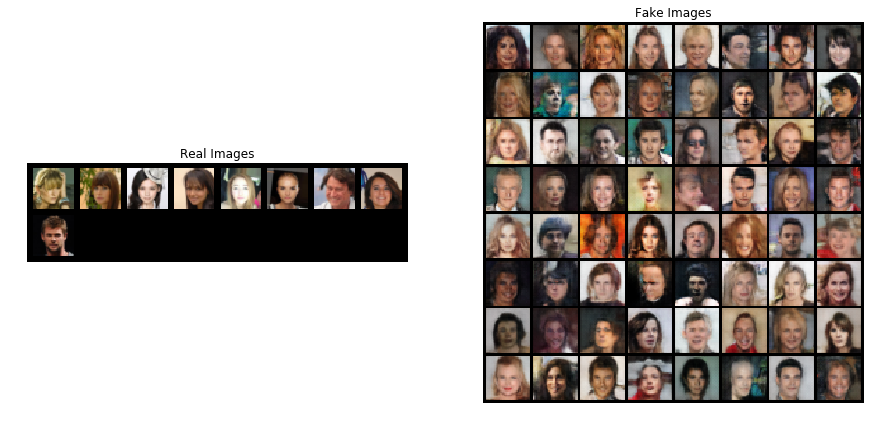

[1/5][0/22511]	Loss_D: 0.7652	Loss_G: 2.1480	D(x): 0.2641	D(G(z)): 0.8675 / 0.8764
[1/5][50/22511]	Loss_D: 0.8517	Loss_G: 2.3218	D(x): 0.1122	D(G(z)): 0.8048 / 0.8926
[1/5][100/22511]	Loss_D: 0.8954	Loss_G: 1.7346	D(x): 0.1667	D(G(z)): 0.7591 / 0.8174
[1/5][150/22511]	Loss_D: 1.0713	Loss_G: 2.0925	D(x): 0.4340	D(G(z)): 0.7873 / 0.8628
[1/5][200/22511]	Loss_D: 0.9198	Loss_G: 1.8130	D(x): 0.2165	D(G(z)): 0.7792 / 0.8290
[1/5][250/22511]	Loss_D: 1.2594	Loss_G: 2.4174	D(x): 0.0501	D(G(z)): 0.5690 / 0.9066
[1/5][300/22511]	Loss_D: 1.1284	Loss_G: 1.2401	D(x): 0.4327	D(G(z)): 0.6818 / 0.7044
[1/5][350/22511]	Loss_D: 1.0746	Loss_G: 1.6859	D(x): 0.3917	D(G(z)): 0.7367 / 0.8119
[1/5][400/22511]	Loss_D: 0.8706	Loss_G: 2.4988	D(x): 0.0823	D(G(z)): 0.9052 / 0.9076
[1/5][450/22511]	Loss_D: 0.8357	Loss_G: 2.4856	D(x): 0.1287	D(G(z)): 0.9076 / 0.9149
[1/5][500/22511]	Loss_D: 0.7800	Loss_G: 1.7256	D(x): 0.1132	D(G(z)): 0.8473 / 0.8151
[1/5][550/22511]	Loss_D: 0.8786	Loss_G: 1.7309	D(x): 0.3299	D(G(z)):

[1/5][4800/22511]	Loss_D: 0.9505	Loss_G: 2.1931	D(x): 0.3436	D(G(z)): 0.8684 / 0.8785
[1/5][4850/22511]	Loss_D: 0.9396	Loss_G: 2.0840	D(x): 0.1134	D(G(z)): 0.6770 / 0.8729
[1/5][4900/22511]	Loss_D: 1.3270	Loss_G: 1.6402	D(x): 0.5500	D(G(z)): 0.9229 / 0.8022
[1/5][4950/22511]	Loss_D: 1.3894	Loss_G: 2.3726	D(x): 0.1926	D(G(z)): 0.3754 / 0.8989
[1/5][5000/22511]	Loss_D: 0.9684	Loss_G: 2.3646	D(x): 0.1887	D(G(z)): 0.8245 / 0.8917
[1/5][5050/22511]	Loss_D: 0.8472	Loss_G: 2.3632	D(x): 0.1619	D(G(z)): 0.8978 / 0.8962
[1/5][5100/22511]	Loss_D: 1.0297	Loss_G: 1.9479	D(x): 0.4010	D(G(z)): 0.7987 / 0.8440
[1/5][5150/22511]	Loss_D: 1.0053	Loss_G: 2.0475	D(x): 0.2605	D(G(z)): 0.6858 / 0.8631
[1/5][5200/22511]	Loss_D: 0.9809	Loss_G: 2.9290	D(x): 0.1472	D(G(z)): 0.6779 / 0.9445
[1/5][5250/22511]	Loss_D: 0.9340	Loss_G: 1.7557	D(x): 0.3043	D(G(z)): 0.7774 / 0.8179
[1/5][5300/22511]	Loss_D: 0.8426	Loss_G: 1.9198	D(x): 0.2272	D(G(z)): 0.9047 / 0.8475
[1/5][5350/22511]	Loss_D: 0.8667	Loss_G: 2.0327	D(x): 

[1/5][9600/22511]	Loss_D: 0.7637	Loss_G: 2.0761	D(x): 0.1975	D(G(z)): 0.8342 / 0.8693
[1/5][9650/22511]	Loss_D: 1.2285	Loss_G: 2.2972	D(x): 0.5718	D(G(z)): 0.9469 / 0.8930
[1/5][9700/22511]	Loss_D: 0.9112	Loss_G: 1.6588	D(x): 0.2701	D(G(z)): 0.7743 / 0.8026
[1/5][9750/22511]	Loss_D: 1.0271	Loss_G: 1.8114	D(x): 0.4274	D(G(z)): 0.8467 / 0.8320
[1/5][9800/22511]	Loss_D: 0.9681	Loss_G: 2.0360	D(x): 0.1792	D(G(z)): 0.8701 / 0.8592
[1/5][9850/22511]	Loss_D: 0.9597	Loss_G: 1.8957	D(x): 0.2940	D(G(z)): 0.8285 / 0.8465
[1/5][9900/22511]	Loss_D: 0.9223	Loss_G: 2.3139	D(x): 0.0681	D(G(z)): 0.6377 / 0.8995
[1/5][9950/22511]	Loss_D: 0.9871	Loss_G: 1.7684	D(x): 0.3721	D(G(z)): 0.8547 / 0.8174
[1/5][10000/22511]	Loss_D: 1.2104	Loss_G: 1.6394	D(x): 0.5159	D(G(z)): 0.7805 / 0.8025
[1/5][10050/22511]	Loss_D: 0.9348	Loss_G: 1.7581	D(x): 0.2078	D(G(z)): 0.7214 / 0.8195
[1/5][10100/22511]	Loss_D: 0.9008	Loss_G: 1.8274	D(x): 0.0816	D(G(z)): 0.7593 / 0.8306
[1/5][10150/22511]	Loss_D: 0.9200	Loss_G: 1.8768	D(

[1/5][14350/22511]	Loss_D: 0.9101	Loss_G: 1.7591	D(x): 0.1191	D(G(z)): 0.7301 / 0.8236
[1/5][14400/22511]	Loss_D: 0.9769	Loss_G: 2.1250	D(x): 0.1543	D(G(z)): 0.6275 / 0.8732
[1/5][14450/22511]	Loss_D: 1.0168	Loss_G: 1.5212	D(x): 0.2968	D(G(z)): 0.7546 / 0.7675
[1/5][14500/22511]	Loss_D: 1.0392	Loss_G: 2.1407	D(x): 0.0523	D(G(z)): 0.7489 / 0.8780
[1/5][14550/22511]	Loss_D: 0.9437	Loss_G: 1.7164	D(x): 0.3255	D(G(z)): 0.8063 / 0.8152
[1/5][14600/22511]	Loss_D: 0.9147	Loss_G: 2.2154	D(x): 0.3142	D(G(z)): 0.8218 / 0.8860
[1/5][14650/22511]	Loss_D: 1.4139	Loss_G: 1.7518	D(x): 0.6305	D(G(z)): 0.7765 / 0.8128
[1/5][14700/22511]	Loss_D: 1.0301	Loss_G: 1.8929	D(x): 0.2325	D(G(z)): 0.6460 / 0.8461
[1/5][14750/22511]	Loss_D: 0.9477	Loss_G: 1.9885	D(x): 0.1750	D(G(z)): 0.8493 / 0.8578
[1/5][14800/22511]	Loss_D: 0.9140	Loss_G: 1.8724	D(x): 0.0664	D(G(z)): 0.8450 / 0.8384
[1/5][14850/22511]	Loss_D: 0.9509	Loss_G: 1.5933	D(x): 0.2707	D(G(z)): 0.8063 / 0.7829
[1/5][14900/22511]	Loss_D: 0.9774	Loss_G: 1

[1/5][19100/22511]	Loss_D: 1.1480	Loss_G: 2.4853	D(x): 0.1217	D(G(z)): 0.5147 / 0.9127
[1/5][19150/22511]	Loss_D: 0.9658	Loss_G: 1.6020	D(x): 0.2532	D(G(z)): 0.6818 / 0.7941
[1/5][19200/22511]	Loss_D: 0.8932	Loss_G: 1.9061	D(x): 0.2134	D(G(z)): 0.8827 / 0.8406
[1/5][19250/22511]	Loss_D: 0.9644	Loss_G: 1.7528	D(x): 0.2144	D(G(z)): 0.7685 / 0.8253
[1/5][19300/22511]	Loss_D: 0.9136	Loss_G: 1.8953	D(x): 0.2009	D(G(z)): 0.7431 / 0.8412
[1/5][19350/22511]	Loss_D: 0.7380	Loss_G: 2.2315	D(x): 0.0961	D(G(z)): 0.7949 / 0.8900
[1/5][19400/22511]	Loss_D: 0.9365	Loss_G: 1.9596	D(x): 0.1545	D(G(z)): 0.6709 / 0.8495
[1/5][19450/22511]	Loss_D: 0.9863	Loss_G: 1.8604	D(x): 0.2430	D(G(z)): 0.7215 / 0.8381
[1/5][19500/22511]	Loss_D: 1.0069	Loss_G: 1.6698	D(x): 0.3410	D(G(z)): 0.8146 / 0.7969
[1/5][19550/22511]	Loss_D: 0.8181	Loss_G: 1.8457	D(x): 0.1761	D(G(z)): 0.8444 / 0.8360
[1/5][19600/22511]	Loss_D: 1.0909	Loss_G: 1.8651	D(x): 0.1546	D(G(z)): 0.6717 / 0.8427
[1/5][19650/22511]	Loss_D: 0.8907	Loss_G: 1

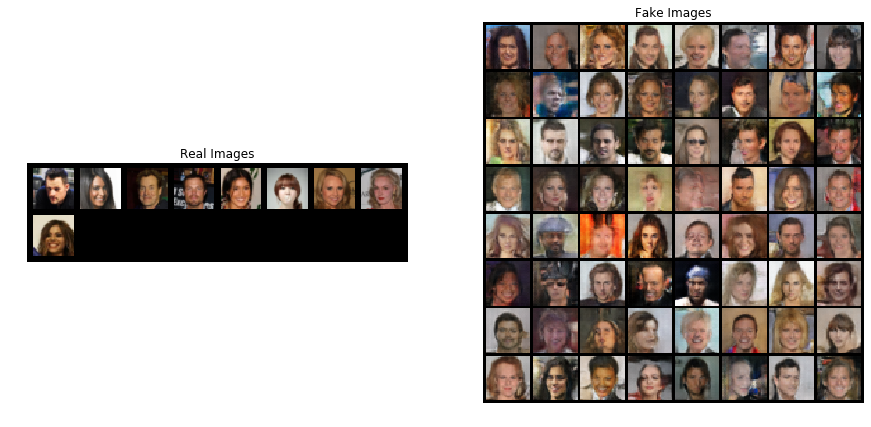

[2/5][0/22511]	Loss_D: 1.1588	Loss_G: 1.8929	D(x): 0.2819	D(G(z)): 0.6078 / 0.8459
[2/5][50/22511]	Loss_D: 0.8780	Loss_G: 1.9577	D(x): 0.2052	D(G(z)): 0.8115 / 0.8491
[2/5][100/22511]	Loss_D: 0.9851	Loss_G: 2.1378	D(x): 0.0935	D(G(z)): 0.8277 / 0.8804
[2/5][150/22511]	Loss_D: 1.0063	Loss_G: 2.2989	D(x): 0.0527	D(G(z)): 0.5797 / 0.8973
[2/5][200/22511]	Loss_D: 0.9146	Loss_G: 2.0356	D(x): 0.1178	D(G(z)): 0.6843 / 0.8640
[2/5][250/22511]	Loss_D: 0.9778	Loss_G: 2.4100	D(x): 0.0992	D(G(z)): 0.5976 / 0.9075
[2/5][300/22511]	Loss_D: 1.0594	Loss_G: 1.7733	D(x): 0.3026	D(G(z)): 0.6714 / 0.8268
[2/5][350/22511]	Loss_D: 1.0135	Loss_G: 2.0856	D(x): 0.2519	D(G(z)): 0.6641 / 0.8731
[2/5][400/22511]	Loss_D: 0.8761	Loss_G: 1.7442	D(x): 0.2097	D(G(z)): 0.8486 / 0.8224
[2/5][450/22511]	Loss_D: 1.3232	Loss_G: 1.2515	D(x): 0.5655	D(G(z)): 0.6514 / 0.7043
[2/5][500/22511]	Loss_D: 1.0590	Loss_G: 1.6249	D(x): 0.2836	D(G(z)): 0.7484 / 0.7975
[2/5][550/22511]	Loss_D: 0.9999	Loss_G: 2.3138	D(x): 0.1527	D(G(z)):

[2/5][4800/22511]	Loss_D: 0.9945	Loss_G: 1.6978	D(x): 0.2123	D(G(z)): 0.7665 / 0.8089
[2/5][4850/22511]	Loss_D: 0.9344	Loss_G: 1.5590	D(x): 0.1079	D(G(z)): 0.8136 / 0.7857
[2/5][4900/22511]	Loss_D: 0.9608	Loss_G: 2.3296	D(x): 0.3444	D(G(z)): 0.9209 / 0.8943
[2/5][4950/22511]	Loss_D: 0.8624	Loss_G: 1.9946	D(x): 0.1948	D(G(z)): 0.8788 / 0.8589
[2/5][5000/22511]	Loss_D: 1.4085	Loss_G: 2.2084	D(x): 0.6603	D(G(z)): 0.8908 / 0.8795
[2/5][5050/22511]	Loss_D: 0.9001	Loss_G: 1.9608	D(x): 0.1709	D(G(z)): 0.8400 / 0.8448
[2/5][5100/22511]	Loss_D: 0.8283	Loss_G: 2.0678	D(x): 0.0992	D(G(z)): 0.8404 / 0.8668
[2/5][5150/22511]	Loss_D: 0.8780	Loss_G: 1.8068	D(x): 0.0835	D(G(z)): 0.7837 / 0.8331
[2/5][5200/22511]	Loss_D: 0.8848	Loss_G: 1.7787	D(x): 0.1513	D(G(z)): 0.6464 / 0.8251
[2/5][5250/22511]	Loss_D: 1.0326	Loss_G: 1.7374	D(x): 0.0984	D(G(z)): 0.8465 / 0.8186
[2/5][5300/22511]	Loss_D: 0.9230	Loss_G: 2.5087	D(x): 0.0882	D(G(z)): 0.8261 / 0.9114
[2/5][5350/22511]	Loss_D: 0.7917	Loss_G: 2.0792	D(x): 

[2/5][9600/22511]	Loss_D: 0.9427	Loss_G: 1.6195	D(x): 0.1270	D(G(z)): 0.7563 / 0.7981
[2/5][9650/22511]	Loss_D: 1.0255	Loss_G: 1.6003	D(x): 0.3900	D(G(z)): 0.8337 / 0.7892
[2/5][9700/22511]	Loss_D: 1.1209	Loss_G: 2.1059	D(x): 0.2033	D(G(z)): 0.5875 / 0.8720
[2/5][9750/22511]	Loss_D: 0.9569	Loss_G: 2.2108	D(x): 0.1848	D(G(z)): 0.8942 / 0.8806
[2/5][9800/22511]	Loss_D: 1.0295	Loss_G: 1.9261	D(x): 0.2703	D(G(z)): 0.6681 / 0.8418
[2/5][9850/22511]	Loss_D: 0.9566	Loss_G: 2.0918	D(x): 0.3524	D(G(z)): 0.8983 / 0.8701
[2/5][9900/22511]	Loss_D: 1.0372	Loss_G: 1.7761	D(x): 0.3115	D(G(z)): 0.6370 / 0.8290
[2/5][9950/22511]	Loss_D: 1.2894	Loss_G: 1.4117	D(x): 0.5245	D(G(z)): 0.7111 / 0.7507
[2/5][10000/22511]	Loss_D: 0.8514	Loss_G: 2.1458	D(x): 0.2217	D(G(z)): 0.8456 / 0.8802
[2/5][10050/22511]	Loss_D: 1.1041	Loss_G: 1.4318	D(x): 0.4473	D(G(z)): 0.7410 / 0.7507
[2/5][10100/22511]	Loss_D: 0.9139	Loss_G: 2.2945	D(x): 0.1917	D(G(z)): 0.8842 / 0.8849
[2/5][10150/22511]	Loss_D: 0.8450	Loss_G: 1.9697	D(

[2/5][14350/22511]	Loss_D: 0.8807	Loss_G: 1.9140	D(x): 0.3312	D(G(z)): 0.8418 / 0.8470
[2/5][14400/22511]	Loss_D: 0.8407	Loss_G: 1.9319	D(x): 0.1828	D(G(z)): 0.7745 / 0.8519
[2/5][14450/22511]	Loss_D: 0.8479	Loss_G: 2.0313	D(x): 0.1840	D(G(z)): 0.8346 / 0.8673
[2/5][14500/22511]	Loss_D: 1.0199	Loss_G: 1.6177	D(x): 0.2605	D(G(z)): 0.7361 / 0.7951
[2/5][14550/22511]	Loss_D: 0.9385	Loss_G: 1.9147	D(x): 0.3531	D(G(z)): 0.8957 / 0.8471
[2/5][14600/22511]	Loss_D: 1.1284	Loss_G: 2.3013	D(x): 0.0442	D(G(z)): 0.6971 / 0.8949
[2/5][14650/22511]	Loss_D: 0.9493	Loss_G: 2.0142	D(x): 0.1857	D(G(z)): 0.7102 / 0.8556
[2/5][14700/22511]	Loss_D: 1.1098	Loss_G: 1.8355	D(x): 0.2006	D(G(z)): 0.8954 / 0.8191
[2/5][14750/22511]	Loss_D: 0.8549	Loss_G: 2.2452	D(x): 0.1178	D(G(z)): 0.7018 / 0.8924
[2/5][14800/22511]	Loss_D: 1.1385	Loss_G: 1.7679	D(x): 0.3290	D(G(z)): 0.6436 / 0.8259
[2/5][14850/22511]	Loss_D: 0.8188	Loss_G: 1.8235	D(x): 0.1598	D(G(z)): 0.7151 / 0.8347
[2/5][14900/22511]	Loss_D: 1.2828	Loss_G: 2

[2/5][19100/22511]	Loss_D: 0.9590	Loss_G: 1.8439	D(x): 0.2190	D(G(z)): 0.7438 / 0.8394
[2/5][19150/22511]	Loss_D: 0.7956	Loss_G: 1.7882	D(x): 0.2053	D(G(z)): 0.8319 / 0.8247
[2/5][19200/22511]	Loss_D: 0.9322	Loss_G: 1.6115	D(x): 0.1525	D(G(z)): 0.7122 / 0.7919
[2/5][19250/22511]	Loss_D: 1.0160	Loss_G: 1.2753	D(x): 0.3050	D(G(z)): 0.7518 / 0.7126
[2/5][19300/22511]	Loss_D: 0.9823	Loss_G: 2.0967	D(x): 0.0459	D(G(z)): 0.6835 / 0.8715
[2/5][19350/22511]	Loss_D: 0.9898	Loss_G: 1.6782	D(x): 0.3341	D(G(z)): 0.8762 / 0.8069
[2/5][19400/22511]	Loss_D: 0.9327	Loss_G: 1.8642	D(x): 0.2421	D(G(z)): 0.8496 / 0.8397
[2/5][19450/22511]	Loss_D: 0.9763	Loss_G: 1.9590	D(x): 0.2468	D(G(z)): 0.7097 / 0.8546
[2/5][19500/22511]	Loss_D: 0.7604	Loss_G: 2.2615	D(x): 0.1220	D(G(z)): 0.8066 / 0.8829
[2/5][19550/22511]	Loss_D: 0.9449	Loss_G: 1.5791	D(x): 0.3702	D(G(z)): 0.7366 / 0.7911
[2/5][19600/22511]	Loss_D: 1.0400	Loss_G: 1.8082	D(x): 0.3564	D(G(z)): 0.8957 / 0.8274
[2/5][19650/22511]	Loss_D: 1.1007	Loss_G: 1

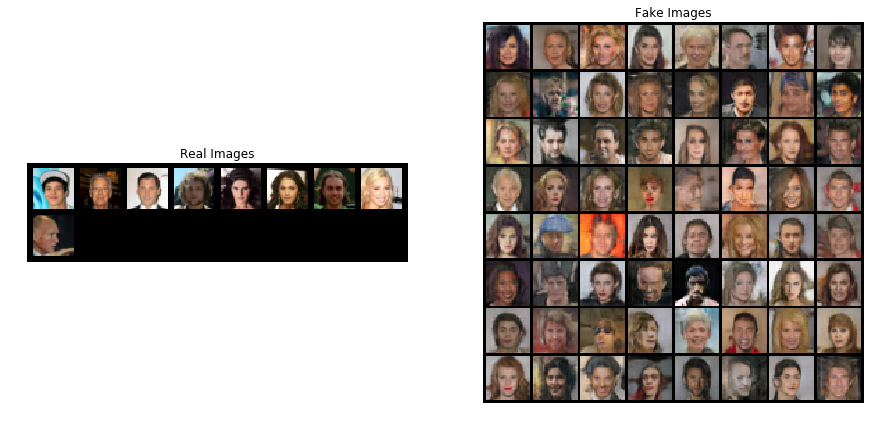

[3/5][0/22511]	Loss_D: 1.2968	Loss_G: 1.4502	D(x): 0.5627	D(G(z)): 0.8802 / 0.7570
[3/5][50/22511]	Loss_D: 1.2234	Loss_G: 2.2299	D(x): 0.5271	D(G(z)): 0.9380 / 0.8898
[3/5][100/22511]	Loss_D: 1.1441	Loss_G: 1.8168	D(x): 0.3572	D(G(z)): 0.9061 / 0.8341
[3/5][150/22511]	Loss_D: 0.9961	Loss_G: 2.0047	D(x): 0.1724	D(G(z)): 0.7202 / 0.8592
[3/5][200/22511]	Loss_D: 0.9861	Loss_G: 1.7576	D(x): 0.1959	D(G(z)): 0.7746 / 0.8202
[3/5][250/22511]	Loss_D: 0.9466	Loss_G: 1.8033	D(x): 0.2070	D(G(z)): 0.6298 / 0.8253
[3/5][300/22511]	Loss_D: 1.0957	Loss_G: 1.9793	D(x): 0.3895	D(G(z)): 0.9095 / 0.8504
[3/5][350/22511]	Loss_D: 0.9758	Loss_G: 1.4656	D(x): 0.1920	D(G(z)): 0.7625 / 0.7655
[3/5][400/22511]	Loss_D: 0.9884	Loss_G: 1.7765	D(x): 0.2106	D(G(z)): 0.7620 / 0.8256
[3/5][450/22511]	Loss_D: 0.9070	Loss_G: 1.8604	D(x): 0.2589	D(G(z)): 0.8607 / 0.8420
[3/5][500/22511]	Loss_D: 1.1542	Loss_G: 2.0700	D(x): 0.0741	D(G(z)): 0.7043 / 0.8683
[3/5][550/22511]	Loss_D: 0.9912	Loss_G: 1.8495	D(x): 0.2031	D(G(z)):

[3/5][4800/22511]	Loss_D: 0.8599	Loss_G: 1.8130	D(x): 0.1738	D(G(z)): 0.8313 / 0.8336
[3/5][4850/22511]	Loss_D: 1.0037	Loss_G: 1.6629	D(x): 0.0839	D(G(z)): 0.7576 / 0.7998
[3/5][4900/22511]	Loss_D: 1.1085	Loss_G: 1.8672	D(x): 0.4556	D(G(z)): 0.9381 / 0.8378
[3/5][4950/22511]	Loss_D: 1.0359	Loss_G: 1.7073	D(x): 0.2528	D(G(z)): 0.6232 / 0.8083
[3/5][5000/22511]	Loss_D: 0.9876	Loss_G: 2.0567	D(x): 0.2080	D(G(z)): 0.6979 / 0.8660
[3/5][5050/22511]	Loss_D: 0.9274	Loss_G: 1.8064	D(x): 0.1064	D(G(z)): 0.7095 / 0.8327
[3/5][5100/22511]	Loss_D: 0.8590	Loss_G: 2.2029	D(x): 0.0984	D(G(z)): 0.7855 / 0.8846
[3/5][5150/22511]	Loss_D: 0.9021	Loss_G: 1.9793	D(x): 0.2561	D(G(z)): 0.6935 / 0.8571
[3/5][5200/22511]	Loss_D: 1.0613	Loss_G: 1.9881	D(x): 0.1207	D(G(z)): 0.6887 / 0.8596
[3/5][5250/22511]	Loss_D: 1.0526	Loss_G: 1.6326	D(x): 0.3875	D(G(z)): 0.8797 / 0.7953
[3/5][5300/22511]	Loss_D: 0.8474	Loss_G: 1.8765	D(x): 0.2946	D(G(z)): 0.8691 / 0.8304
[3/5][5350/22511]	Loss_D: 1.0474	Loss_G: 1.7924	D(x): 

[3/5][9600/22511]	Loss_D: 1.7444	Loss_G: 2.3361	D(x): 0.0684	D(G(z)): 0.2287 / 0.8961
[3/5][9650/22511]	Loss_D: 0.9516	Loss_G: 1.7666	D(x): 0.1794	D(G(z)): 0.8130 / 0.8279
[3/5][9700/22511]	Loss_D: 0.9986	Loss_G: 1.6405	D(x): 0.2176	D(G(z)): 0.6953 / 0.8007
[3/5][9750/22511]	Loss_D: 1.0443	Loss_G: 1.6485	D(x): 0.4118	D(G(z)): 0.7272 / 0.8065
[3/5][9800/22511]	Loss_D: 1.0474	Loss_G: 1.9872	D(x): 0.0822	D(G(z)): 0.8348 / 0.8545
[3/5][9850/22511]	Loss_D: 0.9240	Loss_G: 2.0663	D(x): 0.0939	D(G(z)): 0.7327 / 0.8705
[3/5][9900/22511]	Loss_D: 1.1407	Loss_G: 1.5034	D(x): 0.4587	D(G(z)): 0.7108 / 0.7753
[3/5][9950/22511]	Loss_D: 0.9367	Loss_G: 1.9480	D(x): 0.2403	D(G(z)): 0.8814 / 0.8510
[3/5][10000/22511]	Loss_D: 0.9326	Loss_G: 2.1585	D(x): 0.0809	D(G(z)): 0.9036 / 0.8748
[3/5][10050/22511]	Loss_D: 1.0270	Loss_G: 1.6234	D(x): 0.4345	D(G(z)): 0.8584 / 0.7958
[3/5][10100/22511]	Loss_D: 0.9811	Loss_G: 1.7025	D(x): 0.0935	D(G(z)): 0.8808 / 0.8113
[3/5][10150/22511]	Loss_D: 0.9957	Loss_G: 1.9417	D(

[3/5][14350/22511]	Loss_D: 0.9670	Loss_G: 2.1699	D(x): 0.0876	D(G(z)): 0.6587 / 0.8773
[3/5][14400/22511]	Loss_D: 0.9528	Loss_G: 2.0662	D(x): 0.1030	D(G(z)): 0.6108 / 0.8667
[3/5][14450/22511]	Loss_D: 0.8392	Loss_G: 2.0691	D(x): 0.0880	D(G(z)): 0.6358 / 0.8707
[3/5][14500/22511]	Loss_D: 1.1488	Loss_G: 1.6651	D(x): 0.3514	D(G(z)): 0.9106 / 0.7987
[3/5][14550/22511]	Loss_D: 1.2107	Loss_G: 1.6213	D(x): 0.4396	D(G(z)): 0.8823 / 0.7975
[3/5][14600/22511]	Loss_D: 0.9984	Loss_G: 1.8386	D(x): 0.2266	D(G(z)): 0.8725 / 0.8361
[3/5][14650/22511]	Loss_D: 0.9881	Loss_G: 2.4937	D(x): 0.2583	D(G(z)): 0.6531 / 0.9158
[3/5][14700/22511]	Loss_D: 0.8663	Loss_G: 2.1228	D(x): 0.2089	D(G(z)): 0.7518 / 0.8770
[3/5][14750/22511]	Loss_D: 0.9823	Loss_G: 1.7926	D(x): 0.3432	D(G(z)): 0.6962 / 0.8236
[3/5][14800/22511]	Loss_D: 0.8753	Loss_G: 1.6177	D(x): 0.2637	D(G(z)): 0.7048 / 0.7987
[3/5][14850/22511]	Loss_D: 0.8628	Loss_G: 1.6781	D(x): 0.1277	D(G(z)): 0.8461 / 0.8081
[3/5][14900/22511]	Loss_D: 0.9509	Loss_G: 2

[3/5][19100/22511]	Loss_D: 1.0334	Loss_G: 1.7893	D(x): 0.2287	D(G(z)): 0.7663 / 0.8273
[3/5][19150/22511]	Loss_D: 0.9569	Loss_G: 1.8027	D(x): 0.2605	D(G(z)): 0.7725 / 0.8242
[3/5][19200/22511]	Loss_D: 1.0312	Loss_G: 2.0088	D(x): 0.1189	D(G(z)): 0.6506 / 0.8654
[3/5][19250/22511]	Loss_D: 1.3500	Loss_G: 2.0782	D(x): 0.6157	D(G(z)): 0.9077 / 0.8714
[3/5][19300/22511]	Loss_D: 1.0076	Loss_G: 2.0439	D(x): 0.1585	D(G(z)): 0.6648 / 0.8687
[3/5][19350/22511]	Loss_D: 0.8978	Loss_G: 1.8128	D(x): 0.0921	D(G(z)): 0.8559 / 0.8268
[3/5][19400/22511]	Loss_D: 0.8843	Loss_G: 1.9421	D(x): 0.3816	D(G(z)): 0.8382 / 0.8481
[3/5][19450/22511]	Loss_D: 0.9012	Loss_G: 2.0727	D(x): 0.1012	D(G(z)): 0.7023 / 0.8710
[3/5][19500/22511]	Loss_D: 0.9820	Loss_G: 2.0290	D(x): 0.3089	D(G(z)): 0.8859 / 0.8613
[3/5][19550/22511]	Loss_D: 0.8651	Loss_G: 2.1164	D(x): 0.1341	D(G(z)): 0.7813 / 0.8713
[3/5][19600/22511]	Loss_D: 1.0243	Loss_G: 1.8456	D(x): 0.3468	D(G(z)): 0.9144 / 0.8348
[3/5][19650/22511]	Loss_D: 1.0167	Loss_G: 1

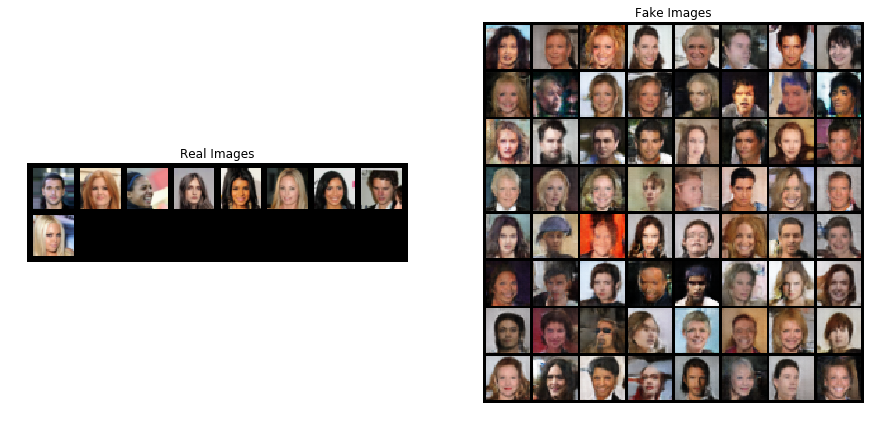

[4/5][0/22511]	Loss_D: 0.9618	Loss_G: 1.9201	D(x): 0.3334	D(G(z)): 0.8906 / 0.8435
[4/5][50/22511]	Loss_D: 0.8854	Loss_G: 1.9997	D(x): 0.1945	D(G(z)): 0.8454 / 0.8597
[4/5][100/22511]	Loss_D: 1.0391	Loss_G: 1.9803	D(x): 0.0962	D(G(z)): 0.5750 / 0.8596
[4/5][150/22511]	Loss_D: 0.9433	Loss_G: 1.6332	D(x): 0.2850	D(G(z)): 0.7585 / 0.7983
[4/5][200/22511]	Loss_D: 0.9649	Loss_G: 1.9475	D(x): 0.0852	D(G(z)): 0.7606 / 0.8516
[4/5][250/22511]	Loss_D: 0.9574	Loss_G: 1.3858	D(x): 0.2172	D(G(z)): 0.7442 / 0.7420
[4/5][300/22511]	Loss_D: 0.8542	Loss_G: 1.7725	D(x): 0.0995	D(G(z)): 0.7722 / 0.8267
[4/5][350/22511]	Loss_D: 0.9831	Loss_G: 1.5806	D(x): 0.2653	D(G(z)): 0.6859 / 0.7875
[4/5][400/22511]	Loss_D: 1.0070	Loss_G: 1.5910	D(x): 0.1727	D(G(z)): 0.6891 / 0.7911
[4/5][450/22511]	Loss_D: 0.7951	Loss_G: 2.3223	D(x): 0.1369	D(G(z)): 0.8121 / 0.8976
[4/5][500/22511]	Loss_D: 0.9766	Loss_G: 2.1154	D(x): 0.4248	D(G(z)): 0.9294 / 0.8736
[4/5][550/22511]	Loss_D: 0.8014	Loss_G: 2.1144	D(x): 0.2044	D(G(z)):

[4/5][4800/22511]	Loss_D: 0.9000	Loss_G: 1.8844	D(x): 0.2497	D(G(z)): 0.9055 / 0.8441
[4/5][4850/22511]	Loss_D: 1.0456	Loss_G: 1.8709	D(x): 0.0663	D(G(z)): 0.8637 / 0.8414
[4/5][4900/22511]	Loss_D: 0.8750	Loss_G: 1.8503	D(x): 0.2328	D(G(z)): 0.8376 / 0.8349
[4/5][4950/22511]	Loss_D: 0.9423	Loss_G: 2.5416	D(x): 0.2312	D(G(z)): 0.7406 / 0.9192
[4/5][5000/22511]	Loss_D: 0.8474	Loss_G: 2.1719	D(x): 0.1355	D(G(z)): 0.8336 / 0.8811
[4/5][5050/22511]	Loss_D: 1.3773	Loss_G: 1.1570	D(x): 0.6152	D(G(z)): 0.8081 / 0.6794
[4/5][5100/22511]	Loss_D: 0.8367	Loss_G: 2.2006	D(x): 0.1667	D(G(z)): 0.9103 / 0.8847
[4/5][5150/22511]	Loss_D: 0.8181	Loss_G: 1.8765	D(x): 0.2219	D(G(z)): 0.7890 / 0.8425
[4/5][5200/22511]	Loss_D: 1.0091	Loss_G: 1.3809	D(x): 0.2838	D(G(z)): 0.7929 / 0.7467
[4/5][5250/22511]	Loss_D: 1.1581	Loss_G: 2.5217	D(x): 0.1619	D(G(z)): 0.5149 / 0.9177
[4/5][5300/22511]	Loss_D: 0.8814	Loss_G: 2.1389	D(x): 0.2334	D(G(z)): 0.8736 / 0.8782
[4/5][5350/22511]	Loss_D: 1.0050	Loss_G: 2.2499	D(x): 

[4/5][9600/22511]	Loss_D: 0.8812	Loss_G: 2.2730	D(x): 0.2088	D(G(z)): 0.7378 / 0.8924
[4/5][9650/22511]	Loss_D: 0.9286	Loss_G: 1.9779	D(x): 0.1233	D(G(z)): 0.8032 / 0.8508
[4/5][9700/22511]	Loss_D: 0.7628	Loss_G: 2.0074	D(x): 0.2182	D(G(z)): 0.9034 / 0.8581
[4/5][9750/22511]	Loss_D: 0.7954	Loss_G: 2.5174	D(x): 0.1054	D(G(z)): 0.8822 / 0.9135
[4/5][9800/22511]	Loss_D: 0.8163	Loss_G: 2.3232	D(x): 0.2244	D(G(z)): 0.8681 / 0.8996
[4/5][9850/22511]	Loss_D: 1.1615	Loss_G: 1.6043	D(x): 0.4700	D(G(z)): 0.6961 / 0.7960
[4/5][9900/22511]	Loss_D: 0.8583	Loss_G: 1.8565	D(x): 0.1918	D(G(z)): 0.8947 / 0.8368
[4/5][9950/22511]	Loss_D: 0.9447	Loss_G: 1.9039	D(x): 0.2681	D(G(z)): 0.8115 / 0.8429
[4/5][10000/22511]	Loss_D: 0.9291	Loss_G: 1.6528	D(x): 0.1499	D(G(z)): 0.8453 / 0.8024
[4/5][10050/22511]	Loss_D: 1.0724	Loss_G: 2.0874	D(x): 0.0866	D(G(z)): 0.6720 / 0.8723
[4/5][10100/22511]	Loss_D: 0.9164	Loss_G: 1.9888	D(x): 0.0500	D(G(z)): 0.7798 / 0.8607
[4/5][10150/22511]	Loss_D: 0.8840	Loss_G: 2.0348	D(

[4/5][14350/22511]	Loss_D: 0.8861	Loss_G: 2.1324	D(x): 0.1849	D(G(z)): 0.8041 / 0.8748
[4/5][14400/22511]	Loss_D: 1.0536	Loss_G: 1.6511	D(x): 0.1684	D(G(z)): 0.8584 / 0.8042
[4/5][14450/22511]	Loss_D: 0.8048	Loss_G: 2.0184	D(x): 0.0861	D(G(z)): 0.8463 / 0.8641
[4/5][14500/22511]	Loss_D: 0.8880	Loss_G: 2.2068	D(x): 0.2890	D(G(z)): 0.8883 / 0.8840
[4/5][14550/22511]	Loss_D: 0.9282	Loss_G: 2.7277	D(x): 0.0624	D(G(z)): 0.7399 / 0.9273
[4/5][14600/22511]	Loss_D: 0.8821	Loss_G: 2.3341	D(x): 0.1161	D(G(z)): 0.8377 / 0.8989
[4/5][14650/22511]	Loss_D: 1.0094	Loss_G: 1.7252	D(x): 0.3188	D(G(z)): 0.7572 / 0.8163
[4/5][14700/22511]	Loss_D: 0.7556	Loss_G: 2.3561	D(x): 0.1519	D(G(z)): 0.7607 / 0.9039
[4/5][14750/22511]	Loss_D: 1.0723	Loss_G: 2.1900	D(x): 0.1787	D(G(z)): 0.5639 / 0.8832
[4/5][14800/22511]	Loss_D: 0.8883	Loss_G: 2.0227	D(x): 0.2071	D(G(z)): 0.8897 / 0.8654
[4/5][14850/22511]	Loss_D: 1.0473	Loss_G: 1.6531	D(x): 0.3404	D(G(z)): 0.7261 / 0.8030
[4/5][14900/22511]	Loss_D: 1.2755	Loss_G: 2

[4/5][19100/22511]	Loss_D: 1.2003	Loss_G: 1.8580	D(x): 0.0288	D(G(z)): 0.6277 / 0.8400
[4/5][19150/22511]	Loss_D: 0.9052	Loss_G: 1.8669	D(x): 0.2294	D(G(z)): 0.7597 / 0.8403
[4/5][19200/22511]	Loss_D: 0.9441	Loss_G: 1.7553	D(x): 0.0899	D(G(z)): 0.8067 / 0.8133
[4/5][19250/22511]	Loss_D: 0.9163	Loss_G: 1.8729	D(x): 0.1041	D(G(z)): 0.6960 / 0.8426
[4/5][19300/22511]	Loss_D: 0.9346	Loss_G: 1.7903	D(x): 0.1773	D(G(z)): 0.8628 / 0.8287
[4/5][19350/22511]	Loss_D: 1.2374	Loss_G: 1.7088	D(x): 0.4695	D(G(z)): 0.6314 / 0.8111
[4/5][19400/22511]	Loss_D: 0.9603	Loss_G: 2.0004	D(x): 0.2641	D(G(z)): 0.7873 / 0.8557
[4/5][19450/22511]	Loss_D: 1.0299	Loss_G: 2.1324	D(x): 0.0778	D(G(z)): 0.6940 / 0.8744
[4/5][19500/22511]	Loss_D: 0.8692	Loss_G: 1.7995	D(x): 0.1303	D(G(z)): 0.6695 / 0.8279
[4/5][19550/22511]	Loss_D: 0.8783	Loss_G: 1.8165	D(x): 0.1833	D(G(z)): 0.7587 / 0.8332
[4/5][19600/22511]	Loss_D: 0.9362	Loss_G: 1.8962	D(x): 0.1307	D(G(z)): 0.7932 / 0.8465
[4/5][19650/22511]	Loss_D: 0.8291	Loss_G: 1

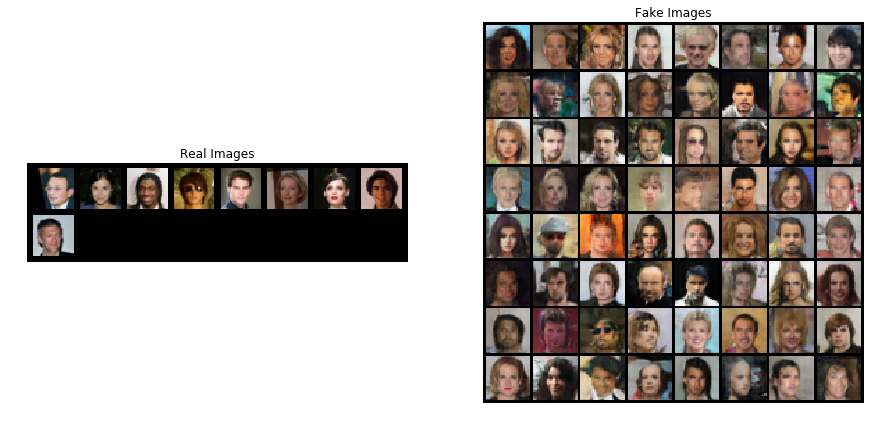

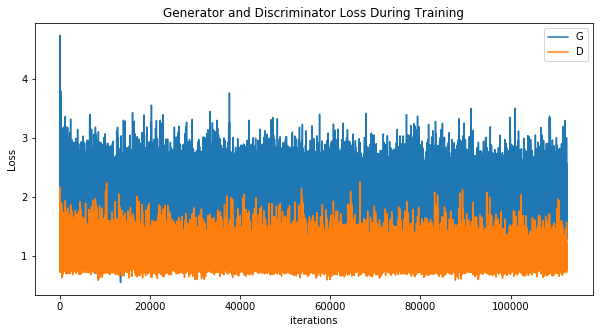

[0/5][0/22511]	Loss_D: 0.9406	Loss_G: 2.0971	D(x): 0.4093	D(G(z)): 0.8918 / 0.8710
[0/5][50/22511]	Loss_D: 1.1315	Loss_G: 1.9650	D(x): 0.2850	D(G(z)): 0.5772 / 0.8590
[0/5][100/22511]	Loss_D: 0.8611	Loss_G: 2.1619	D(x): 0.1435	D(G(z)): 0.9020 / 0.8818
[0/5][150/22511]	Loss_D: 0.8465	Loss_G: 1.9849	D(x): 0.1328	D(G(z)): 0.7825 / 0.8592
[0/5][200/22511]	Loss_D: 0.8785	Loss_G: 1.6847	D(x): 0.1728	D(G(z)): 0.8543 / 0.8098
[0/5][250/22511]	Loss_D: 0.7521	Loss_G: 2.3095	D(x): 0.1637	D(G(z)): 0.8566 / 0.8928
[0/5][300/22511]	Loss_D: 0.7616	Loss_G: 1.9370	D(x): 0.1665	D(G(z)): 0.8232 / 0.8508
[0/5][350/22511]	Loss_D: 1.6450	Loss_G: 2.4075	D(x): 0.0664	D(G(z)): 0.3456 / 0.9040
[0/5][400/22511]	Loss_D: 0.9206	Loss_G: 2.2946	D(x): 0.3214	D(G(z)): 0.9057 / 0.8958
[0/5][450/22511]	Loss_D: 0.9443	Loss_G: 1.8947	D(x): 0.1537	D(G(z)): 0.7039 / 0.8428
[0/5][500/22511]	Loss_D: 0.8233	Loss_G: 1.9047	D(x): 0.1390	D(G(z)): 0.7789 / 0.8453
[0/5][550/22511]	Loss_D: 0.9747	Loss_G: 1.9721	D(x): 0.1106	D(G(z)):

[0/5][4800/22511]	Loss_D: 0.8642	Loss_G: 2.0240	D(x): 0.2895	D(G(z)): 0.8938 / 0.8603
[0/5][4850/22511]	Loss_D: 0.8760	Loss_G: 1.7160	D(x): 0.2227	D(G(z)): 0.7800 / 0.8110
[0/5][4900/22511]	Loss_D: 0.9208	Loss_G: 2.1516	D(x): 0.1311	D(G(z)): 0.7653 / 0.8791
[0/5][4950/22511]	Loss_D: 1.2850	Loss_G: 1.3355	D(x): 0.5585	D(G(z)): 0.7704 / 0.7310
[0/5][5000/22511]	Loss_D: 0.8870	Loss_G: 1.8113	D(x): 0.0651	D(G(z)): 0.7897 / 0.8281
[0/5][5050/22511]	Loss_D: 0.9510	Loss_G: 2.1899	D(x): 0.0914	D(G(z)): 0.7569 / 0.8863
[0/5][5100/22511]	Loss_D: 1.1411	Loss_G: 2.3497	D(x): 0.0880	D(G(z)): 0.5431 / 0.9002
[0/5][5150/22511]	Loss_D: 1.0113	Loss_G: 1.4101	D(x): 0.3558	D(G(z)): 0.7652 / 0.7511
[0/5][5200/22511]	Loss_D: 0.8538	Loss_G: 1.8575	D(x): 0.2600	D(G(z)): 0.7310 / 0.8353
[0/5][5250/22511]	Loss_D: 0.7091	Loss_G: 2.3628	D(x): 0.2000	D(G(z)): 0.9278 / 0.9036
[0/5][5300/22511]	Loss_D: 0.9745	Loss_G: 1.8048	D(x): 0.2749	D(G(z)): 0.7266 / 0.8288
[0/5][5350/22511]	Loss_D: 0.9491	Loss_G: 2.0264	D(x): 

[0/5][9600/22511]	Loss_D: 0.9680	Loss_G: 2.2357	D(x): 0.1024	D(G(z)): 0.8146 / 0.8890
[0/5][9650/22511]	Loss_D: 1.0267	Loss_G: 1.7434	D(x): 0.2735	D(G(z)): 0.9020 / 0.8173
[0/5][9700/22511]	Loss_D: 1.1304	Loss_G: 2.3017	D(x): 0.4515	D(G(z)): 0.9086 / 0.8941
[0/5][9750/22511]	Loss_D: 1.0876	Loss_G: 1.9282	D(x): 0.0573	D(G(z)): 0.8346 / 0.8449
[0/5][9800/22511]	Loss_D: 0.9873	Loss_G: 1.5758	D(x): 0.2786	D(G(z)): 0.7861 / 0.7892
[0/5][9850/22511]	Loss_D: 0.9795	Loss_G: 2.1464	D(x): 0.0640	D(G(z)): 0.7639 / 0.8812
[0/5][9900/22511]	Loss_D: 0.9134	Loss_G: 2.3292	D(x): 0.3267	D(G(z)): 0.9276 / 0.8969
[0/5][9950/22511]	Loss_D: 0.9814	Loss_G: 1.7476	D(x): 0.3577	D(G(z)): 0.8115 / 0.8179
[0/5][10000/22511]	Loss_D: 1.0677	Loss_G: 1.5322	D(x): 0.3437	D(G(z)): 0.7703 / 0.7783
[0/5][10050/22511]	Loss_D: 1.5008	Loss_G: 1.5374	D(x): 0.7116	D(G(z)): 0.8732 / 0.7798
[0/5][10100/22511]	Loss_D: 1.0534	Loss_G: 1.6862	D(x): 0.2668	D(G(z)): 0.7676 / 0.8081
[0/5][10150/22511]	Loss_D: 0.9813	Loss_G: 1.9118	D(

[0/5][14350/22511]	Loss_D: 0.9069	Loss_G: 2.0379	D(x): 0.1935	D(G(z)): 0.6912 / 0.8666
[0/5][14400/22511]	Loss_D: 0.8673	Loss_G: 2.0028	D(x): 0.0849	D(G(z)): 0.7478 / 0.8582
[0/5][14450/22511]	Loss_D: 0.6484	Loss_G: 2.4243	D(x): 0.1987	D(G(z)): 0.9038 / 0.9047
[0/5][14500/22511]	Loss_D: 0.8877	Loss_G: 1.7728	D(x): 0.2052	D(G(z)): 0.7005 / 0.8228
[0/5][14550/22511]	Loss_D: 0.9262	Loss_G: 1.8877	D(x): 0.1292	D(G(z)): 0.7579 / 0.8438
[0/5][14600/22511]	Loss_D: 0.9590	Loss_G: 1.8259	D(x): 0.2369	D(G(z)): 0.8433 / 0.8268
[0/5][14650/22511]	Loss_D: 1.0184	Loss_G: 1.9355	D(x): 0.3042	D(G(z)): 0.6641 / 0.8461
[0/5][14700/22511]	Loss_D: 1.0134	Loss_G: 1.5397	D(x): 0.3637	D(G(z)): 0.7877 / 0.7798
[0/5][14750/22511]	Loss_D: 0.9735	Loss_G: 1.4255	D(x): 0.3221	D(G(z)): 0.8373 / 0.7542
[0/5][14800/22511]	Loss_D: 0.8531	Loss_G: 1.7725	D(x): 0.2104	D(G(z)): 0.8499 / 0.8203
[0/5][14850/22511]	Loss_D: 0.9342	Loss_G: 2.1308	D(x): 0.1293	D(G(z)): 0.8339 / 0.8744
[0/5][14900/22511]	Loss_D: 0.9744	Loss_G: 1

[0/5][19100/22511]	Loss_D: 1.0084	Loss_G: 1.8130	D(x): 0.3103	D(G(z)): 0.7503 / 0.8346
[0/5][19150/22511]	Loss_D: 1.0408	Loss_G: 1.6903	D(x): 0.4291	D(G(z)): 0.8690 / 0.8069
[0/5][19200/22511]	Loss_D: 1.0890	Loss_G: 2.1315	D(x): 0.1844	D(G(z)): 0.5647 / 0.8785
[0/5][19250/22511]	Loss_D: 0.9442	Loss_G: 1.9400	D(x): 0.3403	D(G(z)): 0.7640 / 0.8497
[0/5][19300/22511]	Loss_D: 0.9083	Loss_G: 1.6740	D(x): 0.3220	D(G(z)): 0.8324 / 0.8081
[0/5][19350/22511]	Loss_D: 0.9473	Loss_G: 2.5104	D(x): 0.2165	D(G(z)): 0.9348 / 0.9122
[0/5][19400/22511]	Loss_D: 0.8284	Loss_G: 1.7008	D(x): 0.1737	D(G(z)): 0.7731 / 0.8135
[0/5][19450/22511]	Loss_D: 1.0459	Loss_G: 2.1373	D(x): 0.2090	D(G(z)): 0.6680 / 0.8807
[0/5][19500/22511]	Loss_D: 0.8486	Loss_G: 1.8796	D(x): 0.2101	D(G(z)): 0.8705 / 0.8376
[0/5][19550/22511]	Loss_D: 0.9940	Loss_G: 2.1868	D(x): 0.0922	D(G(z)): 0.6875 / 0.8863
[0/5][19600/22511]	Loss_D: 0.9106	Loss_G: 2.1120	D(x): 0.1894	D(G(z)): 0.9183 / 0.8702
[0/5][19650/22511]	Loss_D: 1.0128	Loss_G: 1

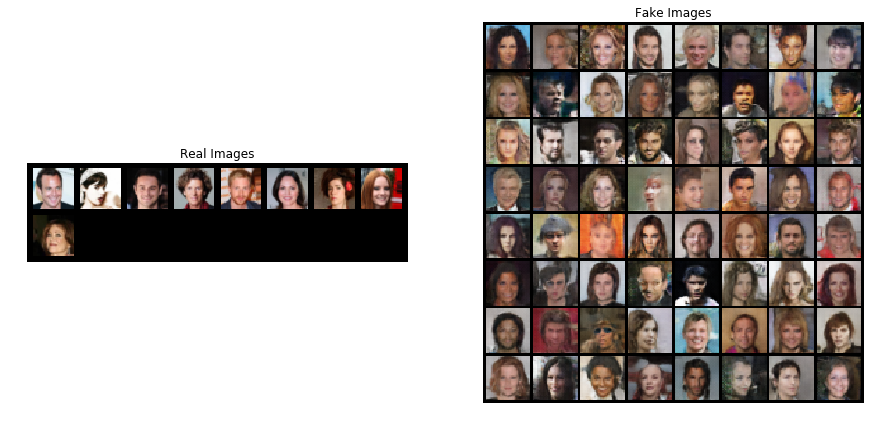

[1/5][0/22511]	Loss_D: 1.0843	Loss_G: 1.9253	D(x): 0.1248	D(G(z)): 0.4860 / 0.8466
[1/5][50/22511]	Loss_D: 0.8781	Loss_G: 1.7286	D(x): 0.1985	D(G(z)): 0.8238 / 0.8197
[1/5][100/22511]	Loss_D: 1.0091	Loss_G: 1.7030	D(x): 0.3154	D(G(z)): 0.7048 / 0.8136
[1/5][150/22511]	Loss_D: 0.8033	Loss_G: 2.0453	D(x): 0.0663	D(G(z)): 0.7721 / 0.8615
[1/5][200/22511]	Loss_D: 0.8654	Loss_G: 1.8700	D(x): 0.1611	D(G(z)): 0.7344 / 0.8415
[1/5][250/22511]	Loss_D: 0.9148	Loss_G: 1.9281	D(x): 0.0680	D(G(z)): 0.8073 / 0.8455
[1/5][300/22511]	Loss_D: 0.9530	Loss_G: 1.8614	D(x): 0.1936	D(G(z)): 0.7886 / 0.8383
[1/5][350/22511]	Loss_D: 0.8583	Loss_G: 1.6452	D(x): 0.1232	D(G(z)): 0.7062 / 0.8028
[1/5][400/22511]	Loss_D: 0.8290	Loss_G: 1.9367	D(x): 0.1268	D(G(z)): 0.8153 / 0.8511
[1/5][450/22511]	Loss_D: 0.9771	Loss_G: 1.5404	D(x): 0.1685	D(G(z)): 0.8388 / 0.7839
[1/5][500/22511]	Loss_D: 0.8607	Loss_G: 1.9647	D(x): 0.1650	D(G(z)): 0.7825 / 0.8536
[1/5][550/22511]	Loss_D: 0.8145	Loss_G: 2.0333	D(x): 0.1057	D(G(z)):

[1/5][4800/22511]	Loss_D: 0.8924	Loss_G: 1.8123	D(x): 0.0454	D(G(z)): 0.7340 / 0.8330
[1/5][4850/22511]	Loss_D: 0.9286	Loss_G: 1.7825	D(x): 0.1080	D(G(z)): 0.8059 / 0.8301
[1/5][4900/22511]	Loss_D: 1.0333	Loss_G: 1.8761	D(x): 0.3084	D(G(z)): 0.9161 / 0.8336
[1/5][4950/22511]	Loss_D: 0.9356	Loss_G: 1.7059	D(x): 0.1212	D(G(z)): 0.7840 / 0.8108
[1/5][5000/22511]	Loss_D: 0.9257	Loss_G: 1.6334	D(x): 0.2093	D(G(z)): 0.7716 / 0.7997
[1/5][5050/22511]	Loss_D: 0.9532	Loss_G: 1.8870	D(x): 0.0583	D(G(z)): 0.7943 / 0.8442
[1/5][5100/22511]	Loss_D: 1.1633	Loss_G: 1.3696	D(x): 0.5090	D(G(z)): 0.8189 / 0.7318
[1/5][5150/22511]	Loss_D: 0.9037	Loss_G: 2.1272	D(x): 0.1793	D(G(z)): 0.9226 / 0.8788
[1/5][5200/22511]	Loss_D: 0.9111	Loss_G: 1.4659	D(x): 0.1973	D(G(z)): 0.7850 / 0.7639
[1/5][5250/22511]	Loss_D: 0.8677	Loss_G: 1.7604	D(x): 0.2572	D(G(z)): 0.7857 / 0.8230
[1/5][5300/22511]	Loss_D: 0.8754	Loss_G: 1.7617	D(x): 0.1822	D(G(z)): 0.8582 / 0.8196
[1/5][5350/22511]	Loss_D: 0.9351	Loss_G: 1.5731	D(x): 

[1/5][9600/22511]	Loss_D: 0.9144	Loss_G: 2.0004	D(x): 0.2180	D(G(z)): 0.7135 / 0.8587
[1/5][9650/22511]	Loss_D: 0.9684	Loss_G: 1.9085	D(x): 0.1101	D(G(z)): 0.8839 / 0.8488
[1/5][9700/22511]	Loss_D: 1.0315	Loss_G: 1.7858	D(x): 0.3387	D(G(z)): 0.8258 / 0.8301
[1/5][9750/22511]	Loss_D: 1.2322	Loss_G: 1.4249	D(x): 0.4865	D(G(z)): 0.6503 / 0.7552
[1/5][9800/22511]	Loss_D: 0.8699	Loss_G: 1.9428	D(x): 0.1688	D(G(z)): 0.7947 / 0.8503
[1/5][9850/22511]	Loss_D: 0.9948	Loss_G: 1.7890	D(x): 0.3570	D(G(z)): 0.8443 / 0.8217
[1/5][9900/22511]	Loss_D: 1.3500	Loss_G: 1.5507	D(x): 0.6206	D(G(z)): 0.8196 / 0.7772
[1/5][9950/22511]	Loss_D: 0.9874	Loss_G: 1.6120	D(x): 0.3189	D(G(z)): 0.7942 / 0.7875
[1/5][10000/22511]	Loss_D: 1.0803	Loss_G: 2.3528	D(x): 0.1301	D(G(z)): 0.6037 / 0.9006
[1/5][10050/22511]	Loss_D: 1.0039	Loss_G: 1.8021	D(x): 0.1434	D(G(z)): 0.6972 / 0.8308
[1/5][10100/22511]	Loss_D: 0.8083	Loss_G: 2.0860	D(x): 0.1448	D(G(z)): 0.8801 / 0.8684
[1/5][10150/22511]	Loss_D: 1.0565	Loss_G: 1.7875	D(

[1/5][14350/22511]	Loss_D: 1.0774	Loss_G: 1.7118	D(x): 0.4751	D(G(z)): 0.8602 / 0.8137
[1/5][14400/22511]	Loss_D: 0.8556	Loss_G: 2.1864	D(x): 0.2036	D(G(z)): 0.8990 / 0.8814
[1/5][14450/22511]	Loss_D: 0.9927	Loss_G: 1.7789	D(x): 0.3212	D(G(z)): 0.8116 / 0.8298
[1/5][14500/22511]	Loss_D: 0.8076	Loss_G: 1.9984	D(x): 0.1960	D(G(z)): 0.7783 / 0.8578
[1/5][14550/22511]	Loss_D: 0.9077	Loss_G: 1.7121	D(x): 0.2542	D(G(z)): 0.7988 / 0.8075
[1/5][14600/22511]	Loss_D: 1.0585	Loss_G: 1.6592	D(x): 0.1281	D(G(z)): 0.8636 / 0.8008
[1/5][14650/22511]	Loss_D: 1.0657	Loss_G: 1.6509	D(x): 0.3620	D(G(z)): 0.8018 / 0.8053
[1/5][14700/22511]	Loss_D: 0.7760	Loss_G: 1.8246	D(x): 0.1465	D(G(z)): 0.8238 / 0.8330
[1/5][14750/22511]	Loss_D: 1.0979	Loss_G: 1.8609	D(x): 0.1080	D(G(z)): 0.6076 / 0.8421
[1/5][14800/22511]	Loss_D: 0.9162	Loss_G: 1.8782	D(x): 0.3316	D(G(z)): 0.8667 / 0.8326
[1/5][14850/22511]	Loss_D: 0.9264	Loss_G: 2.1804	D(x): 0.1831	D(G(z)): 0.6778 / 0.8788
[1/5][14900/22511]	Loss_D: 1.3176	Loss_G: 1

[1/5][19100/22511]	Loss_D: 0.7547	Loss_G: 1.7766	D(x): 0.1191	D(G(z)): 0.7663 / 0.8245
[1/5][19150/22511]	Loss_D: 0.8772	Loss_G: 1.9537	D(x): 0.1443	D(G(z)): 0.7979 / 0.8553
[1/5][19200/22511]	Loss_D: 0.8231	Loss_G: 1.8652	D(x): 0.1858	D(G(z)): 0.7916 / 0.8404
[1/5][19250/22511]	Loss_D: 1.0490	Loss_G: 1.9247	D(x): 0.0455	D(G(z)): 0.8589 / 0.8485
[1/5][19300/22511]	Loss_D: 0.8622	Loss_G: 1.9751	D(x): 0.1253	D(G(z)): 0.7397 / 0.8514
[1/5][19350/22511]	Loss_D: 0.8303	Loss_G: 2.0103	D(x): 0.1959	D(G(z)): 0.8673 / 0.8591
[1/5][19400/22511]	Loss_D: 0.9493	Loss_G: 1.7144	D(x): 0.3998	D(G(z)): 0.8205 / 0.8161
[1/5][19450/22511]	Loss_D: 1.1349	Loss_G: 2.1356	D(x): 0.0748	D(G(z)): 0.5353 / 0.8778
[1/5][19500/22511]	Loss_D: 0.9386	Loss_G: 1.8205	D(x): 0.2990	D(G(z)): 0.8583 / 0.8254
[1/5][19550/22511]	Loss_D: 0.9286	Loss_G: 1.9826	D(x): 0.1133	D(G(z)): 0.8078 / 0.8577
[1/5][19600/22511]	Loss_D: 0.9768	Loss_G: 1.6108	D(x): 0.3907	D(G(z)): 0.8688 / 0.7897
[1/5][19650/22511]	Loss_D: 0.8629	Loss_G: 1

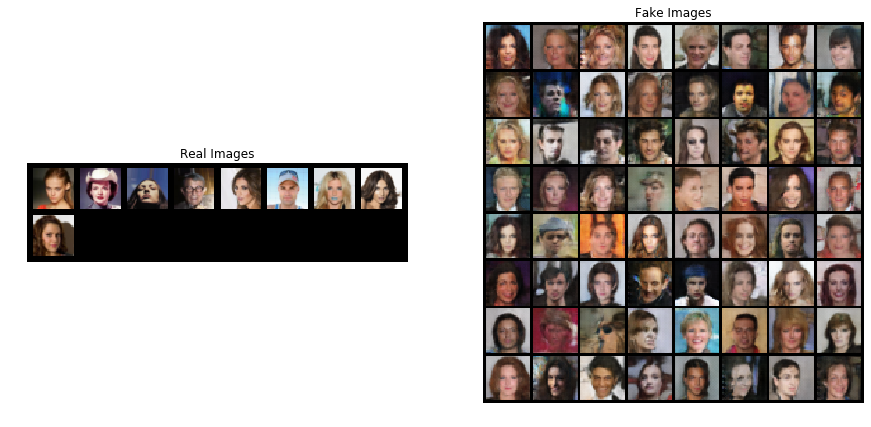

[2/5][0/22511]	Loss_D: 0.8821	Loss_G: 2.1074	D(x): 0.1757	D(G(z)): 0.8665 / 0.8707
[2/5][50/22511]	Loss_D: 0.7713	Loss_G: 2.1312	D(x): 0.0491	D(G(z)): 0.7037 / 0.8742
[2/5][100/22511]	Loss_D: 0.7953	Loss_G: 2.1921	D(x): 0.2736	D(G(z)): 0.8596 / 0.8829
[2/5][150/22511]	Loss_D: 0.8164	Loss_G: 1.7235	D(x): 0.2216	D(G(z)): 0.7931 / 0.8144
[2/5][200/22511]	Loss_D: 1.1790	Loss_G: 1.4029	D(x): 0.5449	D(G(z)): 0.8105 / 0.7484
[2/5][250/22511]	Loss_D: 1.1318	Loss_G: 1.7051	D(x): 0.5185	D(G(z)): 0.8428 / 0.8153
[2/5][300/22511]	Loss_D: 0.9320	Loss_G: 1.8756	D(x): 0.2406	D(G(z)): 0.6949 / 0.8430
[2/5][350/22511]	Loss_D: 1.1661	Loss_G: 2.5484	D(x): 0.1573	D(G(z)): 0.5239 / 0.9146
[2/5][400/22511]	Loss_D: 1.1304	Loss_G: 1.9757	D(x): 0.4517	D(G(z)): 0.8951 / 0.8422
[2/5][450/22511]	Loss_D: 0.9145	Loss_G: 1.6218	D(x): 0.2192	D(G(z)): 0.6954 / 0.7951
[2/5][500/22511]	Loss_D: 0.7896	Loss_G: 2.2538	D(x): 0.1293	D(G(z)): 0.9090 / 0.8918
[2/5][550/22511]	Loss_D: 0.8724	Loss_G: 1.7271	D(x): 0.2810	D(G(z)):

[2/5][4800/22511]	Loss_D: 0.7509	Loss_G: 2.2439	D(x): 0.0188	D(G(z)): 0.8587 / 0.8818
[2/5][4850/22511]	Loss_D: 1.0136	Loss_G: 2.2940	D(x): 0.1606	D(G(z)): 0.6239 / 0.8927
[2/5][4900/22511]	Loss_D: 0.8217	Loss_G: 2.4858	D(x): 0.1903	D(G(z)): 0.7775 / 0.9139
[2/5][4950/22511]	Loss_D: 0.9306	Loss_G: 1.8777	D(x): 0.1618	D(G(z)): 0.7287 / 0.8366
[2/5][5000/22511]	Loss_D: 0.9892	Loss_G: 1.8139	D(x): 0.2270	D(G(z)): 0.6901 / 0.8345
[2/5][5050/22511]	Loss_D: 1.0784	Loss_G: 1.4058	D(x): 0.3229	D(G(z)): 0.6697 / 0.7518
[2/5][5100/22511]	Loss_D: 0.9819	Loss_G: 1.3620	D(x): 0.1660	D(G(z)): 0.6483 / 0.7393
[2/5][5150/22511]	Loss_D: 1.4774	Loss_G: 1.3291	D(x): 0.6392	D(G(z)): 0.7184 / 0.7262
[2/5][5200/22511]	Loss_D: 1.0239	Loss_G: 2.0224	D(x): 0.1116	D(G(z)): 0.8442 / 0.8593
[2/5][5250/22511]	Loss_D: 1.0124	Loss_G: 2.2188	D(x): 0.0990	D(G(z)): 0.6521 / 0.8832
[2/5][5300/22511]	Loss_D: 1.0475	Loss_G: 2.4023	D(x): 0.1873	D(G(z)): 0.5641 / 0.9086
[2/5][5350/22511]	Loss_D: 0.8241	Loss_G: 2.2783	D(x): 

[2/5][9600/22511]	Loss_D: 0.9334	Loss_G: 2.0212	D(x): 0.3609	D(G(z)): 0.9215 / 0.8638
[2/5][9650/22511]	Loss_D: 0.9915	Loss_G: 1.8698	D(x): 0.3993	D(G(z)): 0.9066 / 0.8370
[2/5][9700/22511]	Loss_D: 1.2528	Loss_G: 1.7711	D(x): 0.0527	D(G(z)): 0.4888 / 0.8224
[2/5][9750/22511]	Loss_D: 0.8945	Loss_G: 2.1497	D(x): 0.2429	D(G(z)): 0.8674 / 0.8806
[2/5][9800/22511]	Loss_D: 0.9973	Loss_G: 1.9629	D(x): 0.3874	D(G(z)): 0.9172 / 0.8513
[2/5][9850/22511]	Loss_D: 0.8775	Loss_G: 2.0795	D(x): 0.0474	D(G(z)): 0.7562 / 0.8701
[2/5][9900/22511]	Loss_D: 1.0345	Loss_G: 1.7169	D(x): 0.2567	D(G(z)): 0.8057 / 0.8132
[2/5][9950/22511]	Loss_D: 1.0332	Loss_G: 2.0029	D(x): 0.3270	D(G(z)): 0.6240 / 0.8618
[2/5][10000/22511]	Loss_D: 0.8186	Loss_G: 2.2693	D(x): 0.0939	D(G(z)): 0.8773 / 0.8915
[2/5][10050/22511]	Loss_D: 0.9542	Loss_G: 1.9067	D(x): 0.2333	D(G(z)): 0.7044 / 0.8459
[2/5][10100/22511]	Loss_D: 0.8741	Loss_G: 1.7465	D(x): 0.3365	D(G(z)): 0.8459 / 0.8115
[2/5][10150/22511]	Loss_D: 0.8142	Loss_G: 2.3099	D(

[2/5][14350/22511]	Loss_D: 1.0267	Loss_G: 1.5000	D(x): 0.4075	D(G(z)): 0.8437 / 0.7672
[2/5][14400/22511]	Loss_D: 1.0140	Loss_G: 1.5359	D(x): 0.3837	D(G(z)): 0.8718 / 0.7786
[2/5][14450/22511]	Loss_D: 0.9224	Loss_G: 1.6930	D(x): 0.2958	D(G(z)): 0.7858 / 0.8079
[2/5][14500/22511]	Loss_D: 0.9853	Loss_G: 1.9010	D(x): 0.1572	D(G(z)): 0.6880 / 0.8477
[2/5][14550/22511]	Loss_D: 0.8879	Loss_G: 1.7577	D(x): 0.2307	D(G(z)): 0.8458 / 0.8266
[2/5][14600/22511]	Loss_D: 0.9545	Loss_G: 2.2293	D(x): 0.3055	D(G(z)): 0.7052 / 0.8887
[2/5][14650/22511]	Loss_D: 0.9673	Loss_G: 1.6729	D(x): 0.1692	D(G(z)): 0.8051 / 0.8061
[2/5][14700/22511]	Loss_D: 0.9380	Loss_G: 2.0661	D(x): 0.1769	D(G(z)): 0.8300 / 0.8674
[2/5][14750/22511]	Loss_D: 0.9995	Loss_G: 2.2981	D(x): 0.1033	D(G(z)): 0.7030 / 0.8966
[2/5][14800/22511]	Loss_D: 1.0312	Loss_G: 1.7974	D(x): 0.3604	D(G(z)): 0.8302 / 0.8253
[2/5][14850/22511]	Loss_D: 1.1140	Loss_G: 2.4956	D(x): 0.1590	D(G(z)): 0.4782 / 0.9138
[2/5][14900/22511]	Loss_D: 0.9185	Loss_G: 1

[2/5][19100/22511]	Loss_D: 1.2396	Loss_G: 1.4862	D(x): 0.4858	D(G(z)): 0.6817 / 0.7695
[2/5][19150/22511]	Loss_D: 1.0819	Loss_G: 1.5575	D(x): 0.3645	D(G(z)): 0.7072 / 0.7840
[2/5][19200/22511]	Loss_D: 1.1376	Loss_G: 2.1964	D(x): 0.1222	D(G(z)): 0.6252 / 0.8848
[2/5][19250/22511]	Loss_D: 0.9181	Loss_G: 1.9073	D(x): 0.1067	D(G(z)): 0.8042 / 0.8477
[2/5][19300/22511]	Loss_D: 0.8994	Loss_G: 1.8450	D(x): 0.2640	D(G(z)): 0.7689 / 0.8377
[2/5][19350/22511]	Loss_D: 0.9921	Loss_G: 1.8357	D(x): 0.0684	D(G(z)): 0.7003 / 0.8364
[2/5][19400/22511]	Loss_D: 0.8947	Loss_G: 2.0228	D(x): 0.1180	D(G(z)): 0.7387 / 0.8667
[2/5][19450/22511]	Loss_D: 0.9184	Loss_G: 1.5163	D(x): 0.2483	D(G(z)): 0.8538 / 0.7749
[2/5][19500/22511]	Loss_D: 0.9265	Loss_G: 2.1174	D(x): 0.1787	D(G(z)): 0.8797 / 0.8758
[2/5][19550/22511]	Loss_D: 1.0647	Loss_G: 1.5828	D(x): 0.4653	D(G(z)): 0.7815 / 0.7865
[2/5][19600/22511]	Loss_D: 0.9403	Loss_G: 1.9108	D(x): 0.0964	D(G(z)): 0.8044 / 0.8441
[2/5][19650/22511]	Loss_D: 0.8961	Loss_G: 2

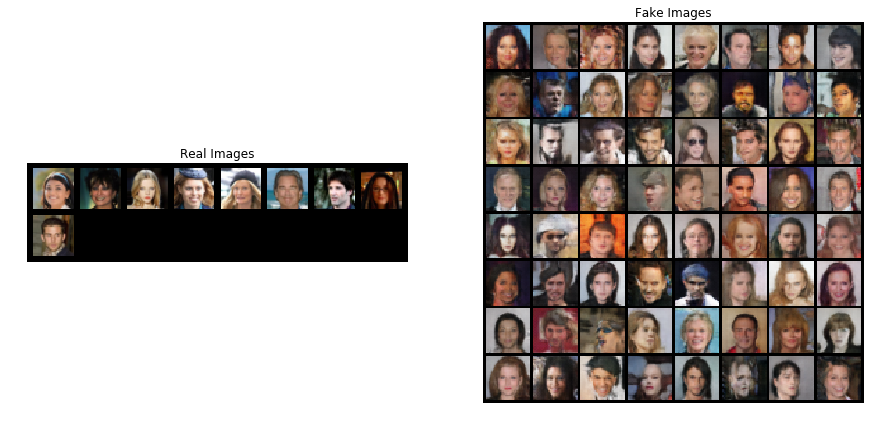

[3/5][0/22511]	Loss_D: 0.8466	Loss_G: 1.8589	D(x): 0.1608	D(G(z)): 0.8839 / 0.8330
[3/5][50/22511]	Loss_D: 0.9334	Loss_G: 1.9036	D(x): 0.1517	D(G(z)): 0.7586 / 0.8439
[3/5][100/22511]	Loss_D: 0.9173	Loss_G: 2.0168	D(x): 0.2568	D(G(z)): 0.7206 / 0.8646
[3/5][150/22511]	Loss_D: 0.8352	Loss_G: 2.0759	D(x): 0.1700	D(G(z)): 0.6993 / 0.8711
[3/5][200/22511]	Loss_D: 0.8161	Loss_G: 2.1283	D(x): 0.1140	D(G(z)): 0.9009 / 0.8754
[3/5][250/22511]	Loss_D: 0.9241	Loss_G: 1.4719	D(x): 0.2703	D(G(z)): 0.6830 / 0.7532
[3/5][300/22511]	Loss_D: 0.7762	Loss_G: 1.7176	D(x): 0.0967	D(G(z)): 0.7496 / 0.8143
[3/5][350/22511]	Loss_D: 1.0116	Loss_G: 1.9733	D(x): 0.3180	D(G(z)): 0.7102 / 0.8559
[3/5][400/22511]	Loss_D: 0.9752	Loss_G: 1.6356	D(x): 0.3152	D(G(z)): 0.7840 / 0.7982
[3/5][450/22511]	Loss_D: 0.9551	Loss_G: 1.6325	D(x): 0.1766	D(G(z)): 0.8134 / 0.7998
[3/5][500/22511]	Loss_D: 0.9866	Loss_G: 1.8308	D(x): 0.1271	D(G(z)): 0.8204 / 0.8272
[3/5][550/22511]	Loss_D: 0.9624	Loss_G: 1.7522	D(x): 0.2828	D(G(z)):

[3/5][4800/22511]	Loss_D: 0.8471	Loss_G: 1.6673	D(x): 0.1854	D(G(z)): 0.7700 / 0.8075
[3/5][4850/22511]	Loss_D: 1.1334	Loss_G: 1.8008	D(x): 0.5047	D(G(z)): 0.8836 / 0.8304
[3/5][4900/22511]	Loss_D: 0.9281	Loss_G: 1.8654	D(x): 0.1969	D(G(z)): 0.6980 / 0.8403
[3/5][4950/22511]	Loss_D: 0.9412	Loss_G: 1.5897	D(x): 0.0798	D(G(z)): 0.8312 / 0.7948
[3/5][5000/22511]	Loss_D: 0.9898	Loss_G: 1.6505	D(x): 0.2664	D(G(z)): 0.7659 / 0.8027
[3/5][5050/22511]	Loss_D: 1.2068	Loss_G: 1.5908	D(x): 0.4991	D(G(z)): 0.9128 / 0.7928
[3/5][5100/22511]	Loss_D: 0.7954	Loss_G: 2.1980	D(x): 0.1345	D(G(z)): 0.8356 / 0.8806
[3/5][5150/22511]	Loss_D: 0.9631	Loss_G: 1.9217	D(x): 0.2673	D(G(z)): 0.9303 / 0.8491
[3/5][5200/22511]	Loss_D: 0.9199	Loss_G: 2.2688	D(x): 0.0696	D(G(z)): 0.7627 / 0.8928
[3/5][5250/22511]	Loss_D: 1.0139	Loss_G: 1.6385	D(x): 0.0764	D(G(z)): 0.7006 / 0.8002
[3/5][5300/22511]	Loss_D: 0.8388	Loss_G: 2.0364	D(x): 0.0568	D(G(z)): 0.7523 / 0.8625
[3/5][5350/22511]	Loss_D: 0.9447	Loss_G: 1.7543	D(x): 

[3/5][9600/22511]	Loss_D: 0.8556	Loss_G: 2.1322	D(x): 0.0890	D(G(z)): 0.8267 / 0.8773
[3/5][9650/22511]	Loss_D: 0.9334	Loss_G: 1.8861	D(x): 0.0650	D(G(z)): 0.6632 / 0.8417
[3/5][9700/22511]	Loss_D: 0.9968	Loss_G: 1.8343	D(x): 0.0785	D(G(z)): 0.7871 / 0.8347
[3/5][9750/22511]	Loss_D: 1.4297	Loss_G: 1.4677	D(x): 0.6391	D(G(z)): 0.8660 / 0.7574
[3/5][9800/22511]	Loss_D: 0.9832	Loss_G: 2.0919	D(x): 0.0958	D(G(z)): 0.8883 / 0.8639
[3/5][9850/22511]	Loss_D: 1.0334	Loss_G: 2.2653	D(x): 0.0702	D(G(z)): 0.8853 / 0.8928
[3/5][9900/22511]	Loss_D: 0.9319	Loss_G: 1.8619	D(x): 0.1664	D(G(z)): 0.8167 / 0.8366
[3/5][9950/22511]	Loss_D: 1.1233	Loss_G: 1.7384	D(x): 0.1585	D(G(z)): 0.6023 / 0.8196
[3/5][10000/22511]	Loss_D: 0.9165	Loss_G: 2.2711	D(x): 0.2055	D(G(z)): 0.9010 / 0.8934
[3/5][10050/22511]	Loss_D: 0.9853	Loss_G: 1.9464	D(x): 0.1762	D(G(z)): 0.6727 / 0.8535
[3/5][10100/22511]	Loss_D: 1.0548	Loss_G: 2.0392	D(x): 0.1169	D(G(z)): 0.6150 / 0.8659
[3/5][10150/22511]	Loss_D: 1.0362	Loss_G: 1.9800	D(

[3/5][14350/22511]	Loss_D: 0.9132	Loss_G: 1.7986	D(x): 0.1501	D(G(z)): 0.7716 / 0.8239
[3/5][14400/22511]	Loss_D: 0.8697	Loss_G: 1.8147	D(x): 0.1925	D(G(z)): 0.8023 / 0.8241
[3/5][14450/22511]	Loss_D: 0.9560	Loss_G: 1.9077	D(x): 0.2582	D(G(z)): 0.7732 / 0.8425
[3/5][14500/22511]	Loss_D: 0.9327	Loss_G: 1.8709	D(x): 0.1684	D(G(z)): 0.7590 / 0.8436
[3/5][14550/22511]	Loss_D: 0.8836	Loss_G: 1.9309	D(x): 0.0791	D(G(z)): 0.6416 / 0.8475
[3/5][14600/22511]	Loss_D: 0.9593	Loss_G: 1.6833	D(x): 0.3405	D(G(z)): 0.7612 / 0.7959
[3/5][14650/22511]	Loss_D: 1.0647	Loss_G: 1.7761	D(x): 0.3081	D(G(z)): 0.9095 / 0.8256
[3/5][14700/22511]	Loss_D: 1.2365	Loss_G: 2.7659	D(x): 0.1103	D(G(z)): 0.4821 / 0.9305
[3/5][14750/22511]	Loss_D: 0.8941	Loss_G: 1.7675	D(x): 0.3661	D(G(z)): 0.8617 / 0.8231
[3/5][14800/22511]	Loss_D: 0.8690	Loss_G: 2.4216	D(x): 0.1677	D(G(z)): 0.7289 / 0.9074
[3/5][14850/22511]	Loss_D: 0.8040	Loss_G: 1.7731	D(x): 0.1408	D(G(z)): 0.7235 / 0.8162
[3/5][14900/22511]	Loss_D: 0.7105	Loss_G: 2

[3/5][19100/22511]	Loss_D: 0.8564	Loss_G: 1.7524	D(x): 0.1721	D(G(z)): 0.8079 / 0.8231
[3/5][19150/22511]	Loss_D: 0.9631	Loss_G: 2.4401	D(x): 0.4166	D(G(z)): 0.9296 / 0.9089
[3/5][19200/22511]	Loss_D: 1.1014	Loss_G: 1.5451	D(x): 0.0334	D(G(z)): 0.7907 / 0.7701
[3/5][19250/22511]	Loss_D: 0.8998	Loss_G: 1.6845	D(x): 0.1633	D(G(z)): 0.7966 / 0.8110
[3/5][19300/22511]	Loss_D: 1.1428	Loss_G: 1.6690	D(x): 0.4367	D(G(z)): 0.9163 / 0.8032
[3/5][19350/22511]	Loss_D: 0.8055	Loss_G: 2.2693	D(x): 0.1240	D(G(z)): 0.8221 / 0.8926
[3/5][19400/22511]	Loss_D: 0.9583	Loss_G: 1.7660	D(x): 0.1714	D(G(z)): 0.6028 / 0.8262
[3/5][19450/22511]	Loss_D: 0.9972	Loss_G: 1.7005	D(x): 0.2284	D(G(z)): 0.8703 / 0.8126
[3/5][19500/22511]	Loss_D: 0.8868	Loss_G: 1.9480	D(x): 0.1574	D(G(z)): 0.6597 / 0.8540
[3/5][19550/22511]	Loss_D: 0.7932	Loss_G: 2.1733	D(x): 0.2472	D(G(z)): 0.8420 / 0.8830
[3/5][19600/22511]	Loss_D: 0.8582	Loss_G: 2.3809	D(x): 0.1016	D(G(z)): 0.8963 / 0.9017
[3/5][19650/22511]	Loss_D: 0.9206	Loss_G: 1

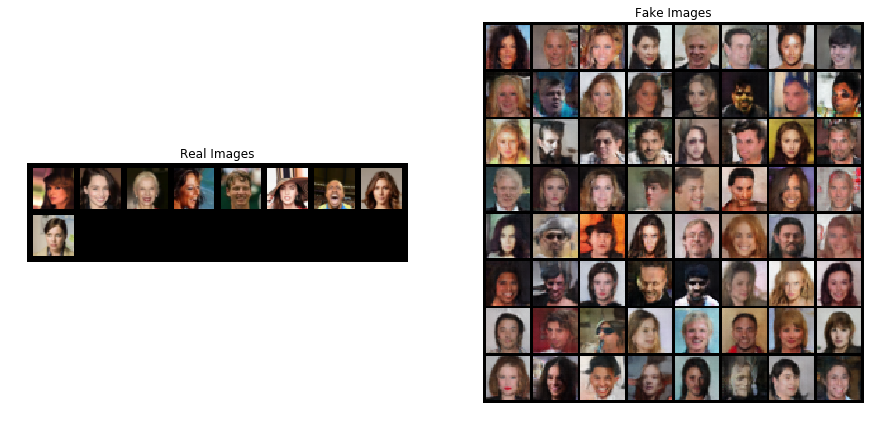

[4/5][0/22511]	Loss_D: 0.8020	Loss_G: 2.0591	D(x): 0.1972	D(G(z)): 0.8022 / 0.8669
[4/5][50/22511]	Loss_D: 1.0367	Loss_G: 1.6826	D(x): 0.3806	D(G(z)): 0.7646 / 0.8085
[4/5][100/22511]	Loss_D: 1.2092	Loss_G: 0.9360	D(x): 0.4445	D(G(z)): 0.8111 / 0.6031
[4/5][150/22511]	Loss_D: 0.8479	Loss_G: 1.7935	D(x): 0.1123	D(G(z)): 0.7431 / 0.8235
[4/5][200/22511]	Loss_D: 0.8567	Loss_G: 1.8202	D(x): 0.1102	D(G(z)): 0.7702 / 0.8289
[4/5][250/22511]	Loss_D: 1.0093	Loss_G: 1.6979	D(x): 0.3469	D(G(z)): 0.7627 / 0.8123
[4/5][300/22511]	Loss_D: 0.8558	Loss_G: 2.1957	D(x): 0.1158	D(G(z)): 0.7981 / 0.8852
[4/5][350/22511]	Loss_D: 0.8535	Loss_G: 2.1799	D(x): 0.1243	D(G(z)): 0.7234 / 0.8793
[4/5][400/22511]	Loss_D: 1.0426	Loss_G: 2.6405	D(x): 0.2553	D(G(z)): 0.9462 / 0.9196
[4/5][450/22511]	Loss_D: 0.9345	Loss_G: 1.7136	D(x): 0.0719	D(G(z)): 0.6233 / 0.8174
[4/5][500/22511]	Loss_D: 1.0150	Loss_G: 1.5909	D(x): 0.3310	D(G(z)): 0.7611 / 0.7932
[4/5][550/22511]	Loss_D: 0.9105	Loss_G: 2.0054	D(x): 0.0823	D(G(z)):

[4/5][4800/22511]	Loss_D: 0.9146	Loss_G: 2.2557	D(x): 0.2384	D(G(z)): 0.8926 / 0.8874
[4/5][4850/22511]	Loss_D: 1.0109	Loss_G: 1.8410	D(x): 0.1179	D(G(z)): 0.8698 / 0.8367
[4/5][4900/22511]	Loss_D: 1.1362	Loss_G: 1.7313	D(x): 0.4874	D(G(z)): 0.8141 / 0.8185
[4/5][4950/22511]	Loss_D: 0.8538	Loss_G: 1.6877	D(x): 0.1625	D(G(z)): 0.8009 / 0.8113
[4/5][5000/22511]	Loss_D: 1.0847	Loss_G: 1.7591	D(x): 0.5344	D(G(z)): 0.8605 / 0.8208
[4/5][5050/22511]	Loss_D: 0.9319	Loss_G: 2.1139	D(x): 0.0941	D(G(z)): 0.7843 / 0.8760
[4/5][5100/22511]	Loss_D: 0.9781	Loss_G: 2.5316	D(x): 0.2664	D(G(z)): 0.9501 / 0.9163
[4/5][5150/22511]	Loss_D: 0.9655	Loss_G: 1.7485	D(x): 0.3714	D(G(z)): 0.8295 / 0.8169
[4/5][5200/22511]	Loss_D: 1.0467	Loss_G: 1.9253	D(x): 0.0733	D(G(z)): 0.8313 / 0.8480
[4/5][5250/22511]	Loss_D: 1.0659	Loss_G: 1.3828	D(x): 0.3483	D(G(z)): 0.8083 / 0.7406
[4/5][5300/22511]	Loss_D: 0.9069	Loss_G: 1.7773	D(x): 0.1398	D(G(z)): 0.8583 / 0.8247
[4/5][5350/22511]	Loss_D: 1.1260	Loss_G: 2.3315	D(x): 

[4/5][9600/22511]	Loss_D: 0.8204	Loss_G: 2.2677	D(x): 0.0712	D(G(z)): 0.7748 / 0.8918
[4/5][9650/22511]	Loss_D: 0.8363	Loss_G: 1.9820	D(x): 0.1089	D(G(z)): 0.7990 / 0.8572
[4/5][9700/22511]	Loss_D: 0.9418	Loss_G: 1.9848	D(x): 0.1257	D(G(z)): 0.8406 / 0.8559
[4/5][9750/22511]	Loss_D: 1.0562	Loss_G: 2.1231	D(x): 0.1536	D(G(z)): 0.5651 / 0.8782
[4/5][9800/22511]	Loss_D: 0.9321	Loss_G: 2.3065	D(x): 0.0637	D(G(z)): 0.8829 / 0.8970
[4/5][9850/22511]	Loss_D: 1.0308	Loss_G: 1.7084	D(x): 0.0826	D(G(z)): 0.7372 / 0.8130
[4/5][9900/22511]	Loss_D: 1.1286	Loss_G: 1.8380	D(x): 0.3111	D(G(z)): 0.6294 / 0.8346
[4/5][9950/22511]	Loss_D: 0.8840	Loss_G: 1.9496	D(x): 0.1741	D(G(z)): 0.7681 / 0.8537
[4/5][10000/22511]	Loss_D: 0.9824	Loss_G: 1.6858	D(x): 0.3345	D(G(z)): 0.7917 / 0.8026
[4/5][10050/22511]	Loss_D: 0.9253	Loss_G: 2.1351	D(x): 0.1143	D(G(z)): 0.6612 / 0.8706
[4/5][10100/22511]	Loss_D: 0.9111	Loss_G: 1.9314	D(x): 0.1450	D(G(z)): 0.7887 / 0.8461
[4/5][10150/22511]	Loss_D: 0.9635	Loss_G: 2.1596	D(

[4/5][14350/22511]	Loss_D: 0.8718	Loss_G: 1.8958	D(x): 0.1790	D(G(z)): 0.8984 / 0.8402
[4/5][14400/22511]	Loss_D: 0.9106	Loss_G: 1.9577	D(x): 0.1648	D(G(z)): 0.6652 / 0.8501
[4/5][14450/22511]	Loss_D: 0.9473	Loss_G: 1.7835	D(x): 0.1441	D(G(z)): 0.7235 / 0.8235
[4/5][14500/22511]	Loss_D: 0.9743	Loss_G: 1.5862	D(x): 0.1599	D(G(z)): 0.6782 / 0.7930
[4/5][14550/22511]	Loss_D: 0.8486	Loss_G: 2.0265	D(x): 0.2310	D(G(z)): 0.8285 / 0.8635
[4/5][14600/22511]	Loss_D: 1.0343	Loss_G: 1.9881	D(x): 0.1747	D(G(z)): 0.6037 / 0.8599
[4/5][14650/22511]	Loss_D: 0.7701	Loss_G: 2.0512	D(x): 0.2603	D(G(z)): 0.8529 / 0.8688
[4/5][14700/22511]	Loss_D: 0.8876	Loss_G: 1.9824	D(x): 0.1344	D(G(z)): 0.6929 / 0.8539
[4/5][14750/22511]	Loss_D: 1.0367	Loss_G: 1.6146	D(x): 0.4082	D(G(z)): 0.8483 / 0.7889
[4/5][14800/22511]	Loss_D: 0.8786	Loss_G: 1.9028	D(x): 0.1481	D(G(z)): 0.8523 / 0.8436
[4/5][14850/22511]	Loss_D: 0.9324	Loss_G: 1.7551	D(x): 0.1134	D(G(z)): 0.7749 / 0.8244
[4/5][14900/22511]	Loss_D: 0.9594	Loss_G: 1

[4/5][19100/22511]	Loss_D: 0.9309	Loss_G: 1.7643	D(x): 0.2053	D(G(z)): 0.7511 / 0.8198
[4/5][19150/22511]	Loss_D: 0.9462	Loss_G: 1.7121	D(x): 0.1933	D(G(z)): 0.8631 / 0.8085
[4/5][19200/22511]	Loss_D: 0.8093	Loss_G: 1.6695	D(x): 0.2347	D(G(z)): 0.8141 / 0.8048
[4/5][19250/22511]	Loss_D: 0.8685	Loss_G: 2.2543	D(x): 0.0938	D(G(z)): 0.7605 / 0.8933
[4/5][19300/22511]	Loss_D: 0.9401	Loss_G: 1.7615	D(x): 0.1632	D(G(z)): 0.8705 / 0.8241
[4/5][19350/22511]	Loss_D: 1.0307	Loss_G: 1.7785	D(x): 0.3987	D(G(z)): 0.8664 / 0.8253
[4/5][19400/22511]	Loss_D: 0.9268	Loss_G: 2.3115	D(x): 0.3203	D(G(z)): 0.9364 / 0.8908
[4/5][19450/22511]	Loss_D: 0.9076	Loss_G: 1.9221	D(x): 0.2338	D(G(z)): 0.8196 / 0.8444
[4/5][19500/22511]	Loss_D: 0.9219	Loss_G: 2.1706	D(x): 0.1482	D(G(z)): 0.8433 / 0.8822
[4/5][19550/22511]	Loss_D: 0.9857	Loss_G: 1.6145	D(x): 0.1845	D(G(z)): 0.7099 / 0.7981
[4/5][19600/22511]	Loss_D: 0.8931	Loss_G: 1.8392	D(x): 0.2512	D(G(z)): 0.7869 / 0.8372
[4/5][19650/22511]	Loss_D: 0.7603	Loss_G: 2

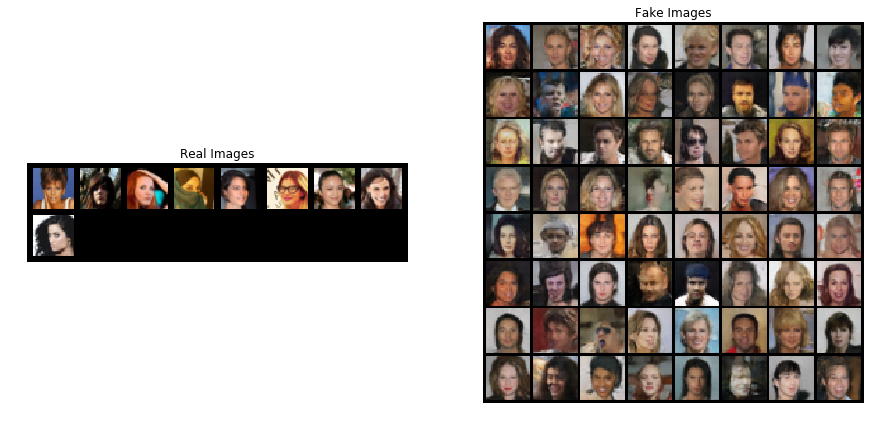

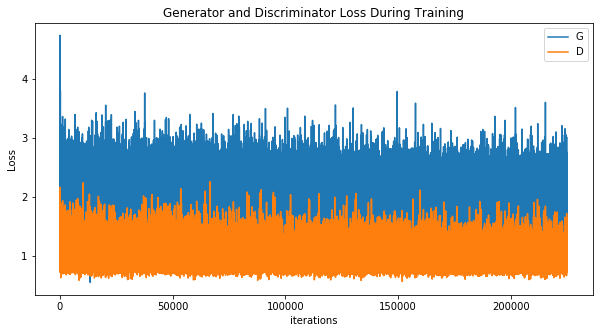

[0/5][0/22511]	Loss_D: 0.9670	Loss_G: 1.9984	D(x): 0.1828	D(G(z)): 0.6898 / 0.8594
[0/5][50/22511]	Loss_D: 0.9261	Loss_G: 2.2065	D(x): 0.2158	D(G(z)): 0.9394 / 0.8837
[0/5][100/22511]	Loss_D: 1.0183	Loss_G: 1.4798	D(x): 0.3272	D(G(z)): 0.7138 / 0.7685
[0/5][150/22511]	Loss_D: 0.8587	Loss_G: 2.1679	D(x): 0.1558	D(G(z)): 0.8504 / 0.8837
[0/5][200/22511]	Loss_D: 1.0917	Loss_G: 1.9313	D(x): 0.3522	D(G(z)): 0.9205 / 0.8509
[0/5][250/22511]	Loss_D: 1.0528	Loss_G: 2.0034	D(x): 0.1081	D(G(z)): 0.8917 / 0.8565
[0/5][300/22511]	Loss_D: 0.9907	Loss_G: 1.4120	D(x): 0.2724	D(G(z)): 0.7630 / 0.7503
[0/5][350/22511]	Loss_D: 0.8301	Loss_G: 1.7696	D(x): 0.1066	D(G(z)): 0.8307 / 0.8248
[0/5][400/22511]	Loss_D: 1.0090	Loss_G: 2.1380	D(x): 0.1358	D(G(z)): 0.6225 / 0.8762
[0/5][450/22511]	Loss_D: 0.9873	Loss_G: 1.9997	D(x): 0.1915	D(G(z)): 0.8975 / 0.8392
[0/5][500/22511]	Loss_D: 1.0562	Loss_G: 1.6934	D(x): 0.0323	D(G(z)): 0.7638 / 0.8125
[0/5][550/22511]	Loss_D: 0.9790	Loss_G: 1.9038	D(x): 0.1957	D(G(z)):

[0/5][4800/22511]	Loss_D: 1.0232	Loss_G: 2.2974	D(x): 0.0894	D(G(z)): 0.8973 / 0.8951
[0/5][4850/22511]	Loss_D: 0.9929	Loss_G: 1.6120	D(x): 0.2802	D(G(z)): 0.6511 / 0.7987
[0/5][4900/22511]	Loss_D: 0.8400	Loss_G: 1.4047	D(x): 0.1973	D(G(z)): 0.7456 / 0.7498
[0/5][4950/22511]	Loss_D: 1.2523	Loss_G: 1.8650	D(x): 0.0185	D(G(z)): 0.6696 / 0.8399
[0/5][5000/22511]	Loss_D: 1.0745	Loss_G: 1.6034	D(x): 0.3892	D(G(z)): 0.7403 / 0.7926
[0/5][5050/22511]	Loss_D: 0.8909	Loss_G: 1.6826	D(x): 0.1787	D(G(z)): 0.7301 / 0.8096
[0/5][5100/22511]	Loss_D: 1.0757	Loss_G: 2.2658	D(x): 0.0784	D(G(z)): 0.8123 / 0.8906
[0/5][5150/22511]	Loss_D: 0.9917	Loss_G: 1.7774	D(x): 0.1361	D(G(z)): 0.7093 / 0.8238
[0/5][5200/22511]	Loss_D: 0.9523	Loss_G: 2.0756	D(x): 0.2200	D(G(z)): 0.6871 / 0.8710
[0/5][5250/22511]	Loss_D: 0.9745	Loss_G: 1.7897	D(x): 0.1754	D(G(z)): 0.8652 / 0.8227
[0/5][5300/22511]	Loss_D: 0.8580	Loss_G: 1.8105	D(x): 0.2516	D(G(z)): 0.8200 / 0.8325
[0/5][5350/22511]	Loss_D: 0.8402	Loss_G: 1.7992	D(x): 

[0/5][9600/22511]	Loss_D: 0.9354	Loss_G: 2.0055	D(x): 0.3573	D(G(z)): 0.7905 / 0.8635
[0/5][9650/22511]	Loss_D: 0.9711	Loss_G: 2.0312	D(x): 0.3119	D(G(z)): 0.8848 / 0.8615
[0/5][9700/22511]	Loss_D: 0.9948	Loss_G: 2.0264	D(x): 0.2304	D(G(z)): 0.7228 / 0.8605
[0/5][9750/22511]	Loss_D: 0.9690	Loss_G: 1.9902	D(x): 0.1286	D(G(z)): 0.6952 / 0.8617
[0/5][9800/22511]	Loss_D: 0.8670	Loss_G: 1.9679	D(x): 0.2692	D(G(z)): 0.7289 / 0.8469
[0/5][9850/22511]	Loss_D: 0.8423	Loss_G: 2.0761	D(x): 0.2285	D(G(z)): 0.7537 / 0.8727
[0/5][9900/22511]	Loss_D: 1.3546	Loss_G: 1.2506	D(x): 0.5836	D(G(z)): 0.7836 / 0.7074
[0/5][9950/22511]	Loss_D: 0.8919	Loss_G: 2.0110	D(x): 0.2454	D(G(z)): 0.8433 / 0.8604
[0/5][10000/22511]	Loss_D: 0.9000	Loss_G: 1.7009	D(x): 0.2742	D(G(z)): 0.8256 / 0.8126
[0/5][10050/22511]	Loss_D: 0.7782	Loss_G: 1.8779	D(x): 0.2370	D(G(z)): 0.8168 / 0.8293
[0/5][10100/22511]	Loss_D: 0.8939	Loss_G: 1.9401	D(x): 0.2016	D(G(z)): 0.6533 / 0.8479
[0/5][10150/22511]	Loss_D: 0.8391	Loss_G: 1.7750	D(

[0/5][14350/22511]	Loss_D: 0.9029	Loss_G: 2.0687	D(x): 0.0925	D(G(z)): 0.6601 / 0.8693
[0/5][14400/22511]	Loss_D: 0.8407	Loss_G: 1.9785	D(x): 0.1118	D(G(z)): 0.7722 / 0.8582
[0/5][14450/22511]	Loss_D: 0.8906	Loss_G: 1.5699	D(x): 0.1393	D(G(z)): 0.9018 / 0.7880
[0/5][14500/22511]	Loss_D: 0.9637	Loss_G: 1.8060	D(x): 0.2987	D(G(z)): 0.8765 / 0.8176
[0/5][14550/22511]	Loss_D: 0.9717	Loss_G: 1.7504	D(x): 0.3488	D(G(z)): 0.7418 / 0.8233
[0/5][14600/22511]	Loss_D: 1.0494	Loss_G: 1.7945	D(x): 0.3935	D(G(z)): 0.7549 / 0.8261
[0/5][14650/22511]	Loss_D: 0.9276	Loss_G: 2.1372	D(x): 0.2089	D(G(z)): 0.6881 / 0.8770
[0/5][14700/22511]	Loss_D: 0.8652	Loss_G: 1.8622	D(x): 0.2219	D(G(z)): 0.8565 / 0.8385
[0/5][14750/22511]	Loss_D: 1.0387	Loss_G: 1.9335	D(x): 0.0814	D(G(z)): 0.7134 / 0.8505
[0/5][14800/22511]	Loss_D: 1.0454	Loss_G: 2.1349	D(x): 0.0439	D(G(z)): 0.5687 / 0.8795
[0/5][14850/22511]	Loss_D: 0.8389	Loss_G: 2.4870	D(x): 0.1467	D(G(z)): 0.9044 / 0.9106
[0/5][14900/22511]	Loss_D: 0.8931	Loss_G: 1

[0/5][19100/22511]	Loss_D: 0.9206	Loss_G: 1.9545	D(x): 0.1085	D(G(z)): 0.8465 / 0.8546
[0/5][19150/22511]	Loss_D: 0.8991	Loss_G: 1.8045	D(x): 0.1885	D(G(z)): 0.8088 / 0.8260
[0/5][19200/22511]	Loss_D: 0.9989	Loss_G: 1.9422	D(x): 0.1504	D(G(z)): 0.8355 / 0.8497
[0/5][19250/22511]	Loss_D: 0.8861	Loss_G: 2.0800	D(x): 0.2134	D(G(z)): 0.8894 / 0.8658
[0/5][19300/22511]	Loss_D: 1.1865	Loss_G: 2.2086	D(x): 0.3552	D(G(z)): 0.5460 / 0.8886
[0/5][19350/22511]	Loss_D: 1.1470	Loss_G: 2.2411	D(x): 0.2572	D(G(z)): 0.5114 / 0.8912
[0/5][19400/22511]	Loss_D: 1.0592	Loss_G: 2.0154	D(x): 0.0351	D(G(z)): 0.7185 / 0.8631
[0/5][19450/22511]	Loss_D: 1.0796	Loss_G: 2.2280	D(x): 0.1154	D(G(z)): 0.6426 / 0.8891
[0/5][19500/22511]	Loss_D: 0.9336	Loss_G: 2.0046	D(x): 0.1225	D(G(z)): 0.7417 / 0.8563
[0/5][19550/22511]	Loss_D: 0.9954	Loss_G: 1.5125	D(x): 0.1264	D(G(z)): 0.7101 / 0.7743
[0/5][19600/22511]	Loss_D: 0.7690	Loss_G: 1.9660	D(x): 0.1140	D(G(z)): 0.8313 / 0.8587
[0/5][19650/22511]	Loss_D: 0.8250	Loss_G: 2

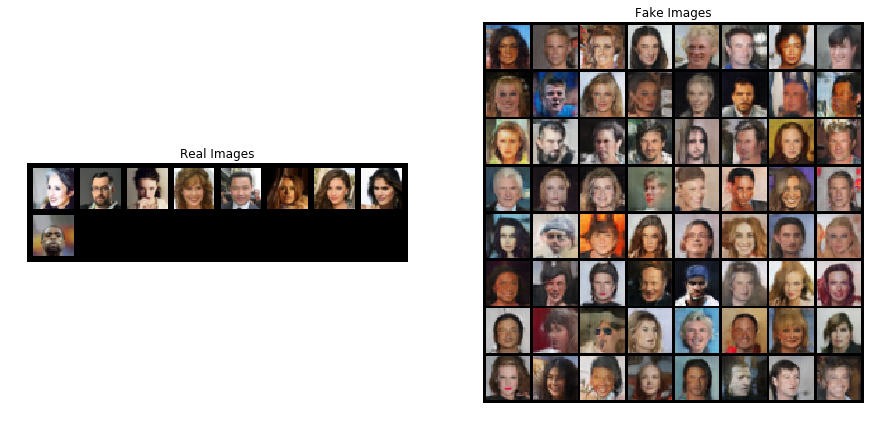

[1/5][0/22511]	Loss_D: 0.9597	Loss_G: 2.0347	D(x): 0.1164	D(G(z)): 0.7722 / 0.8668
[1/5][50/22511]	Loss_D: 0.8246	Loss_G: 2.2651	D(x): 0.2551	D(G(z)): 0.9034 / 0.8892
[1/5][100/22511]	Loss_D: 0.9120	Loss_G: 1.7526	D(x): 0.1581	D(G(z)): 0.8543 / 0.8223
[1/5][150/22511]	Loss_D: 0.7974	Loss_G: 1.8617	D(x): 0.1093	D(G(z)): 0.7144 / 0.8418
[1/5][200/22511]	Loss_D: 0.8563	Loss_G: 2.3675	D(x): 0.1104	D(G(z)): 0.9095 / 0.8976
[1/5][250/22511]	Loss_D: 1.0056	Loss_G: 2.0065	D(x): 0.1236	D(G(z)): 0.8693 / 0.8617
[1/5][300/22511]	Loss_D: 0.9291	Loss_G: 2.1612	D(x): 0.0462	D(G(z)): 0.8431 / 0.8702
[1/5][350/22511]	Loss_D: 0.9731	Loss_G: 2.0760	D(x): 0.3589	D(G(z)): 0.9062 / 0.8688
[1/5][400/22511]	Loss_D: 0.8806	Loss_G: 1.6757	D(x): 0.2502	D(G(z)): 0.8036 / 0.8078
[1/5][450/22511]	Loss_D: 0.8710	Loss_G: 1.7582	D(x): 0.2807	D(G(z)): 0.7792 / 0.8170
[1/5][500/22511]	Loss_D: 0.7989	Loss_G: 2.4665	D(x): 0.1455	D(G(z)): 0.9264 / 0.9054
[1/5][550/22511]	Loss_D: 1.1015	Loss_G: 1.6963	D(x): 0.3500	D(G(z)):

[1/5][4800/22511]	Loss_D: 0.9135	Loss_G: 1.6728	D(x): 0.1795	D(G(z)): 0.8061 / 0.8079
[1/5][4850/22511]	Loss_D: 0.9241	Loss_G: 1.7013	D(x): 0.1551	D(G(z)): 0.7983 / 0.8140
[1/5][4900/22511]	Loss_D: 1.0285	Loss_G: 2.2347	D(x): 0.2488	D(G(z)): 0.6009 / 0.8906
[1/5][4950/22511]	Loss_D: 1.0970	Loss_G: 1.9108	D(x): 0.5066	D(G(z)): 0.8804 / 0.8391
[1/5][5000/22511]	Loss_D: 0.8908	Loss_G: 1.5486	D(x): 0.1733	D(G(z)): 0.7913 / 0.7803
[1/5][5050/22511]	Loss_D: 0.8430	Loss_G: 1.7944	D(x): 0.1172	D(G(z)): 0.8116 / 0.8294
[1/5][5100/22511]	Loss_D: 1.0303	Loss_G: 1.9122	D(x): 0.1901	D(G(z)): 0.8852 / 0.8420
[1/5][5150/22511]	Loss_D: 1.0369	Loss_G: 1.8113	D(x): 0.1185	D(G(z)): 0.6596 / 0.8212
[1/5][5200/22511]	Loss_D: 1.0292	Loss_G: 1.6828	D(x): 0.3084	D(G(z)): 0.8629 / 0.8054
[1/5][5250/22511]	Loss_D: 0.8929	Loss_G: 2.2068	D(x): 0.0606	D(G(z)): 0.8246 / 0.8845
[1/5][5300/22511]	Loss_D: 1.0582	Loss_G: 1.4306	D(x): 0.0674	D(G(z)): 0.7394 / 0.7527
[1/5][5350/22511]	Loss_D: 0.9291	Loss_G: 1.8737	D(x): 

[1/5][9600/22511]	Loss_D: 1.0171	Loss_G: 1.7134	D(x): 0.4055	D(G(z)): 0.8374 / 0.8101
[1/5][9650/22511]	Loss_D: 0.9773	Loss_G: 1.4541	D(x): 0.1687	D(G(z)): 0.7010 / 0.7561
[1/5][9700/22511]	Loss_D: 0.9669	Loss_G: 1.8719	D(x): 0.0586	D(G(z)): 0.8057 / 0.8430
[1/5][9750/22511]	Loss_D: 0.9098	Loss_G: 2.1887	D(x): 0.1245	D(G(z)): 0.7342 / 0.8822
[1/5][9800/22511]	Loss_D: 0.7045	Loss_G: 1.9244	D(x): 0.0795	D(G(z)): 0.8643 / 0.8474
[1/5][9850/22511]	Loss_D: 0.8723	Loss_G: 1.9369	D(x): 0.2285	D(G(z)): 0.7081 / 0.8497
[1/5][9900/22511]	Loss_D: 0.9134	Loss_G: 1.6614	D(x): 0.2887	D(G(z)): 0.7592 / 0.8068
[1/5][9950/22511]	Loss_D: 0.7923	Loss_G: 1.9115	D(x): 0.1112	D(G(z)): 0.8548 / 0.8476
[1/5][10000/22511]	Loss_D: 1.0862	Loss_G: 1.7018	D(x): 0.3730	D(G(z)): 0.8550 / 0.8115
[1/5][10050/22511]	Loss_D: 1.0878	Loss_G: 2.1772	D(x): 0.0715	D(G(z)): 0.6504 / 0.8832
[1/5][10100/22511]	Loss_D: 1.1234	Loss_G: 2.1674	D(x): 0.1020	D(G(z)): 0.5254 / 0.8824
[1/5][10150/22511]	Loss_D: 0.9244	Loss_G: 1.8722	D(

[1/5][14350/22511]	Loss_D: 1.0668	Loss_G: 1.6403	D(x): 0.3675	D(G(z)): 0.8959 / 0.8036
[1/5][14400/22511]	Loss_D: 0.9805	Loss_G: 2.0346	D(x): 0.0858	D(G(z)): 0.6885 / 0.8650
[1/5][14450/22511]	Loss_D: 0.9525	Loss_G: 1.8567	D(x): 0.1138	D(G(z)): 0.8822 / 0.8336
[1/5][14500/22511]	Loss_D: 0.8064	Loss_G: 1.8951	D(x): 0.0874	D(G(z)): 0.7955 / 0.8446
[1/5][14550/22511]	Loss_D: 0.9233	Loss_G: 1.8806	D(x): 0.1357	D(G(z)): 0.6353 / 0.8433
[1/5][14600/22511]	Loss_D: 0.9587	Loss_G: 2.2715	D(x): 0.0960	D(G(z)): 0.6445 / 0.8937
[1/5][14650/22511]	Loss_D: 0.8256	Loss_G: 1.6830	D(x): 0.0571	D(G(z)): 0.7337 / 0.8079
[1/5][14700/22511]	Loss_D: 1.0674	Loss_G: 1.7783	D(x): 0.5076	D(G(z)): 0.8858 / 0.8117
[1/5][14750/22511]	Loss_D: 0.9000	Loss_G: 1.9373	D(x): 0.2682	D(G(z)): 0.7128 / 0.8519
[1/5][14800/22511]	Loss_D: 1.1252	Loss_G: 1.9150	D(x): 0.4168	D(G(z)): 0.6691 / 0.8448
[1/5][14850/22511]	Loss_D: 1.0853	Loss_G: 2.0361	D(x): 0.4314	D(G(z)): 0.9457 / 0.8604
[1/5][14900/22511]	Loss_D: 0.8297	Loss_G: 1

[1/5][19100/22511]	Loss_D: 1.0052	Loss_G: 1.8654	D(x): 0.2739	D(G(z)): 0.6491 / 0.8399
[1/5][19150/22511]	Loss_D: 1.1229	Loss_G: 1.4065	D(x): 0.4561	D(G(z)): 0.8107 / 0.7456
[1/5][19200/22511]	Loss_D: 1.1009	Loss_G: 1.5599	D(x): 0.4826	D(G(z)): 0.7973 / 0.7780
[1/5][19250/22511]	Loss_D: 0.9351	Loss_G: 1.9031	D(x): 0.1311	D(G(z)): 0.8307 / 0.8499
[1/5][19300/22511]	Loss_D: 0.7514	Loss_G: 2.1118	D(x): 0.1706	D(G(z)): 0.8765 / 0.8739
[1/5][19350/22511]	Loss_D: 1.0214	Loss_G: 2.0876	D(x): 0.1652	D(G(z)): 0.6114 / 0.8703
[1/5][19400/22511]	Loss_D: 0.9537	Loss_G: 2.2585	D(x): 0.0972	D(G(z)): 0.7117 / 0.8925
[1/5][19450/22511]	Loss_D: 0.9920	Loss_G: 1.4921	D(x): 0.2867	D(G(z)): 0.7558 / 0.7703
[1/5][19500/22511]	Loss_D: 0.9590	Loss_G: 2.0911	D(x): 0.2979	D(G(z)): 0.8483 / 0.8725
[1/5][19550/22511]	Loss_D: 0.9928	Loss_G: 1.7888	D(x): 0.1281	D(G(z)): 0.7812 / 0.8273
[1/5][19600/22511]	Loss_D: 1.0429	Loss_G: 1.6958	D(x): 0.2732	D(G(z)): 0.6211 / 0.8141
[1/5][19650/22511]	Loss_D: 0.8968	Loss_G: 1

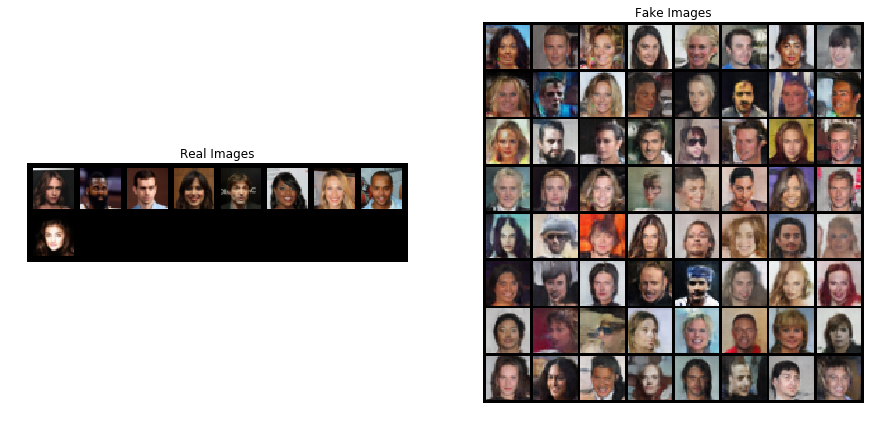

[2/5][0/22511]	Loss_D: 0.9256	Loss_G: 2.0056	D(x): 0.1717	D(G(z)): 0.7895 / 0.8606
[2/5][50/22511]	Loss_D: 0.8213	Loss_G: 2.1309	D(x): 0.1172	D(G(z)): 0.8556 / 0.8696
[2/5][100/22511]	Loss_D: 0.8525	Loss_G: 1.8006	D(x): 0.0974	D(G(z)): 0.7726 / 0.8300
[2/5][150/22511]	Loss_D: 0.7626	Loss_G: 2.1552	D(x): 0.1479	D(G(z)): 0.8188 / 0.8812
[2/5][200/22511]	Loss_D: 1.0525	Loss_G: 1.8521	D(x): 0.2163	D(G(z)): 0.6876 / 0.8352
[2/5][250/22511]	Loss_D: 0.8618	Loss_G: 1.8567	D(x): 0.0952	D(G(z)): 0.8395 / 0.8366
[2/5][300/22511]	Loss_D: 0.9115	Loss_G: 1.8382	D(x): 0.2875	D(G(z)): 0.7779 / 0.8327
[2/5][350/22511]	Loss_D: 0.8653	Loss_G: 2.0933	D(x): 0.1606	D(G(z)): 0.7223 / 0.8735
[2/5][400/22511]	Loss_D: 0.9065	Loss_G: 1.6282	D(x): 0.2416	D(G(z)): 0.8155 / 0.7968
[2/5][450/22511]	Loss_D: 1.1277	Loss_G: 1.8316	D(x): 0.4997	D(G(z)): 0.8643 / 0.8344
[2/5][500/22511]	Loss_D: 0.9784	Loss_G: 1.7098	D(x): 0.2247	D(G(z)): 0.8577 / 0.8159
[2/5][550/22511]	Loss_D: 0.8442	Loss_G: 2.2341	D(x): 0.1529	D(G(z)):

[2/5][4800/22511]	Loss_D: 0.9906	Loss_G: 1.8847	D(x): 0.1549	D(G(z)): 0.7997 / 0.8394
[2/5][4850/22511]	Loss_D: 0.8779	Loss_G: 2.1234	D(x): 0.1452	D(G(z)): 0.8597 / 0.8759
[2/5][4900/22511]	Loss_D: 0.8863	Loss_G: 1.7248	D(x): 0.2355	D(G(z)): 0.7702 / 0.8193
[2/5][4950/22511]	Loss_D: 0.8900	Loss_G: 1.9370	D(x): 0.2801	D(G(z)): 0.8608 / 0.8529
[2/5][5000/22511]	Loss_D: 0.8771	Loss_G: 1.9581	D(x): 0.2215	D(G(z)): 0.8222 / 0.8568
[2/5][5050/22511]	Loss_D: 0.9791	Loss_G: 2.0924	D(x): 0.1660	D(G(z)): 0.9129 / 0.8715
[2/5][5100/22511]	Loss_D: 0.9548	Loss_G: 1.9516	D(x): 0.3553	D(G(z)): 0.7904 / 0.8519
[2/5][5150/22511]	Loss_D: 0.9154	Loss_G: 2.1757	D(x): 0.0943	D(G(z)): 0.7958 / 0.8728
[2/5][5200/22511]	Loss_D: 0.9243	Loss_G: 2.3606	D(x): 0.2863	D(G(z)): 0.8702 / 0.8996
[2/5][5250/22511]	Loss_D: 0.9163	Loss_G: 1.9579	D(x): 0.1227	D(G(z)): 0.7413 / 0.8540
[2/5][5300/22511]	Loss_D: 0.8823	Loss_G: 1.9928	D(x): 0.2576	D(G(z)): 0.8941 / 0.8582
[2/5][5350/22511]	Loss_D: 0.9139	Loss_G: 1.8272	D(x): 

[2/5][9600/22511]	Loss_D: 0.7474	Loss_G: 2.2757	D(x): 0.1335	D(G(z)): 0.8406 / 0.8857
[2/5][9650/22511]	Loss_D: 0.8412	Loss_G: 1.8235	D(x): 0.1211	D(G(z)): 0.8583 / 0.8367
[2/5][9700/22511]	Loss_D: 0.9657	Loss_G: 2.0455	D(x): 0.3561	D(G(z)): 0.8803 / 0.8647
[2/5][9750/22511]	Loss_D: 0.9855	Loss_G: 1.9055	D(x): 0.2276	D(G(z)): 0.6822 / 0.8446
[2/5][9800/22511]	Loss_D: 1.0993	Loss_G: 1.8934	D(x): 0.3758	D(G(z)): 0.8926 / 0.8401
[2/5][9850/22511]	Loss_D: 0.9052	Loss_G: 1.7863	D(x): 0.2136	D(G(z)): 0.8016 / 0.8258
[2/5][9900/22511]	Loss_D: 0.9436	Loss_G: 1.9522	D(x): 0.0628	D(G(z)): 0.7225 / 0.8562
[2/5][9950/22511]	Loss_D: 0.9201	Loss_G: 2.3635	D(x): 0.1362	D(G(z)): 0.9094 / 0.8995
[2/5][10000/22511]	Loss_D: 0.9782	Loss_G: 1.6239	D(x): 0.1178	D(G(z)): 0.8039 / 0.8000
[2/5][10050/22511]	Loss_D: 0.9610	Loss_G: 1.5497	D(x): 0.3250	D(G(z)): 0.8060 / 0.7821
[2/5][10100/22511]	Loss_D: 0.8159	Loss_G: 2.1088	D(x): 0.1626	D(G(z)): 0.8953 / 0.8751
[2/5][10150/22511]	Loss_D: 1.0405	Loss_G: 1.8268	D(

[2/5][14350/22511]	Loss_D: 0.8657	Loss_G: 1.9527	D(x): 0.1325	D(G(z)): 0.7909 / 0.8524
[2/5][14400/22511]	Loss_D: 0.9822	Loss_G: 2.2541	D(x): 0.1819	D(G(z)): 0.6747 / 0.8897
[2/5][14450/22511]	Loss_D: 0.8740	Loss_G: 1.7778	D(x): 0.1695	D(G(z)): 0.7828 / 0.8275
[2/5][14500/22511]	Loss_D: 0.8805	Loss_G: 2.4250	D(x): 0.1536	D(G(z)): 0.9179 / 0.9098
[2/5][14550/22511]	Loss_D: 0.8375	Loss_G: 1.8952	D(x): 0.1418	D(G(z)): 0.7834 / 0.8450
[2/5][14600/22511]	Loss_D: 0.8859	Loss_G: 2.0189	D(x): 0.0652	D(G(z)): 0.7430 / 0.8580
[2/5][14650/22511]	Loss_D: 1.2340	Loss_G: 1.8056	D(x): 0.4644	D(G(z)): 0.9254 / 0.8254
[2/5][14700/22511]	Loss_D: 1.0586	Loss_G: 1.5775	D(x): 0.3676	D(G(z)): 0.8866 / 0.7902
[2/5][14750/22511]	Loss_D: 0.9383	Loss_G: 1.7722	D(x): 0.2539	D(G(z)): 0.7913 / 0.8226
[2/5][14800/22511]	Loss_D: 0.9354	Loss_G: 1.9672	D(x): 0.2368	D(G(z)): 0.6624 / 0.8536
[2/5][14850/22511]	Loss_D: 0.9014	Loss_G: 2.1316	D(x): 0.0970	D(G(z)): 0.8105 / 0.8749
[2/5][14900/22511]	Loss_D: 0.9633	Loss_G: 2

[2/5][19100/22511]	Loss_D: 1.1451	Loss_G: 1.3845	D(x): 0.3745	D(G(z)): 0.7149 / 0.7451
[2/5][19150/22511]	Loss_D: 0.9889	Loss_G: 1.8264	D(x): 0.2043	D(G(z)): 0.8633 / 0.8291
[2/5][19200/22511]	Loss_D: 0.9152	Loss_G: 1.2254	D(x): 0.2621	D(G(z)): 0.7812 / 0.6994
[2/5][19250/22511]	Loss_D: 1.1637	Loss_G: 1.4337	D(x): 0.4596	D(G(z)): 0.8609 / 0.7575
[2/5][19300/22511]	Loss_D: 0.9643	Loss_G: 2.0565	D(x): 0.1669	D(G(z)): 0.6634 / 0.8684
[2/5][19350/22511]	Loss_D: 0.9200	Loss_G: 2.1109	D(x): 0.2145	D(G(z)): 0.8793 / 0.8758
[2/5][19400/22511]	Loss_D: 0.8850	Loss_G: 2.3551	D(x): 0.0872	D(G(z)): 0.8565 / 0.8931
[2/5][19450/22511]	Loss_D: 1.0288	Loss_G: 2.2790	D(x): 0.1527	D(G(z)): 0.7290 / 0.8937
[2/5][19500/22511]	Loss_D: 1.0162	Loss_G: 2.0088	D(x): 0.0825	D(G(z)): 0.6258 / 0.8602
[2/5][19550/22511]	Loss_D: 1.1079	Loss_G: 1.7894	D(x): 0.4642	D(G(z)): 0.7624 / 0.8212
[2/5][19600/22511]	Loss_D: 1.0576	Loss_G: 1.8357	D(x): 0.1552	D(G(z)): 0.5628 / 0.8326
[2/5][19650/22511]	Loss_D: 0.8795	Loss_G: 1

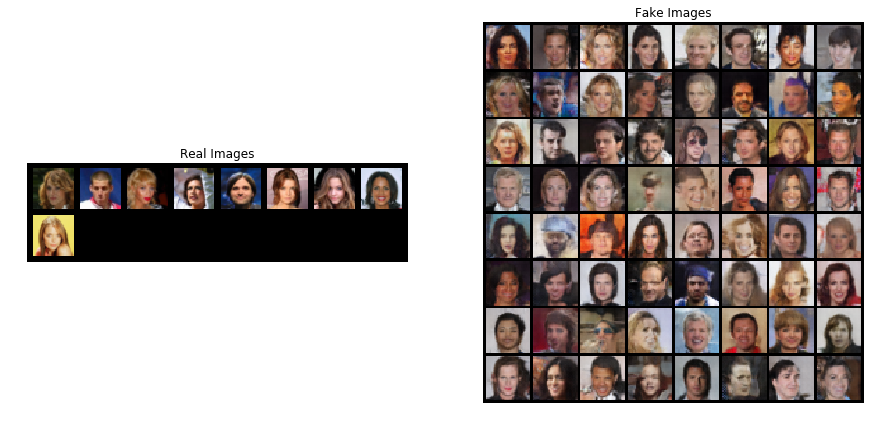

[3/5][0/22511]	Loss_D: 1.0085	Loss_G: 1.8331	D(x): 0.2899	D(G(z)): 0.7614 / 0.8360
[3/5][50/22511]	Loss_D: 1.0749	Loss_G: 1.8487	D(x): 0.1093	D(G(z)): 0.8816 / 0.8381
[3/5][100/22511]	Loss_D: 0.9545	Loss_G: 1.9622	D(x): 0.2649	D(G(z)): 0.8772 / 0.8451
[3/5][150/22511]	Loss_D: 0.8516	Loss_G: 1.7304	D(x): 0.1754	D(G(z)): 0.8109 / 0.8178
[3/5][200/22511]	Loss_D: 0.9291	Loss_G: 2.2188	D(x): 0.2870	D(G(z)): 0.7285 / 0.8866
[3/5][250/22511]	Loss_D: 0.8323	Loss_G: 1.9743	D(x): 0.0969	D(G(z)): 0.8429 / 0.8589
[3/5][300/22511]	Loss_D: 0.8992	Loss_G: 2.0758	D(x): 0.2690	D(G(z)): 0.8427 / 0.8712
[3/5][350/22511]	Loss_D: 1.0499	Loss_G: 1.5109	D(x): 0.3343	D(G(z)): 0.6806 / 0.7705
[3/5][400/22511]	Loss_D: 1.0382	Loss_G: 1.8088	D(x): 0.4624	D(G(z)): 0.8458 / 0.8307
[3/5][450/22511]	Loss_D: 1.0670	Loss_G: 2.1755	D(x): 0.4277	D(G(z)): 0.9313 / 0.8721
[3/5][500/22511]	Loss_D: 0.7918	Loss_G: 2.0622	D(x): 0.1266	D(G(z)): 0.7993 / 0.8700
[3/5][550/22511]	Loss_D: 0.8993	Loss_G: 1.7961	D(x): 0.1755	D(G(z)):

[3/5][4800/22511]	Loss_D: 1.1344	Loss_G: 1.9136	D(x): 0.1949	D(G(z)): 0.5713 / 0.8452
[3/5][4850/22511]	Loss_D: 0.9809	Loss_G: 1.6734	D(x): 0.2377	D(G(z)): 0.8177 / 0.8064
[3/5][4900/22511]	Loss_D: 0.9309	Loss_G: 1.8109	D(x): 0.1453	D(G(z)): 0.7266 / 0.8258
[3/5][4950/22511]	Loss_D: 0.8516	Loss_G: 1.9215	D(x): 0.1499	D(G(z)): 0.7159 / 0.8473
[3/5][5000/22511]	Loss_D: 0.9406	Loss_G: 2.1286	D(x): 0.3036	D(G(z)): 0.8914 / 0.8778
[3/5][5050/22511]	Loss_D: 0.8243	Loss_G: 2.1617	D(x): 0.1090	D(G(z)): 0.7763 / 0.8800
[3/5][5100/22511]	Loss_D: 1.0169	Loss_G: 1.6806	D(x): 0.1423	D(G(z)): 0.8667 / 0.8049
[3/5][5150/22511]	Loss_D: 0.9924	Loss_G: 2.1023	D(x): 0.1107	D(G(z)): 0.7083 / 0.8737
[3/5][5200/22511]	Loss_D: 0.9879	Loss_G: 1.9411	D(x): 0.1533	D(G(z)): 0.7991 / 0.8440
[3/5][5250/22511]	Loss_D: 1.0757	Loss_G: 1.8404	D(x): 0.2191	D(G(z)): 0.9033 / 0.8307
[3/5][5300/22511]	Loss_D: 0.9585	Loss_G: 2.0949	D(x): 0.3552	D(G(z)): 0.8894 / 0.8726
[3/5][5350/22511]	Loss_D: 0.8762	Loss_G: 1.6435	D(x): 

[3/5][9600/22511]	Loss_D: 0.8324	Loss_G: 2.0317	D(x): 0.1393	D(G(z)): 0.8338 / 0.8635
[3/5][9650/22511]	Loss_D: 0.8358	Loss_G: 1.8815	D(x): 0.1492	D(G(z)): 0.8198 / 0.8430
[3/5][9700/22511]	Loss_D: 0.9582	Loss_G: 1.5121	D(x): 0.3153	D(G(z)): 0.7458 / 0.7765
[3/5][9750/22511]	Loss_D: 1.0356	Loss_G: 1.6547	D(x): 0.2735	D(G(z)): 0.7437 / 0.8042
[3/5][9800/22511]	Loss_D: 0.7898	Loss_G: 2.1185	D(x): 0.1732	D(G(z)): 0.8390 / 0.8745
[3/5][9850/22511]	Loss_D: 0.8619	Loss_G: 2.3184	D(x): 0.1182	D(G(z)): 0.8807 / 0.8969
[3/5][9900/22511]	Loss_D: 0.9714	Loss_G: 1.9660	D(x): 0.1822	D(G(z)): 0.7756 / 0.8558
[3/5][9950/22511]	Loss_D: 0.9156	Loss_G: 1.8764	D(x): 0.2151	D(G(z)): 0.8592 / 0.8403
[3/5][10000/22511]	Loss_D: 0.8785	Loss_G: 2.2361	D(x): 0.1539	D(G(z)): 0.8845 / 0.8888
[3/5][10050/22511]	Loss_D: 0.9184	Loss_G: 1.6588	D(x): 0.1522	D(G(z)): 0.7645 / 0.8007
[3/5][10100/22511]	Loss_D: 1.0908	Loss_G: 2.1726	D(x): 0.0820	D(G(z)): 0.6046 / 0.8816
[3/5][10150/22511]	Loss_D: 0.8937	Loss_G: 2.0564	D(

[3/5][14350/22511]	Loss_D: 0.8993	Loss_G: 1.6990	D(x): 0.3107	D(G(z)): 0.8281 / 0.8052
[3/5][14400/22511]	Loss_D: 1.0129	Loss_G: 1.7973	D(x): 0.0551	D(G(z)): 0.7157 / 0.8289
[3/5][14450/22511]	Loss_D: 0.9509	Loss_G: 1.8830	D(x): 0.1616	D(G(z)): 0.7609 / 0.8449
[3/5][14500/22511]	Loss_D: 0.7598	Loss_G: 2.1999	D(x): 0.1867	D(G(z)): 0.8627 / 0.8808
[3/5][14550/22511]	Loss_D: 0.9583	Loss_G: 2.0735	D(x): 0.3151	D(G(z)): 0.8868 / 0.8674
[3/5][14600/22511]	Loss_D: 1.0392	Loss_G: 1.8906	D(x): 0.1338	D(G(z)): 0.5816 / 0.8449
[3/5][14650/22511]	Loss_D: 1.0470	Loss_G: 1.3128	D(x): 0.3787	D(G(z)): 0.7619 / 0.7136
[3/5][14700/22511]	Loss_D: 1.0372	Loss_G: 2.0785	D(x): 0.0580	D(G(z)): 0.7407 / 0.8723
[3/5][14750/22511]	Loss_D: 0.8890	Loss_G: 1.9320	D(x): 0.1797	D(G(z)): 0.7754 / 0.8506
[3/5][14800/22511]	Loss_D: 0.9574	Loss_G: 1.8227	D(x): 0.2117	D(G(z)): 0.6513 / 0.8317
[3/5][14850/22511]	Loss_D: 0.9006	Loss_G: 2.0274	D(x): 0.1394	D(G(z)): 0.9053 / 0.8661
[3/5][14900/22511]	Loss_D: 0.8579	Loss_G: 2

[3/5][19100/22511]	Loss_D: 0.9657	Loss_G: 2.3657	D(x): 0.1390	D(G(z)): 0.9384 / 0.8986
[3/5][19150/22511]	Loss_D: 0.9296	Loss_G: 1.7829	D(x): 0.1748	D(G(z)): 0.7943 / 0.8282
[3/5][19200/22511]	Loss_D: 0.9188	Loss_G: 1.8514	D(x): 0.1813	D(G(z)): 0.8817 / 0.8400
[3/5][19250/22511]	Loss_D: 0.7830	Loss_G: 2.7081	D(x): 0.1217	D(G(z)): 0.9212 / 0.9276
[3/5][19300/22511]	Loss_D: 0.9090	Loss_G: 1.9478	D(x): 0.3270	D(G(z)): 0.8593 / 0.8488
[3/5][19350/22511]	Loss_D: 0.8438	Loss_G: 1.7235	D(x): 0.2039	D(G(z)): 0.7491 / 0.8165
[3/5][19400/22511]	Loss_D: 0.9714	Loss_G: 2.0114	D(x): 0.1650	D(G(z)): 0.8070 / 0.8618
[3/5][19450/22511]	Loss_D: 0.7190	Loss_G: 1.9015	D(x): 0.2422	D(G(z)): 0.8536 / 0.8435
[3/5][19500/22511]	Loss_D: 1.0116	Loss_G: 1.6501	D(x): 0.2309	D(G(z)): 0.6403 / 0.7984
[3/5][19550/22511]	Loss_D: 0.9404	Loss_G: 1.9184	D(x): 0.1559	D(G(z)): 0.8507 / 0.8425
[3/5][19600/22511]	Loss_D: 0.9439	Loss_G: 1.6675	D(x): 0.2866	D(G(z)): 0.7944 / 0.8081
[3/5][19650/22511]	Loss_D: 0.9540	Loss_G: 1

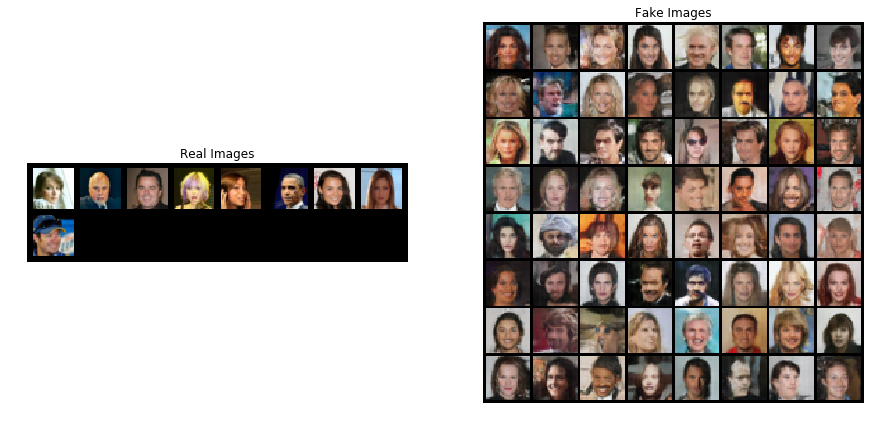

[4/5][0/22511]	Loss_D: 0.9010	Loss_G: 1.8352	D(x): 0.0711	D(G(z)): 0.7798 / 0.8357
[4/5][50/22511]	Loss_D: 0.8387	Loss_G: 2.0008	D(x): 0.1025	D(G(z)): 0.8451 / 0.8566
[4/5][100/22511]	Loss_D: 0.9453	Loss_G: 1.8368	D(x): 0.2051	D(G(z)): 0.8751 / 0.8346
[4/5][150/22511]	Loss_D: 0.8670	Loss_G: 1.7175	D(x): 0.1749	D(G(z)): 0.8373 / 0.8176
[4/5][200/22511]	Loss_D: 1.0108	Loss_G: 1.4055	D(x): 0.2301	D(G(z)): 0.7073 / 0.7494
[4/5][250/22511]	Loss_D: 0.8869	Loss_G: 1.9007	D(x): 0.1538	D(G(z)): 0.8031 / 0.8448
[4/5][300/22511]	Loss_D: 0.7632	Loss_G: 1.9899	D(x): 0.2001	D(G(z)): 0.8234 / 0.8551
[4/5][350/22511]	Loss_D: 0.9833	Loss_G: 1.7783	D(x): 0.0868	D(G(z)): 0.7972 / 0.8235
[4/5][400/22511]	Loss_D: 0.8352	Loss_G: 2.0638	D(x): 0.1075	D(G(z)): 0.7118 / 0.8690
[4/5][450/22511]	Loss_D: 1.0350	Loss_G: 1.9034	D(x): 0.3674	D(G(z)): 0.8184 / 0.8447
[4/5][500/22511]	Loss_D: 0.9634	Loss_G: 2.3380	D(x): 0.0426	D(G(z)): 0.7409 / 0.9006
[4/5][550/22511]	Loss_D: 0.9805	Loss_G: 2.1109	D(x): 0.1328	D(G(z)):

[4/5][4800/22511]	Loss_D: 1.1196	Loss_G: 1.8288	D(x): 0.1179	D(G(z)): 0.5544 / 0.8326
[4/5][4850/22511]	Loss_D: 0.8428	Loss_G: 2.0736	D(x): 0.1800	D(G(z)): 0.8095 / 0.8663
[4/5][4900/22511]	Loss_D: 0.8127	Loss_G: 1.9473	D(x): 0.2733	D(G(z)): 0.8583 / 0.8531
[4/5][4950/22511]	Loss_D: 1.0553	Loss_G: 1.9403	D(x): 0.2603	D(G(z)): 0.5816 / 0.8534
[4/5][5000/22511]	Loss_D: 0.8084	Loss_G: 1.9869	D(x): 0.2142	D(G(z)): 0.7804 / 0.8549
[4/5][5050/22511]	Loss_D: 0.9946	Loss_G: 1.7682	D(x): 0.1268	D(G(z)): 0.8805 / 0.8246
[4/5][5100/22511]	Loss_D: 1.0202	Loss_G: 1.7436	D(x): 0.2461	D(G(z)): 0.9082 / 0.8125
[4/5][5150/22511]	Loss_D: 1.0289	Loss_G: 1.6623	D(x): 0.1203	D(G(z)): 0.6752 / 0.8064
[4/5][5200/22511]	Loss_D: 0.9319	Loss_G: 1.7954	D(x): 0.1885	D(G(z)): 0.7780 / 0.8277
[4/5][5250/22511]	Loss_D: 0.9505	Loss_G: 2.0588	D(x): 0.2898	D(G(z)): 0.9211 / 0.8643
[4/5][5300/22511]	Loss_D: 0.8080	Loss_G: 1.6672	D(x): 0.2589	D(G(z)): 0.8016 / 0.8081
[4/5][5350/22511]	Loss_D: 0.9053	Loss_G: 2.2563	D(x): 

[4/5][9600/22511]	Loss_D: 0.9196	Loss_G: 1.7155	D(x): 0.0997	D(G(z)): 0.6872 / 0.8146
[4/5][9650/22511]	Loss_D: 0.9277	Loss_G: 2.3435	D(x): 0.1042	D(G(z)): 0.9041 / 0.8995
[4/5][9700/22511]	Loss_D: 0.9382	Loss_G: 2.4093	D(x): 0.0990	D(G(z)): 0.7157 / 0.9085
[4/5][9750/22511]	Loss_D: 0.9398	Loss_G: 2.0302	D(x): 0.2250	D(G(z)): 0.8713 / 0.8656
[4/5][9800/22511]	Loss_D: 0.8724	Loss_G: 1.8621	D(x): 0.1699	D(G(z)): 0.8719 / 0.8404
[4/5][9850/22511]	Loss_D: 1.0258	Loss_G: 1.6325	D(x): 0.4127	D(G(z)): 0.7143 / 0.7938
[4/5][9900/22511]	Loss_D: 1.1966	Loss_G: 1.8362	D(x): 0.5422	D(G(z)): 0.8102 / 0.8381
[4/5][9950/22511]	Loss_D: 0.9190	Loss_G: 2.0394	D(x): 0.1203	D(G(z)): 0.5843 / 0.8693
[4/5][10000/22511]	Loss_D: 0.8561	Loss_G: 2.5246	D(x): 0.0882	D(G(z)): 0.8945 / 0.9148
[4/5][10050/22511]	Loss_D: 1.0186	Loss_G: 1.8223	D(x): 0.2623	D(G(z)): 0.8773 / 0.8361
[4/5][10100/22511]	Loss_D: 1.2154	Loss_G: 1.5479	D(x): 0.5241	D(G(z)): 0.8506 / 0.7848
[4/5][10150/22511]	Loss_D: 0.7770	Loss_G: 2.1044	D(

[4/5][14350/22511]	Loss_D: 0.9770	Loss_G: 1.6694	D(x): 0.2292	D(G(z)): 0.6994 / 0.8046
[4/5][14400/22511]	Loss_D: 0.8941	Loss_G: 1.9482	D(x): 0.2537	D(G(z)): 0.8736 / 0.8527
[4/5][14450/22511]	Loss_D: 0.8315	Loss_G: 2.0588	D(x): 0.2054	D(G(z)): 0.8275 / 0.8707
[4/5][14500/22511]	Loss_D: 0.9803	Loss_G: 1.7007	D(x): 0.1713	D(G(z)): 0.7808 / 0.8050
[4/5][14550/22511]	Loss_D: 1.0152	Loss_G: 1.7857	D(x): 0.2535	D(G(z)): 0.7287 / 0.8288
[4/5][14600/22511]	Loss_D: 1.0727	Loss_G: 1.6660	D(x): 0.3795	D(G(z)): 0.8812 / 0.7987
[4/5][14650/22511]	Loss_D: 0.9430	Loss_G: 2.0465	D(x): 0.1103	D(G(z)): 0.7306 / 0.8660
[4/5][14700/22511]	Loss_D: 0.9532	Loss_G: 1.6342	D(x): 0.2862	D(G(z)): 0.8170 / 0.7954
[4/5][14750/22511]	Loss_D: 0.8677	Loss_G: 2.3402	D(x): 0.2590	D(G(z)): 0.9089 / 0.9003
[4/5][14800/22511]	Loss_D: 0.8956	Loss_G: 1.9754	D(x): 0.1364	D(G(z)): 0.7367 / 0.8599
[4/5][14850/22511]	Loss_D: 0.9641	Loss_G: 2.0422	D(x): 0.1700	D(G(z)): 0.7328 / 0.8632
[4/5][14900/22511]	Loss_D: 1.0129	Loss_G: 1

[4/5][19100/22511]	Loss_D: 1.1464	Loss_G: 1.6400	D(x): 0.3811	D(G(z)): 0.8886 / 0.8012
[4/5][19150/22511]	Loss_D: 0.8444	Loss_G: 2.0547	D(x): 0.1951	D(G(z)): 0.7567 / 0.8661
[4/5][19200/22511]	Loss_D: 0.9098	Loss_G: 1.6034	D(x): 0.2309	D(G(z)): 0.7455 / 0.7964
[4/5][19250/22511]	Loss_D: 0.9422	Loss_G: 2.3124	D(x): 0.0890	D(G(z)): 0.8095 / 0.8922
[4/5][19300/22511]	Loss_D: 1.4208	Loss_G: 1.4502	D(x): 0.6421	D(G(z)): 0.7795 / 0.7556
[4/5][19350/22511]	Loss_D: 1.0522	Loss_G: 1.5710	D(x): 0.4444	D(G(z)): 0.7801 / 0.7834
[4/5][19400/22511]	Loss_D: 0.9516	Loss_G: 1.5763	D(x): 0.2511	D(G(z)): 0.7781 / 0.7865
[4/5][19450/22511]	Loss_D: 0.8931	Loss_G: 1.9909	D(x): 0.2166	D(G(z)): 0.8330 / 0.8588
[4/5][19500/22511]	Loss_D: 0.9751	Loss_G: 1.6904	D(x): 0.2326	D(G(z)): 0.8681 / 0.8117
[4/5][19550/22511]	Loss_D: 0.8315	Loss_G: 1.9784	D(x): 0.2390	D(G(z)): 0.7862 / 0.8581
[4/5][19600/22511]	Loss_D: 0.9809	Loss_G: 2.1334	D(x): 0.1676	D(G(z)): 0.6233 / 0.8804
[4/5][19650/22511]	Loss_D: 0.9582	Loss_G: 2

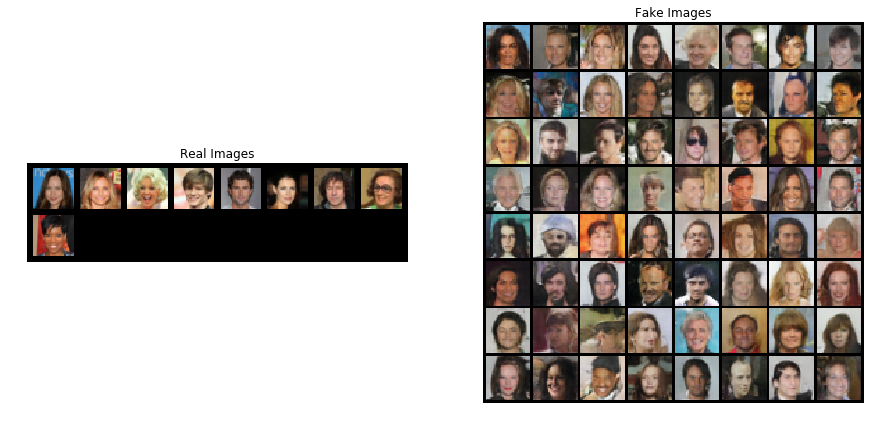

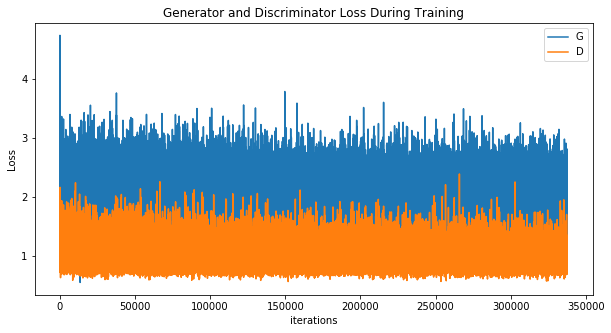

[0/5][0/22511]	Loss_D: 1.0481	Loss_G: 1.9777	D(x): 0.1263	D(G(z)): 0.6061 / 0.8568
[0/5][50/22511]	Loss_D: 1.0839	Loss_G: 1.6944	D(x): 0.1404	D(G(z)): 0.8195 / 0.8110
[0/5][100/22511]	Loss_D: 0.8821	Loss_G: 2.0325	D(x): 0.1662	D(G(z)): 0.8544 / 0.8577
[0/5][150/22511]	Loss_D: 0.9170	Loss_G: 2.1072	D(x): 0.1853	D(G(z)): 0.9045 / 0.8648
[0/5][200/22511]	Loss_D: 0.8395	Loss_G: 1.8111	D(x): 0.1054	D(G(z)): 0.7554 / 0.8298
[0/5][250/22511]	Loss_D: 1.1739	Loss_G: 2.7322	D(x): 0.0824	D(G(z)): 0.5134 / 0.9309
[0/5][300/22511]	Loss_D: 0.9463	Loss_G: 1.6304	D(x): 0.3077	D(G(z)): 0.8768 / 0.7932
[0/5][350/22511]	Loss_D: 0.9143	Loss_G: 2.3641	D(x): 0.0894	D(G(z)): 0.9071 / 0.9014
[0/5][400/22511]	Loss_D: 0.9571	Loss_G: 1.9231	D(x): 0.2853	D(G(z)): 0.7582 / 0.8464
[0/5][450/22511]	Loss_D: 0.8134	Loss_G: 2.0026	D(x): 0.1990	D(G(z)): 0.8430 / 0.8593
[0/5][500/22511]	Loss_D: 0.8435	Loss_G: 2.0991	D(x): 0.1961	D(G(z)): 0.8929 / 0.8696
[0/5][550/22511]	Loss_D: 0.9832	Loss_G: 1.5869	D(x): 0.3045	D(G(z)):

[0/5][4800/22511]	Loss_D: 0.7319	Loss_G: 2.2569	D(x): 0.1403	D(G(z)): 0.7616 / 0.8902
[0/5][4850/22511]	Loss_D: 0.9022	Loss_G: 1.8311	D(x): 0.2219	D(G(z)): 0.8358 / 0.8323
[0/5][4900/22511]	Loss_D: 0.8841	Loss_G: 1.9517	D(x): 0.1430	D(G(z)): 0.8433 / 0.8504
[0/5][4950/22511]	Loss_D: 0.8098	Loss_G: 1.8096	D(x): 0.1194	D(G(z)): 0.7783 / 0.8286
[0/5][5000/22511]	Loss_D: 0.9211	Loss_G: 1.6596	D(x): 0.2724	D(G(z)): 0.8441 / 0.8000
[0/5][5050/22511]	Loss_D: 0.8995	Loss_G: 2.0210	D(x): 0.1111	D(G(z)): 0.7788 / 0.8629
[0/5][5100/22511]	Loss_D: 0.8797	Loss_G: 1.8016	D(x): 0.0898	D(G(z)): 0.6873 / 0.8258
[0/5][5150/22511]	Loss_D: 1.0757	Loss_G: 2.3979	D(x): 0.1160	D(G(z)): 0.9330 / 0.9032
[0/5][5200/22511]	Loss_D: 0.8130	Loss_G: 2.1542	D(x): 0.1799	D(G(z)): 0.7694 / 0.8806
[0/5][5250/22511]	Loss_D: 1.0688	Loss_G: 1.3862	D(x): 0.4146	D(G(z)): 0.8325 / 0.7463
[0/5][5300/22511]	Loss_D: 0.8759	Loss_G: 2.0018	D(x): 0.2696	D(G(z)): 0.8402 / 0.8619
[0/5][5350/22511]	Loss_D: 0.8893	Loss_G: 1.9757	D(x): 

[0/5][9600/22511]	Loss_D: 0.8631	Loss_G: 2.0696	D(x): 0.1399	D(G(z)): 0.8916 / 0.8680
[0/5][9650/22511]	Loss_D: 0.8963	Loss_G: 2.1776	D(x): 0.1732	D(G(z)): 0.7489 / 0.8821
[0/5][9700/22511]	Loss_D: 1.0189	Loss_G: 1.7257	D(x): 0.4186	D(G(z)): 0.8272 / 0.8203
[0/5][9750/22511]	Loss_D: 0.9500	Loss_G: 2.0563	D(x): 0.1144	D(G(z)): 0.8785 / 0.8694
[0/5][9800/22511]	Loss_D: 0.7714	Loss_G: 2.1118	D(x): 0.0907	D(G(z)): 0.7944 / 0.8770
[0/5][9850/22511]	Loss_D: 0.7999	Loss_G: 1.7119	D(x): 0.1259	D(G(z)): 0.7738 / 0.8127
[0/5][9900/22511]	Loss_D: 0.8946	Loss_G: 2.1793	D(x): 0.3397	D(G(z)): 0.9178 / 0.8822
[0/5][9950/22511]	Loss_D: 0.9158	Loss_G: 1.8890	D(x): 0.3482	D(G(z)): 0.7922 / 0.8407
[0/5][10000/22511]	Loss_D: 0.8281	Loss_G: 1.8694	D(x): 0.2422	D(G(z)): 0.8920 / 0.8403
[0/5][10050/22511]	Loss_D: 0.9616	Loss_G: 1.6203	D(x): 0.3177	D(G(z)): 0.8474 / 0.7960
[0/5][10100/22511]	Loss_D: 0.9508	Loss_G: 1.5924	D(x): 0.2672	D(G(z)): 0.8173 / 0.7928
[0/5][10150/22511]	Loss_D: 0.9137	Loss_G: 1.9139	D(

[0/5][14350/22511]	Loss_D: 0.9062	Loss_G: 1.5439	D(x): 0.2787	D(G(z)): 0.8343 / 0.7813
[0/5][14400/22511]	Loss_D: 0.9447	Loss_G: 1.9852	D(x): 0.1184	D(G(z)): 0.7744 / 0.8540
[0/5][14450/22511]	Loss_D: 0.8896	Loss_G: 2.4790	D(x): 0.1200	D(G(z)): 0.9136 / 0.9087
[0/5][14500/22511]	Loss_D: 0.9190	Loss_G: 1.8876	D(x): 0.0770	D(G(z)): 0.8535 / 0.8438
[0/5][14550/22511]	Loss_D: 0.9874	Loss_G: 1.5850	D(x): 0.3303	D(G(z)): 0.7889 / 0.7834
[0/5][14600/22511]	Loss_D: 0.9020	Loss_G: 1.7819	D(x): 0.1100	D(G(z)): 0.7736 / 0.8276
[0/5][14650/22511]	Loss_D: 1.0257	Loss_G: 1.5357	D(x): 0.0764	D(G(z)): 0.8149 / 0.7796
[0/5][14700/22511]	Loss_D: 0.9602	Loss_G: 2.1624	D(x): 0.2979	D(G(z)): 0.9064 / 0.8736
[0/5][14750/22511]	Loss_D: 0.8816	Loss_G: 1.7560	D(x): 0.1599	D(G(z)): 0.8368 / 0.8188
[0/5][14800/22511]	Loss_D: 0.8700	Loss_G: 1.6488	D(x): 0.1860	D(G(z)): 0.7843 / 0.7987
[0/5][14850/22511]	Loss_D: 1.0696	Loss_G: 1.9089	D(x): 0.4252	D(G(z)): 0.8668 / 0.8452
[0/5][14900/22511]	Loss_D: 0.9511	Loss_G: 1

[0/5][19100/22511]	Loss_D: 1.0229	Loss_G: 1.6485	D(x): 0.3213	D(G(z)): 0.8581 / 0.8005
[0/5][19150/22511]	Loss_D: 1.1105	Loss_G: 1.9403	D(x): 0.1714	D(G(z)): 0.6012 / 0.8510
[0/5][19200/22511]	Loss_D: 0.9149	Loss_G: 2.0096	D(x): 0.2365	D(G(z)): 0.8624 / 0.8604
[0/5][19250/22511]	Loss_D: 0.8999	Loss_G: 1.9110	D(x): 0.2384	D(G(z)): 0.7892 / 0.8467
[0/5][19300/22511]	Loss_D: 0.8045	Loss_G: 2.1425	D(x): 0.1719	D(G(z)): 0.8296 / 0.8799
[0/5][19350/22511]	Loss_D: 0.8412	Loss_G: 1.9573	D(x): 0.0725	D(G(z)): 0.7296 / 0.8522
[0/5][19400/22511]	Loss_D: 0.8569	Loss_G: 1.7985	D(x): 0.2232	D(G(z)): 0.7551 / 0.8298
[0/5][19450/22511]	Loss_D: 1.0907	Loss_G: 1.4712	D(x): 0.3498	D(G(z)): 0.6711 / 0.7634
[0/5][19500/22511]	Loss_D: 0.8317	Loss_G: 1.8647	D(x): 0.1245	D(G(z)): 0.8109 / 0.8381
[0/5][19550/22511]	Loss_D: 1.0661	Loss_G: 1.7628	D(x): 0.4194	D(G(z)): 0.8913 / 0.8209
[0/5][19600/22511]	Loss_D: 0.8649	Loss_G: 2.0197	D(x): 0.1332	D(G(z)): 0.8601 / 0.8556
[0/5][19650/22511]	Loss_D: 0.9233	Loss_G: 1

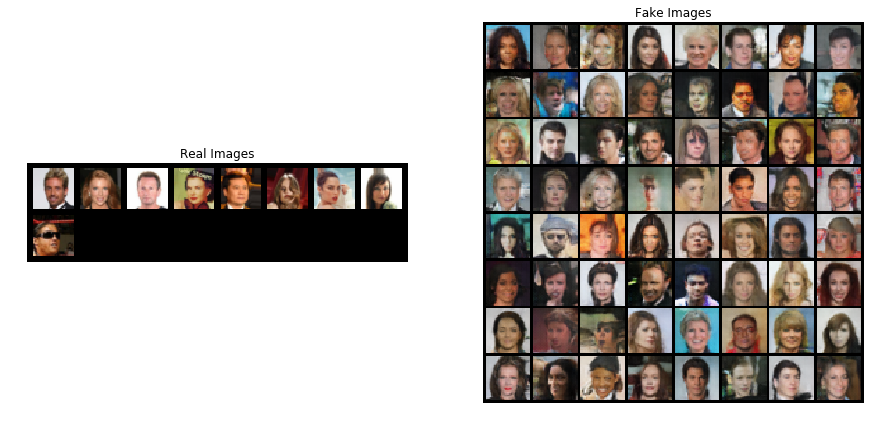

[1/5][0/22511]	Loss_D: 1.0580	Loss_G: 1.8475	D(x): 0.1997	D(G(z)): 0.9159 / 0.8331
[1/5][50/22511]	Loss_D: 0.9488	Loss_G: 1.8758	D(x): 0.1598	D(G(z)): 0.8687 / 0.8408
[1/5][100/22511]	Loss_D: 0.9892	Loss_G: 1.7894	D(x): 0.2951	D(G(z)): 0.7477 / 0.8299
[1/5][150/22511]	Loss_D: 1.1250	Loss_G: 1.9936	D(x): 0.0461	D(G(z)): 0.7719 / 0.8608
[1/5][200/22511]	Loss_D: 1.0608	Loss_G: 2.1411	D(x): 0.0822	D(G(z)): 0.6580 / 0.8749
[1/5][250/22511]	Loss_D: 1.0670	Loss_G: 1.7906	D(x): 0.3956	D(G(z)): 0.7449 / 0.8246
[1/5][300/22511]	Loss_D: 0.8254	Loss_G: 1.5726	D(x): 0.1519	D(G(z)): 0.7561 / 0.7783
[1/5][350/22511]	Loss_D: 0.7639	Loss_G: 2.1361	D(x): 0.0874	D(G(z)): 0.7973 / 0.8768
[1/5][400/22511]	Loss_D: 1.0924	Loss_G: 2.1847	D(x): 0.1093	D(G(z)): 0.5072 / 0.8798
[1/5][450/22511]	Loss_D: 1.0032	Loss_G: 1.7811	D(x): 0.4158	D(G(z)): 0.8449 / 0.8239
[1/5][500/22511]	Loss_D: 0.9862	Loss_G: 1.6299	D(x): 0.2252	D(G(z)): 0.6766 / 0.8017
[1/5][550/22511]	Loss_D: 0.8831	Loss_G: 2.4101	D(x): 0.2337	D(G(z)):

[1/5][4800/22511]	Loss_D: 0.9319	Loss_G: 1.6305	D(x): 0.1213	D(G(z)): 0.7951 / 0.8013
[1/5][4850/22511]	Loss_D: 0.9629	Loss_G: 2.2472	D(x): 0.3095	D(G(z)): 0.9378 / 0.8871
[1/5][4900/22511]	Loss_D: 1.0282	Loss_G: 1.7342	D(x): 0.0328	D(G(z)): 0.7674 / 0.8171
[1/5][4950/22511]	Loss_D: 1.0492	Loss_G: 1.7572	D(x): 0.4015	D(G(z)): 0.7632 / 0.8231
[1/5][5000/22511]	Loss_D: 0.9669	Loss_G: 2.1261	D(x): 0.0987	D(G(z)): 0.7722 / 0.8774
[1/5][5050/22511]	Loss_D: 0.9926	Loss_G: 2.1398	D(x): 0.3875	D(G(z)): 0.9081 / 0.8787
[1/5][5100/22511]	Loss_D: 1.0124	Loss_G: 2.0490	D(x): 0.3114	D(G(z)): 0.9043 / 0.8549
[1/5][5150/22511]	Loss_D: 0.7210	Loss_G: 2.2558	D(x): 0.0884	D(G(z)): 0.8630 / 0.8914
[1/5][5200/22511]	Loss_D: 0.9322	Loss_G: 1.6425	D(x): 0.3166	D(G(z)): 0.7864 / 0.7995
[1/5][5250/22511]	Loss_D: 1.1029	Loss_G: 1.8129	D(x): 0.4758	D(G(z)): 0.8744 / 0.8300
[1/5][5300/22511]	Loss_D: 0.9210	Loss_G: 2.1084	D(x): 0.1456	D(G(z)): 0.8716 / 0.8704
[1/5][5350/22511]	Loss_D: 0.9529	Loss_G: 2.2012	D(x): 

[1/5][9600/22511]	Loss_D: 1.0140	Loss_G: 1.8384	D(x): 0.0752	D(G(z)): 0.8612 / 0.8325
[1/5][9650/22511]	Loss_D: 1.0574	Loss_G: 1.7683	D(x): 0.0925	D(G(z)): 0.5894 / 0.8234
[1/5][9700/22511]	Loss_D: 0.8026	Loss_G: 1.7856	D(x): 0.1703	D(G(z)): 0.7967 / 0.8307
[1/5][9750/22511]	Loss_D: 1.0456	Loss_G: 2.1625	D(x): 0.0921	D(G(z)): 0.8313 / 0.8755
[1/5][9800/22511]	Loss_D: 0.9555	Loss_G: 1.7008	D(x): 0.1688	D(G(z)): 0.7856 / 0.8147
[1/5][9850/22511]	Loss_D: 0.9670	Loss_G: 1.9038	D(x): 0.1391	D(G(z)): 0.8880 / 0.8422
[1/5][9900/22511]	Loss_D: 0.9428	Loss_G: 1.8412	D(x): 0.1734	D(G(z)): 0.7813 / 0.8383
[1/5][9950/22511]	Loss_D: 0.7630	Loss_G: 1.7975	D(x): 0.1867	D(G(z)): 0.8374 / 0.8272
[1/5][10000/22511]	Loss_D: 0.8476	Loss_G: 2.3725	D(x): 0.1358	D(G(z)): 0.8475 / 0.9021
[1/5][10050/22511]	Loss_D: 0.8053	Loss_G: 1.9527	D(x): 0.0902	D(G(z)): 0.7923 / 0.8457
[1/5][10100/22511]	Loss_D: 1.1770	Loss_G: 2.2652	D(x): 0.0678	D(G(z)): 0.5880 / 0.8945
[1/5][10150/22511]	Loss_D: 1.0025	Loss_G: 1.6446	D(

[1/5][14350/22511]	Loss_D: 1.1757	Loss_G: 2.0402	D(x): 0.4941	D(G(z)): 0.9397 / 0.8672
[1/5][14400/22511]	Loss_D: 0.9189	Loss_G: 2.0231	D(x): 0.2698	D(G(z)): 0.8805 / 0.8582
[1/5][14450/22511]	Loss_D: 0.8661	Loss_G: 2.2284	D(x): 0.1700	D(G(z)): 0.8240 / 0.8908
[1/5][14500/22511]	Loss_D: 0.9750	Loss_G: 2.0489	D(x): 0.2877	D(G(z)): 0.9155 / 0.8649
[1/5][14550/22511]	Loss_D: 1.3278	Loss_G: 1.8407	D(x): 0.6599	D(G(z)): 0.9353 / 0.8383
[1/5][14600/22511]	Loss_D: 0.8147	Loss_G: 1.9784	D(x): 0.2034	D(G(z)): 0.8324 / 0.8586
[1/5][14650/22511]	Loss_D: 0.8349	Loss_G: 2.1261	D(x): 0.0975	D(G(z)): 0.9050 / 0.8721
[1/5][14700/22511]	Loss_D: 1.0002	Loss_G: 1.7038	D(x): 0.3170	D(G(z)): 0.7064 / 0.8115
[1/5][14750/22511]	Loss_D: 1.0524	Loss_G: 1.8152	D(x): 0.4637	D(G(z)): 0.7720 / 0.8330
[1/5][14800/22511]	Loss_D: 0.8869	Loss_G: 1.6259	D(x): 0.1560	D(G(z)): 0.7816 / 0.8002
[1/5][14850/22511]	Loss_D: 0.9717	Loss_G: 2.2181	D(x): 0.2539	D(G(z)): 0.6398 / 0.8858
[1/5][14900/22511]	Loss_D: 0.9423	Loss_G: 1

[1/5][19100/22511]	Loss_D: 0.9309	Loss_G: 2.0523	D(x): 0.0924	D(G(z)): 0.8026 / 0.8692
[1/5][19150/22511]	Loss_D: 0.9514	Loss_G: 2.0566	D(x): 0.0720	D(G(z)): 0.6826 / 0.8679
[1/5][19200/22511]	Loss_D: 1.0502	Loss_G: 2.7210	D(x): 0.4386	D(G(z)): 0.9603 / 0.9288
[1/5][19250/22511]	Loss_D: 1.1040	Loss_G: 1.6600	D(x): 0.4959	D(G(z)): 0.8631 / 0.8062
[1/5][19300/22511]	Loss_D: 0.9164	Loss_G: 1.7749	D(x): 0.2569	D(G(z)): 0.8040 / 0.8252
[1/5][19350/22511]	Loss_D: 0.8270	Loss_G: 1.9617	D(x): 0.1910	D(G(z)): 0.7997 / 0.8562
[1/5][19400/22511]	Loss_D: 0.9939	Loss_G: 2.0194	D(x): 0.2538	D(G(z)): 0.9083 / 0.8546
[1/5][19450/22511]	Loss_D: 1.0570	Loss_G: 1.8585	D(x): 0.4093	D(G(z)): 0.8774 / 0.8285
[1/5][19500/22511]	Loss_D: 0.9259	Loss_G: 1.9347	D(x): 0.3537	D(G(z)): 0.8576 / 0.8526
[1/5][19550/22511]	Loss_D: 0.8996	Loss_G: 2.5005	D(x): 0.2452	D(G(z)): 0.9420 / 0.9101
[1/5][19600/22511]	Loss_D: 1.2106	Loss_G: 2.2662	D(x): 0.2421	D(G(z)): 0.4750 / 0.8932
[1/5][19650/22511]	Loss_D: 0.7883	Loss_G: 2

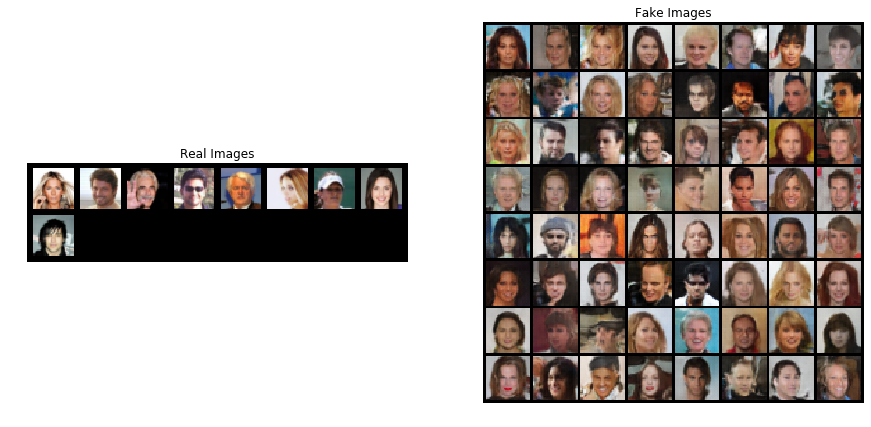

[2/5][0/22511]	Loss_D: 0.9816	Loss_G: 2.0893	D(x): 0.1471	D(G(z)): 0.6844 / 0.8718
[2/5][50/22511]	Loss_D: 0.9673	Loss_G: 1.8747	D(x): 0.0905	D(G(z)): 0.6740 / 0.8439
[2/5][100/22511]	Loss_D: 1.1883	Loss_G: 1.5875	D(x): 0.5193	D(G(z)): 0.8007 / 0.7918
[2/5][150/22511]	Loss_D: 0.9492	Loss_G: 1.9511	D(x): 0.1285	D(G(z)): 0.6609 / 0.8547
[2/5][200/22511]	Loss_D: 0.8934	Loss_G: 1.8318	D(x): 0.1626	D(G(z)): 0.7881 / 0.8296
[2/5][250/22511]	Loss_D: 0.8445	Loss_G: 1.9091	D(x): 0.1569	D(G(z)): 0.8203 / 0.8429
[2/5][300/22511]	Loss_D: 0.9503	Loss_G: 2.0646	D(x): 0.0703	D(G(z)): 0.7866 / 0.8643
[2/5][350/22511]	Loss_D: 0.9264	Loss_G: 2.1354	D(x): 0.2098	D(G(z)): 0.8981 / 0.8797
[2/5][400/22511]	Loss_D: 0.8090	Loss_G: 1.8220	D(x): 0.2412	D(G(z)): 0.8677 / 0.8317
[2/5][450/22511]	Loss_D: 0.9934	Loss_G: 1.9809	D(x): 0.0586	D(G(z)): 0.8284 / 0.8562
[2/5][500/22511]	Loss_D: 0.8211	Loss_G: 1.7183	D(x): 0.1632	D(G(z)): 0.7539 / 0.8132
[2/5][550/22511]	Loss_D: 0.8915	Loss_G: 2.0781	D(x): 0.1714	D(G(z)):

[2/5][4800/22511]	Loss_D: 0.8744	Loss_G: 1.8268	D(x): 0.1787	D(G(z)): 0.7461 / 0.8336
[2/5][4850/22511]	Loss_D: 0.9459	Loss_G: 2.0129	D(x): 0.2401	D(G(z)): 0.7182 / 0.8611
[2/5][4900/22511]	Loss_D: 0.8625	Loss_G: 1.8040	D(x): 0.2193	D(G(z)): 0.8499 / 0.8293
[2/5][4950/22511]	Loss_D: 0.9214	Loss_G: 1.5717	D(x): 0.0927	D(G(z)): 0.6759 / 0.7893
[2/5][5000/22511]	Loss_D: 1.2335	Loss_G: 1.4591	D(x): 0.5593	D(G(z)): 0.8539 / 0.7511
[2/5][5050/22511]	Loss_D: 1.0328	Loss_G: 2.5208	D(x): 0.0594	D(G(z)): 0.9168 / 0.9158
[2/5][5100/22511]	Loss_D: 1.1211	Loss_G: 1.7666	D(x): 0.5237	D(G(z)): 0.8769 / 0.8250
[2/5][5150/22511]	Loss_D: 0.9725	Loss_G: 2.1386	D(x): 0.2807	D(G(z)): 0.9353 / 0.8787
[2/5][5200/22511]	Loss_D: 1.1224	Loss_G: 2.4257	D(x): 0.5577	D(G(z)): 0.9447 / 0.9048
[2/5][5250/22511]	Loss_D: 0.8956	Loss_G: 1.7502	D(x): 0.2230	D(G(z)): 0.8105 / 0.8197
[2/5][5300/22511]	Loss_D: 0.8793	Loss_G: 2.1133	D(x): 0.1767	D(G(z)): 0.6422 / 0.8767
[2/5][5350/22511]	Loss_D: 0.9814	Loss_G: 1.8911	D(x): 

[2/5][9600/22511]	Loss_D: 0.8225	Loss_G: 1.9188	D(x): 0.1064	D(G(z)): 0.8198 / 0.8498
[2/5][9650/22511]	Loss_D: 0.8760	Loss_G: 1.7725	D(x): 0.2095	D(G(z)): 0.8705 / 0.8220
[2/5][9700/22511]	Loss_D: 0.8693	Loss_G: 2.1208	D(x): 0.0739	D(G(z)): 0.7406 / 0.8764
[2/5][9750/22511]	Loss_D: 0.8402	Loss_G: 1.9492	D(x): 0.1209	D(G(z)): 0.6869 / 0.8544
[2/5][9800/22511]	Loss_D: 0.9240	Loss_G: 1.9540	D(x): 0.0550	D(G(z)): 0.7453 / 0.8534
[2/5][9850/22511]	Loss_D: 0.9092	Loss_G: 1.5779	D(x): 0.1826	D(G(z)): 0.7991 / 0.7885
[2/5][9900/22511]	Loss_D: 0.9028	Loss_G: 2.0680	D(x): 0.1363	D(G(z)): 0.6847 / 0.8693
[2/5][9950/22511]	Loss_D: 0.9865	Loss_G: 1.8957	D(x): 0.1288	D(G(z)): 0.6357 / 0.8476
[2/5][10000/22511]	Loss_D: 0.7784	Loss_G: 2.0794	D(x): 0.1720	D(G(z)): 0.8425 / 0.8702
[2/5][10050/22511]	Loss_D: 0.9630	Loss_G: 1.5742	D(x): 0.2590	D(G(z)): 0.7827 / 0.7872
[2/5][10100/22511]	Loss_D: 1.0170	Loss_G: 1.7881	D(x): 0.2407	D(G(z)): 0.8329 / 0.8186
[2/5][10150/22511]	Loss_D: 0.8453	Loss_G: 1.7135	D(

[2/5][14350/22511]	Loss_D: 0.9907	Loss_G: 2.2385	D(x): 0.0774	D(G(z)): 0.7435 / 0.8890
[2/5][14400/22511]	Loss_D: 0.8551	Loss_G: 1.8707	D(x): 0.1250	D(G(z)): 0.7820 / 0.8337
[2/5][14450/22511]	Loss_D: 0.7886	Loss_G: 1.9974	D(x): 0.2289	D(G(z)): 0.8617 / 0.8605
[2/5][14500/22511]	Loss_D: 0.9370	Loss_G: 2.1873	D(x): 0.1031	D(G(z)): 0.6245 / 0.8849
[2/5][14550/22511]	Loss_D: 0.9741	Loss_G: 1.8792	D(x): 0.1377	D(G(z)): 0.8809 / 0.8381
[2/5][14600/22511]	Loss_D: 0.8548	Loss_G: 1.8047	D(x): 0.1478	D(G(z)): 0.7936 / 0.8269
[2/5][14650/22511]	Loss_D: 0.9496	Loss_G: 1.9326	D(x): 0.1802	D(G(z)): 0.8141 / 0.8523
[2/5][14700/22511]	Loss_D: 0.9960	Loss_G: 1.7336	D(x): 0.1633	D(G(z)): 0.7187 / 0.8155
[2/5][14750/22511]	Loss_D: 0.9248	Loss_G: 2.2633	D(x): 0.2306	D(G(z)): 0.8830 / 0.8908
[2/5][14800/22511]	Loss_D: 0.8397	Loss_G: 2.0839	D(x): 0.0901	D(G(z)): 0.8259 / 0.8677
[2/5][14850/22511]	Loss_D: 1.1421	Loss_G: 1.8430	D(x): 0.3957	D(G(z)): 0.8950 / 0.8344
[2/5][14900/22511]	Loss_D: 0.8207	Loss_G: 2

[2/5][19100/22511]	Loss_D: 0.8743	Loss_G: 1.8292	D(x): 0.3263	D(G(z)): 0.8358 / 0.8318
[2/5][19150/22511]	Loss_D: 1.0460	Loss_G: 1.4937	D(x): 0.3732	D(G(z)): 0.7802 / 0.7675
[2/5][19200/22511]	Loss_D: 0.9360	Loss_G: 2.2220	D(x): 0.3386	D(G(z)): 0.9240 / 0.8866
[2/5][19250/22511]	Loss_D: 1.0031	Loss_G: 1.8146	D(x): 0.0972	D(G(z)): 0.6655 / 0.8316
[2/5][19300/22511]	Loss_D: 0.8628	Loss_G: 1.9549	D(x): 0.1028	D(G(z)): 0.7850 / 0.8541
[2/5][19350/22511]	Loss_D: 0.9182	Loss_G: 2.2007	D(x): 0.1614	D(G(z)): 0.9063 / 0.8836
[2/5][19400/22511]	Loss_D: 0.8845	Loss_G: 2.0468	D(x): 0.0964	D(G(z)): 0.7576 / 0.8675
[2/5][19450/22511]	Loss_D: 1.0119	Loss_G: 1.8216	D(x): 0.0840	D(G(z)): 0.7918 / 0.8305
[2/5][19500/22511]	Loss_D: 0.9233	Loss_G: 1.7610	D(x): 0.0976	D(G(z)): 0.8472 / 0.8257
[2/5][19550/22511]	Loss_D: 1.0512	Loss_G: 1.9421	D(x): 0.0662	D(G(z)): 0.7471 / 0.8502
[2/5][19600/22511]	Loss_D: 1.0344	Loss_G: 1.5518	D(x): 0.3554	D(G(z)): 0.8110 / 0.7778
[2/5][19650/22511]	Loss_D: 1.0230	Loss_G: 1

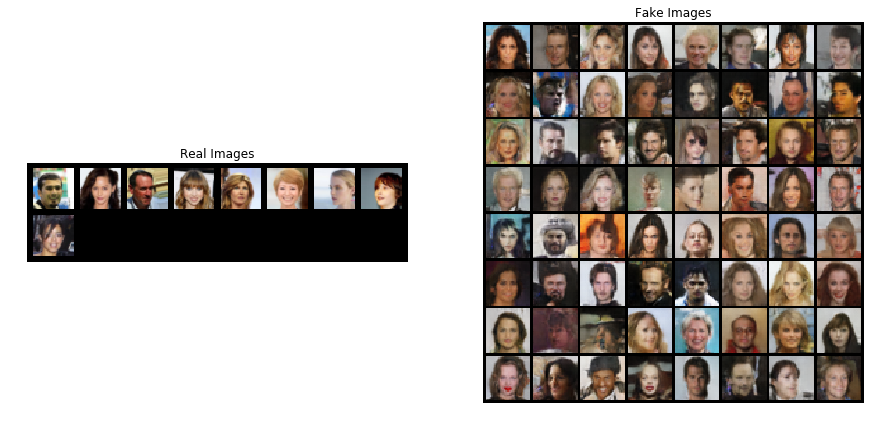

[3/5][0/22511]	Loss_D: 0.9952	Loss_G: 1.7936	D(x): 0.3298	D(G(z)): 0.7231 / 0.8288
[3/5][50/22511]	Loss_D: 0.8786	Loss_G: 1.6544	D(x): 0.1843	D(G(z)): 0.7146 / 0.8030
[3/5][100/22511]	Loss_D: 0.9498	Loss_G: 2.0428	D(x): 0.0739	D(G(z)): 0.7120 / 0.8625
[3/5][150/22511]	Loss_D: 0.8588	Loss_G: 1.8742	D(x): 0.1857	D(G(z)): 0.8685 / 0.8393
[3/5][200/22511]	Loss_D: 1.0316	Loss_G: 1.6816	D(x): 0.1743	D(G(z)): 0.7095 / 0.8053
[3/5][250/22511]	Loss_D: 0.9094	Loss_G: 1.7604	D(x): 0.2005	D(G(z)): 0.7875 / 0.8269
[3/5][300/22511]	Loss_D: 0.8767	Loss_G: 2.1120	D(x): 0.1466	D(G(z)): 0.7950 / 0.8714
[3/5][350/22511]	Loss_D: 0.8765	Loss_G: 1.7292	D(x): 0.2660	D(G(z)): 0.8224 / 0.8113
[3/5][400/22511]	Loss_D: 1.0075	Loss_G: 1.7945	D(x): 0.3673	D(G(z)): 0.7704 / 0.8280
[3/5][450/22511]	Loss_D: 0.8767	Loss_G: 1.9214	D(x): 0.1984	D(G(z)): 0.6938 / 0.8510
[3/5][500/22511]	Loss_D: 0.9329	Loss_G: 1.6555	D(x): 0.0951	D(G(z)): 0.6910 / 0.7989
[3/5][550/22511]	Loss_D: 0.8975	Loss_G: 2.2960	D(x): 0.1831	D(G(z)):

[3/5][4800/22511]	Loss_D: 1.0162	Loss_G: 1.8454	D(x): 0.1197	D(G(z)): 0.6126 / 0.8367
[3/5][4850/22511]	Loss_D: 1.0392	Loss_G: 1.8326	D(x): 0.3107	D(G(z)): 0.6751 / 0.8366
[3/5][4900/22511]	Loss_D: 0.7730	Loss_G: 2.0712	D(x): 0.1387	D(G(z)): 0.7932 / 0.8724
[3/5][4950/22511]	Loss_D: 1.1010	Loss_G: 1.5116	D(x): 0.4383	D(G(z)): 0.7769 / 0.7746
[3/5][5000/22511]	Loss_D: 0.9510	Loss_G: 2.0319	D(x): 0.0771	D(G(z)): 0.7985 / 0.8579
[3/5][5050/22511]	Loss_D: 1.0662	Loss_G: 1.8529	D(x): 0.2826	D(G(z)): 0.6267 / 0.8391
[3/5][5100/22511]	Loss_D: 1.3722	Loss_G: 1.4434	D(x): 0.5627	D(G(z)): 0.7621 / 0.7595
[3/5][5150/22511]	Loss_D: 0.8926	Loss_G: 2.0265	D(x): 0.2394	D(G(z)): 0.8672 / 0.8637
[3/5][5200/22511]	Loss_D: 0.8957	Loss_G: 1.7485	D(x): 0.1614	D(G(z)): 0.8283 / 0.8166
[3/5][5250/22511]	Loss_D: 0.8574	Loss_G: 1.9516	D(x): 0.2248	D(G(z)): 0.7319 / 0.8508
[3/5][5300/22511]	Loss_D: 0.9297	Loss_G: 1.9410	D(x): 0.2450	D(G(z)): 0.8336 / 0.8529
[3/5][5350/22511]	Loss_D: 0.6839	Loss_G: 2.8183	D(x): 

[3/5][9600/22511]	Loss_D: 1.1307	Loss_G: 1.7345	D(x): 0.3738	D(G(z)): 0.6366 / 0.8176
[3/5][9650/22511]	Loss_D: 1.1455	Loss_G: 1.5464	D(x): 0.4314	D(G(z)): 0.8497 / 0.7789
[3/5][9700/22511]	Loss_D: 0.8444	Loss_G: 2.0533	D(x): 0.1501	D(G(z)): 0.8903 / 0.8657
[3/5][9750/22511]	Loss_D: 0.9520	Loss_G: 1.8061	D(x): 0.1651	D(G(z)): 0.5994 / 0.8310
[3/5][9800/22511]	Loss_D: 0.9495	Loss_G: 2.1034	D(x): 0.2956	D(G(z)): 0.9083 / 0.8740
[3/5][9850/22511]	Loss_D: 0.9634	Loss_G: 1.8383	D(x): 0.1231	D(G(z)): 0.7000 / 0.8365
[3/5][9900/22511]	Loss_D: 0.9309	Loss_G: 1.7950	D(x): 0.1143	D(G(z)): 0.8050 / 0.8264
[3/5][9950/22511]	Loss_D: 0.8603	Loss_G: 2.0213	D(x): 0.1142	D(G(z)): 0.7964 / 0.8610
[3/5][10000/22511]	Loss_D: 0.8515	Loss_G: 1.9725	D(x): 0.1539	D(G(z)): 0.8833 / 0.8564
[3/5][10050/22511]	Loss_D: 0.9205	Loss_G: 1.8522	D(x): 0.2177	D(G(z)): 0.8115 / 0.8294
[3/5][10100/22511]	Loss_D: 1.2185	Loss_G: 1.4444	D(x): 0.5015	D(G(z)): 0.8422 / 0.7599
[3/5][10150/22511]	Loss_D: 0.9665	Loss_G: 1.7819	D(

[3/5][14350/22511]	Loss_D: 1.0502	Loss_G: 1.5186	D(x): 0.4516	D(G(z)): 0.8049 / 0.7754
[3/5][14400/22511]	Loss_D: 0.8111	Loss_G: 1.9840	D(x): 0.1351	D(G(z)): 0.7722 / 0.8565
[3/5][14450/22511]	Loss_D: 0.9458	Loss_G: 1.7636	D(x): 0.1933	D(G(z)): 0.7570 / 0.8229
[3/5][14500/22511]	Loss_D: 1.1237	Loss_G: 2.0962	D(x): 0.0520	D(G(z)): 0.7466 / 0.8756
[3/5][14550/22511]	Loss_D: 0.9845	Loss_G: 1.7280	D(x): 0.1447	D(G(z)): 0.7372 / 0.8163
[3/5][14600/22511]	Loss_D: 1.0297	Loss_G: 1.8820	D(x): 0.1110	D(G(z)): 0.8715 / 0.8421
[3/5][14650/22511]	Loss_D: 0.9014	Loss_G: 1.8389	D(x): 0.3338	D(G(z)): 0.8713 / 0.8279
[3/5][14700/22511]	Loss_D: 0.8812	Loss_G: 1.7443	D(x): 0.2748	D(G(z)): 0.8294 / 0.8185
[3/5][14750/22511]	Loss_D: 0.9303	Loss_G: 1.7029	D(x): 0.1671	D(G(z)): 0.7654 / 0.8116
[3/5][14800/22511]	Loss_D: 0.8304	Loss_G: 2.2278	D(x): 0.1711	D(G(z)): 0.7632 / 0.8864
[3/5][14850/22511]	Loss_D: 1.1080	Loss_G: 2.0600	D(x): 0.3811	D(G(z)): 0.9313 / 0.8655
[3/5][14900/22511]	Loss_D: 0.8241	Loss_G: 1

[3/5][19100/22511]	Loss_D: 0.9518	Loss_G: 1.9989	D(x): 0.1254	D(G(z)): 0.9070 / 0.8551
[3/5][19150/22511]	Loss_D: 0.7811	Loss_G: 1.8123	D(x): 0.1245	D(G(z)): 0.7723 / 0.8266
[3/5][19200/22511]	Loss_D: 0.8786	Loss_G: 1.7219	D(x): 0.2001	D(G(z)): 0.7735 / 0.8161
[3/5][19250/22511]	Loss_D: 0.8924	Loss_G: 2.2844	D(x): 0.1010	D(G(z)): 0.7951 / 0.8966
[3/5][19300/22511]	Loss_D: 0.9458	Loss_G: 2.1496	D(x): 0.0708	D(G(z)): 0.8977 / 0.8817
[3/5][19350/22511]	Loss_D: 0.9707	Loss_G: 1.8104	D(x): 0.1806	D(G(z)): 0.6440 / 0.8309
[3/5][19400/22511]	Loss_D: 0.9387	Loss_G: 1.6869	D(x): 0.1666	D(G(z)): 0.6844 / 0.8093
[3/5][19450/22511]	Loss_D: 1.1252	Loss_G: 1.4972	D(x): 0.4709	D(G(z)): 0.7594 / 0.7638
[3/5][19500/22511]	Loss_D: 0.8609	Loss_G: 1.8811	D(x): 0.1646	D(G(z)): 0.7948 / 0.8422
[3/5][19550/22511]	Loss_D: 1.0083	Loss_G: 1.8930	D(x): 0.0736	D(G(z)): 0.7214 / 0.8454
[3/5][19600/22511]	Loss_D: 0.9672	Loss_G: 1.7759	D(x): 0.1531	D(G(z)): 0.8056 / 0.8268
[3/5][19650/22511]	Loss_D: 0.9258	Loss_G: 1

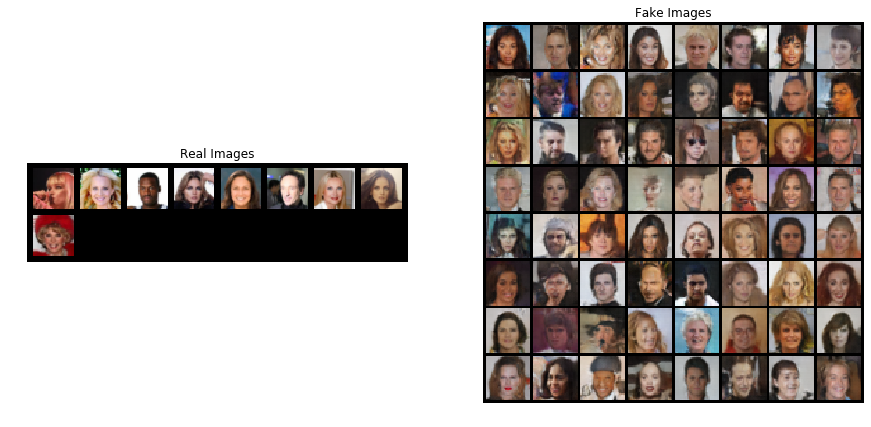

[4/5][0/22511]	Loss_D: 0.9250	Loss_G: 1.5078	D(x): 0.1344	D(G(z)): 0.7172 / 0.7686
[4/5][50/22511]	Loss_D: 0.9557	Loss_G: 2.0239	D(x): 0.3011	D(G(z)): 0.8957 / 0.8636
[4/5][100/22511]	Loss_D: 0.8236	Loss_G: 1.8800	D(x): 0.2297	D(G(z)): 0.8272 / 0.8389
[4/5][150/22511]	Loss_D: 0.9531	Loss_G: 2.1427	D(x): 0.3593	D(G(z)): 0.8520 / 0.8760
[4/5][200/22511]	Loss_D: 0.9458	Loss_G: 2.1437	D(x): 0.2857	D(G(z)): 0.9148 / 0.8785
[4/5][250/22511]	Loss_D: 0.8920	Loss_G: 1.7721	D(x): 0.1208	D(G(z)): 0.7696 / 0.8261
[4/5][300/22511]	Loss_D: 0.8773	Loss_G: 2.3313	D(x): 0.1118	D(G(z)): 0.8914 / 0.8954
[4/5][350/22511]	Loss_D: 0.9435	Loss_G: 1.9122	D(x): 0.2958	D(G(z)): 0.7687 / 0.8478
[4/5][400/22511]	Loss_D: 0.9287	Loss_G: 2.0813	D(x): 0.2511	D(G(z)): 0.8973 / 0.8715
[4/5][450/22511]	Loss_D: 1.0392	Loss_G: 1.8989	D(x): 0.0861	D(G(z)): 0.7303 / 0.8428
[4/5][500/22511]	Loss_D: 0.7916	Loss_G: 2.1061	D(x): 0.1468	D(G(z)): 0.8946 / 0.8744
[4/5][550/22511]	Loss_D: 0.8624	Loss_G: 2.0047	D(x): 0.2889	D(G(z)):

[4/5][4800/22511]	Loss_D: 0.9897	Loss_G: 1.4204	D(x): 0.3889	D(G(z)): 0.7653 / 0.7571
[4/5][4850/22511]	Loss_D: 0.9654	Loss_G: 1.8390	D(x): 0.1186	D(G(z)): 0.5713 / 0.8375
[4/5][4900/22511]	Loss_D: 0.7553	Loss_G: 1.9225	D(x): 0.1361	D(G(z)): 0.8322 / 0.8484
[4/5][4950/22511]	Loss_D: 0.8334	Loss_G: 2.0066	D(x): 0.1334	D(G(z)): 0.7879 / 0.8611
[4/5][5000/22511]	Loss_D: 0.9093	Loss_G: 1.9417	D(x): 0.0775	D(G(z)): 0.8779 / 0.8555
[4/5][5050/22511]	Loss_D: 0.9997	Loss_G: 1.5808	D(x): 0.2151	D(G(z)): 0.6612 / 0.7875
[4/5][5100/22511]	Loss_D: 1.1192	Loss_G: 1.4685	D(x): 0.3846	D(G(z)): 0.8682 / 0.7654
[4/5][5150/22511]	Loss_D: 0.8961	Loss_G: 1.9513	D(x): 0.2666	D(G(z)): 0.8242 / 0.8540
[4/5][5200/22511]	Loss_D: 0.9859	Loss_G: 1.5677	D(x): 0.2692	D(G(z)): 0.8712 / 0.7856
[4/5][5250/22511]	Loss_D: 0.9328	Loss_G: 1.8709	D(x): 0.2559	D(G(z)): 0.7180 / 0.8420
[4/5][5300/22511]	Loss_D: 0.8966	Loss_G: 1.8447	D(x): 0.1194	D(G(z)): 0.7589 / 0.8371
[4/5][5350/22511]	Loss_D: 0.8278	Loss_G: 1.9417	D(x): 

[4/5][9600/22511]	Loss_D: 1.0640	Loss_G: 1.6235	D(x): 0.3554	D(G(z)): 0.7028 / 0.7921
[4/5][9650/22511]	Loss_D: 0.8158	Loss_G: 1.8378	D(x): 0.2369	D(G(z)): 0.8294 / 0.8339
[4/5][9700/22511]	Loss_D: 1.2560	Loss_G: 2.2102	D(x): 0.4936	D(G(z)): 0.9463 / 0.8847
[4/5][9750/22511]	Loss_D: 0.8925	Loss_G: 2.0140	D(x): 0.3131	D(G(z)): 0.8663 / 0.8550
[4/5][9800/22511]	Loss_D: 0.8351	Loss_G: 2.0866	D(x): 0.3201	D(G(z)): 0.8887 / 0.8732
[4/5][9850/22511]	Loss_D: 0.7970	Loss_G: 2.0799	D(x): 0.2254	D(G(z)): 0.8956 / 0.8677
[4/5][9900/22511]	Loss_D: 0.8547	Loss_G: 2.7176	D(x): 0.2210	D(G(z)): 0.9488 / 0.9312
[4/5][9950/22511]	Loss_D: 1.0675	Loss_G: 1.6409	D(x): 0.3721	D(G(z)): 0.6557 / 0.7996
[4/5][10000/22511]	Loss_D: 1.1902	Loss_G: 1.9692	D(x): 0.5765	D(G(z)): 0.9264 / 0.8528
[4/5][10050/22511]	Loss_D: 0.8813	Loss_G: 1.8486	D(x): 0.2328	D(G(z)): 0.8414 / 0.8372
[4/5][10100/22511]	Loss_D: 0.8392	Loss_G: 2.3619	D(x): 0.2862	D(G(z)): 0.9381 / 0.8946
[4/5][10150/22511]	Loss_D: 0.8909	Loss_G: 1.7113	D(

[4/5][14350/22511]	Loss_D: 1.1222	Loss_G: 1.9955	D(x): 0.5506	D(G(z)): 0.9035 / 0.8579
[4/5][14400/22511]	Loss_D: 0.9703	Loss_G: 1.5322	D(x): 0.2054	D(G(z)): 0.8377 / 0.7772
[4/5][14450/22511]	Loss_D: 0.8915	Loss_G: 2.2164	D(x): 0.1628	D(G(z)): 0.9086 / 0.8819
[4/5][14500/22511]	Loss_D: 1.2590	Loss_G: 1.5859	D(x): 0.5430	D(G(z)): 0.8878 / 0.7910
[4/5][14550/22511]	Loss_D: 1.1377	Loss_G: 1.7465	D(x): 0.4498	D(G(z)): 0.8969 / 0.8177
[4/5][14600/22511]	Loss_D: 0.8606	Loss_G: 1.9629	D(x): 0.2137	D(G(z)): 0.7708 / 0.8545
[4/5][14650/22511]	Loss_D: 0.9095	Loss_G: 1.7311	D(x): 0.1159	D(G(z)): 0.6241 / 0.8146
[4/5][14700/22511]	Loss_D: 0.8691	Loss_G: 1.8631	D(x): 0.1746	D(G(z)): 0.7012 / 0.8418
[4/5][14750/22511]	Loss_D: 0.9087	Loss_G: 1.9675	D(x): 0.0947	D(G(z)): 0.7069 / 0.8570
[4/5][14800/22511]	Loss_D: 0.8624	Loss_G: 2.1051	D(x): 0.1609	D(G(z)): 0.8505 / 0.8740
[4/5][14850/22511]	Loss_D: 0.6291	Loss_G: 2.0964	D(x): 0.1509	D(G(z)): 0.8631 / 0.8749
[4/5][14900/22511]	Loss_D: 0.7944	Loss_G: 2

[4/5][19100/22511]	Loss_D: 1.0158	Loss_G: 1.7435	D(x): 0.0740	D(G(z)): 0.6840 / 0.8235
[4/5][19150/22511]	Loss_D: 0.8947	Loss_G: 2.1633	D(x): 0.2764	D(G(z)): 0.8548 / 0.8744
[4/5][19200/22511]	Loss_D: 0.9201	Loss_G: 2.0613	D(x): 0.1482	D(G(z)): 0.7438 / 0.8714
[4/5][19250/22511]	Loss_D: 1.0919	Loss_G: 2.1822	D(x): 0.1454	D(G(z)): 0.5621 / 0.8809
[4/5][19300/22511]	Loss_D: 1.0427	Loss_G: 1.7075	D(x): 0.0388	D(G(z)): 0.7320 / 0.8117
[4/5][19350/22511]	Loss_D: 0.8042	Loss_G: 2.2849	D(x): 0.1951	D(G(z)): 0.8935 / 0.8902
[4/5][19400/22511]	Loss_D: 0.8795	Loss_G: 1.6746	D(x): 0.1313	D(G(z)): 0.8300 / 0.8058
[4/5][19450/22511]	Loss_D: 1.0026	Loss_G: 1.7090	D(x): 0.0610	D(G(z)): 0.7799 / 0.8151
[4/5][19500/22511]	Loss_D: 0.8464	Loss_G: 1.9405	D(x): 0.2824	D(G(z)): 0.8538 / 0.8521
[4/5][19550/22511]	Loss_D: 0.9862	Loss_G: 1.6625	D(x): 0.3221	D(G(z)): 0.8430 / 0.8047
[4/5][19600/22511]	Loss_D: 0.8305	Loss_G: 1.8677	D(x): 0.1848	D(G(z)): 0.8252 / 0.8428
[4/5][19650/22511]	Loss_D: 0.8632	Loss_G: 1

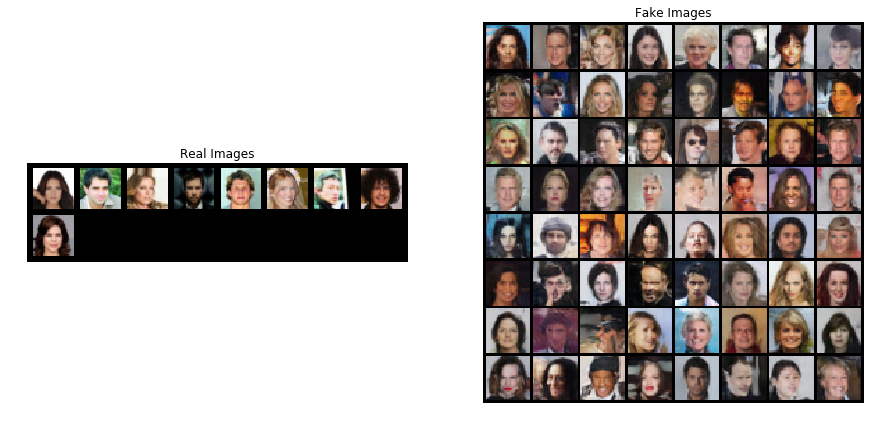

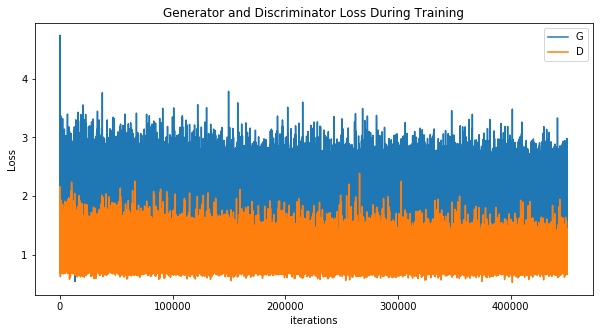

In [50]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for j in range(proGAN.layer_progression+1):
    
    dataset = dset.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Resize(proGAN.image_size),
                                   transforms.CenterCrop(proGAN.image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ]))
    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=proGAN.batch_size,
                                             shuffle=True, num_workers=workers)

    # Decide which device we want to run on
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

    for epoch in range(num_epochs):
        # For each batch in the dataloader

        for i, data in enumerate(dataloader, 0):
            proGAN(data, False)

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         proGAN.errD.item(), proGAN.errG.item(), proGAN.D_x, proGAN.D_G_z1, proGAN.D_G_z2))

            # Save Losses for plotting later
            G_losses.append(proGAN.errG.item())
            D_losses.append(proGAN.errD.item())
            
            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = proGAN.generator(fixed_noise, False).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
                
            iters += 1
        # Grab a batch of real images from the dataloader
        real_batch = next(iter(dataloader))

        # Plot the real images
        plt.figure(figsize=(15,15))
        plt.subplot(1,2,1)
        plt.axis("off")
        plt.title("Real Images")
        plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

        # Plot the fake images from the last epoch
        plt.subplot(1,2,2)
        plt.axis("off")
        plt.title("Fake Images")
        plt.imshow(np.transpose(img_list[-1],(1,2,0)))
        plt.show()
    
    #progGAN.add_layer()
    #num_epochs = num_epochs*2
    
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    


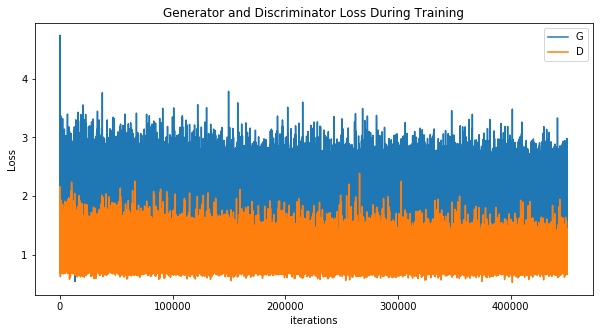

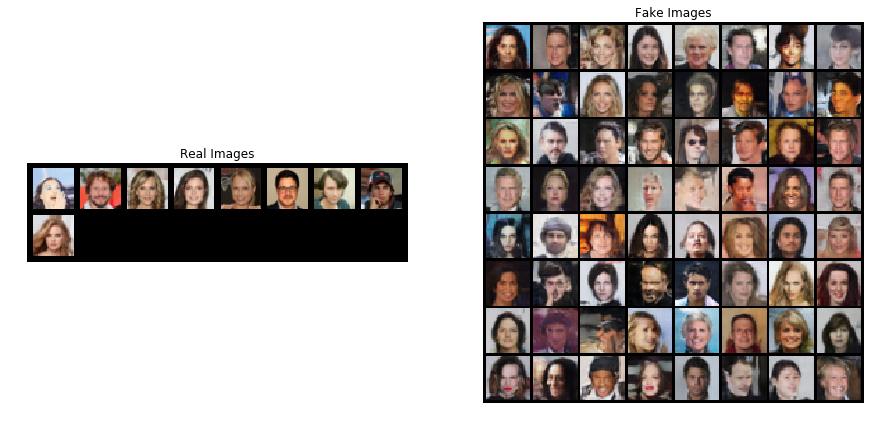

In [51]:
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    # Grab a batch of real images from the dataloader
    real_batch = next(iter(dataloader))

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.show()

In [125]:
model = torch.load('./models/proGAN')
noise = torch.zeros(256, proGAN.latent_size, 1, 1, device=device)
noise[:,3,0,0] = torch.arange(0,2,2/256)

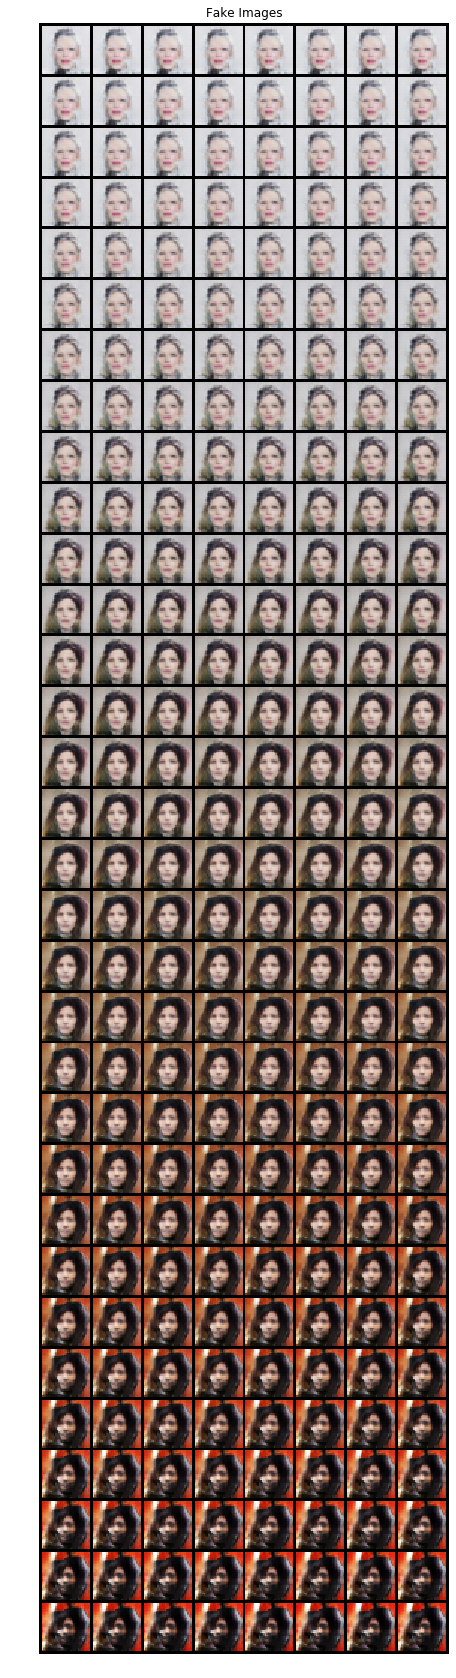

In [126]:
generated_img = model.generator(noise, False).detach().cpu()
img = vutils.make_grid(generated_img, padding=2, normalize=True)

plt.figure(figsize=(10,30))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img,(1,2,0)))
plt.show()